[View in Colaboratory](https://colab.research.google.com/github/ankanbhunia/Colab/blob/master/finassl.ipynb)

In [0]:
!python Train.py

In [0]:
import re
import shutil
import tensorflow as tf
from __future__ import division
import matplotlib.pyplot as plt

MP_NAME = 'mp'

params = {'batch_size' : 4,
          'train_log' : 'train_log99',
          'model_dir' : 'model458g',
          'output_dir' : 'output',
          'log_device_placement' : False,
          'data_train_gt' : '/content/Data_original/Data_gt/train_gt/',
          'data_train_im' : '/content/Data_original/Data_im/train_im/',
          'data_train_index' : '/content/Data_original/dir_name.txt',
          'num_epochs_per_decay' : 20,
          'learning_rate_per_decay' : 0.9,
          'initial_learning_rate' :1.0e-1  
}

In [0]:
def _activation_summary(x):

    tensor_name = re.sub('%s_[0-9]*/' % MP_NAME, '', x.op.name)
    tf.summary.histogram(tensor_name + '/activations', x)
    tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(x))


def _variable_on_cpu(name, shape, initializer):

    with tf.device('/gpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer)

    return var


def _variable_with_weight_decay(name, shape, stddev, wd):

    var = _variable_on_cpu(name, shape, tf.random_normal_initializer(stddev=stddev))
    if wd:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)

    return var


class BatchNorm(object):

    def __init__(self, epsilon=1e-5, momentum=0.9, name="batch_norm"):

        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x):

        return tf.contrib.layers.batch_norm(x, decay=self.momentum, updates_collections=None,
                                            epsilon=self.epsilon, scale=True, scope=self.name)


def multi_scale_block(in_con, in_dim, out_dim, is_bn=False):

    with tf.variable_scope('con_9') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[9, 9, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_9 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_9)

    with tf.variable_scope('con_7') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[7, 7, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_7 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_7)

    with tf.variable_scope('con_5') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[5, 5, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_5 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_5)

    with tf.variable_scope('con_3') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[3, 3, in_dim, out_dim],
                                             stddev=0.01, wd=0.0005)
        con_3 = tf.nn.conv2d(in_con, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
        _activation_summary(con_3)

    with tf.variable_scope('concat') as scope:
        concat = tf.concat([con_9, con_7, con_5, con_3], 3, name=scope.name)
        biases = _variable_on_cpu('biases', [out_dim * 4], tf.constant_initializer(0))
        bias = tf.nn.bias_add(concat, biases)

        if is_bn:
            bn = BatchNorm()
            bias = bn(bias)

        msb = tf.nn.relu(bias)
        _activation_summary(msb)

    return msb



def inference_bn(images):
    
    with tf.variable_scope('Network', reuse=tf.AUTO_REUSE):

        with tf.variable_scope('con1') as scope:
            kernel = _variable_with_weight_decay('weights', shape=[9, 9, 3, 64],
                                                 stddev=0.01, wd=0.0005)
            con = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
            biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0))
            bias = tf.nn.bias_add(con, biases)
            con1 = tf.nn.relu(bias)
            _activation_summary(con1)

        # msb_con2
        with tf.variable_scope('msb_con2'):
            msb_con2 = multi_scale_block(con1, 64, 16, is_bn=True)

        # pool_msb_con2
        with tf.variable_scope('pool_msb_con2') as scope:
            pool_msb_con2 = tf.nn.max_pool(msb_con2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                                           name=scope.name)

        # msb_con3
        with tf.variable_scope('msb_con3'):
            msb_con3 = multi_scale_block(pool_msb_con2, 64, 32, is_bn=True)

        # msb_con4
        with tf.variable_scope('msb_con4'):
            msb_con4 = multi_scale_block(msb_con3, 128, 32, is_bn=True)

        # pool_msb_con4
        with tf.variable_scope('pool_msb_con4') as scope:
            pool_msb_con4 = tf.nn.max_pool(msb_con4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                                           name=scope.name)

        # msb_con5
        with tf.variable_scope('msb_con5'):
            msb_con5 = multi_scale_block(pool_msb_con4, 128, 64, is_bn=True)

        # msb_con6
        with tf.variable_scope('msb_con6'):
            msb_con6 = multi_scale_block(msb_con5, 256, 64, is_bn=True)

        # mpl_con7
        with tf.variable_scope('mpl_con7') as scope:
            kernel = _variable_with_weight_decay('weights', shape=[1, 1, 256, 1000], stddev=0.001, wd=0.0005)
            con = tf.nn.conv2d(msb_con6, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
            biases = _variable_on_cpu('biases', [1000], tf.constant_initializer(0))
            bias = tf.nn.bias_add(con, biases)
            mpl_con7 = tf.nn.relu(bias)
            _activation_summary(mpl_con7)

        # con_out
        with tf.variable_scope('con_out') as scope:
            kernel = _variable_with_weight_decay('weights', shape=[1, 1, 1000, 1], stddev=0.001, wd=0.0005)
            con = tf.nn.conv2d(mpl_con7, kernel, [1, 1, 1, 1], padding='SAME', name=scope.name)
            biases = _variable_on_cpu('biases', [1], tf.constant_initializer(0))
            bias = tf.nn.bias_add(con, biases)

            bn = BatchNorm()
            bias = bn(bias)

            con_out = tf.nn.relu(tf.nn.sigmoid(bias))
            _activation_summary(con_out)

        image_out = con_out

        tf.summary.image("con_img", image_out)

        return image_out


def get_loss(predict, label):

    l2_loss = tf.reduce_sum((predict - label) * (predict - label))

    tf.summary.histogram('loss', l2_loss)

    return l2_loss


def add_avg_loss(avg_loss):

    add_avg_loss_op = avg_loss * 1
    tf.summary.histogram('avg_loss', avg_loss)

    return add_avg_loss_op


def _add_loss_summaries(total_loss):

    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    losses = tf.get_collection('losses')
    loss_averages_op = loss_averages.apply(losses + [total_loss])

    for l in losses + [total_loss]:
        tf.summary.scalar(l.op.name + ' (raw)', l)
        tf.summary.scalar(l.op.name, loss_averages.average(l))

    return loss_averages_op


def train(total_loss, global_step, nums_per_train):

    num_batches_per_epoch = nums_per_train / params['batch_size']
    decay_steps = int(num_batches_per_epoch * params['num_epochs_per_decay'])

    lr = tf.train.exponential_decay(params['initial_learning_rate'],
                                    global_step,
                                    decay_steps,
                                    params['learning_rate_per_decay'],
                                    staircase=True)
    tf.summary.scalar('learning_rate', lr)

  
    opt = tf.train.RMSPropOptimizer(lr)
    grads = opt.compute_gradients(total_loss)


    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)
    train_op = apply_gradient_op

    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    return train_op

In [0]:
class batch_norm(object):
            # h1 = lrelu(tf.contrib.layers.batch_norm(conv2d(h0, self.df_dim*2, name='d_h1_conv'),decay=0.9,updates_collections=None,epsilon=0.00001,scale=True,scope="d_h1_conv"))
    def __init__(self, epsilon=0.001, momentum = 0, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x, decay=self.momentum, updates_collections=None, epsilon=self.epsilon, scale=True, scope=self.name)

def conv2d(input_, output_dim, 
           k_h=5, k_w=5, d_h=1, d_w=1, stddev=0.02,
           name="conv2d",relu = True, bn = True):
    
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.bias_add(conv, biases)
        if relu:
            conv  = tf.nn.relu(conv)
        if bn:
            bnF = batch_norm(name = name+'_bn')
            conv = bnF(conv)
        
        return conv

In [0]:
def inference_bn_(Input):
    
    with tf.variable_scope('Network', reuse=tf.AUTO_REUSE):

        with tf.variable_scope('Branch1') as scope:

            Branch1_conv1 = conv2d(Input, 16, 9, 9, name = 'conv1')
            Branch1_pool1 = tf.layers.max_pooling2d(Branch1_conv1, 2, 2, padding = 'same')
            Branch1_conv2 = conv2d(Branch1_pool1, 32, 7, 7, name = 'conv2')
            Branch1_pool2 = tf.layers.max_pooling2d(Branch1_conv2, 2, 2, padding = 'same')
            Branch1_conv3 = conv2d(Branch1_pool2, 16, 7, 7, name = 'conv3')
            Branch1_conv4 = conv2d(Branch1_conv3, 8, 7, 7, name = 'conv4')

        with tf.variable_scope('Branch2') as scope:

            Branch2_conv1 = conv2d(Input, 20, 7, 7, name = 'conv1')
            Branch2_pool1 = tf.layers.max_pooling2d(Branch2_conv1, 2, 2, padding = 'same')
            Branch2_conv2 = conv2d(Branch2_pool1, 40, 5, 5, name = 'conv2')
            Branch2_pool2 = tf.layers.max_pooling2d(Branch2_conv2, 2, 2, padding = 'same')
            Branch2_conv3 = conv2d(Branch2_pool2, 20, 5, 5, name = 'conv3')
            Branch2_conv4 = conv2d(Branch2_conv3, 10, 5, 5, name = 'conv4')

        with tf.variable_scope('Branch3') as scope:

            Branch3_conv1 = conv2d(Input, 24, 5, 5, name = 'conv1')
            Branch3_pool1 = tf.layers.max_pooling2d(Branch3_conv1, 2, 2, padding = 'same')
            Branch3_conv2 = conv2d(Branch3_pool1, 48, 3, 3, name = 'conv2')
            Branch3_pool2 = tf.layers.max_pooling2d(Branch3_conv2, 2, 2, padding = 'same')
            Branch3_conv3 = conv2d(Branch3_pool2, 24, 3, 3, name = 'conv3')
            Branch3_conv4 = conv2d(Branch3_conv3, 12, 3, 3, name = 'conv4')

        with tf.variable_scope('fuse') as scope:

            Fuse = tf.concat([Branch1_conv4, Branch2_conv4, Branch3_conv4],-1)
            Out = conv2d(Fuse, 1, 1, 1, name = 'Out')

        return tf.nn.relu(tf.nn.sigmoid(Out))

In [0]:
def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

def inf(x):
  
  
  with tf.variable_scope('Network', reuse=tf.AUTO_REUSE):
    
      # s net ###########################################################
      w_conv1_1 = tf.get_variable('w_conv1_1', [5, 5, 3, 24])
      b_conv1_1 = tf.get_variable('b_conv1_1', [24])
      h_conv1_1 = tf.nn.relu(conv2d(x, w_conv1_1) + b_conv1_1)

      h_pool1_1 = max_pool_2x2(h_conv1_1)

      w_conv2_1 = tf.get_variable('w_conv2_1', [3, 3, 24, 48])
      b_conv2_1 = tf.get_variable('b_conv2_1', [48])
      h_conv2_1 = tf.nn.relu(conv2d(h_pool1_1, w_conv2_1) + b_conv2_1)

      h_pool2_1 = max_pool_2x2(h_conv2_1)

      w_conv3_1 = tf.get_variable('w_conv3_1', [3, 3, 48, 24])
      b_conv3_1 = tf.get_variable('b_conv3_1', [24])
      h_conv3_1 = tf.nn.relu(conv2d(h_pool2_1, w_conv3_1) + b_conv3_1)

      w_conv4_1 = tf.get_variable('w_conv4_1', [3, 3, 24, 12])
      b_conv4_1 = tf.get_variable('b_conv4_1', [12])
      h_conv4_1 = tf.nn.relu(conv2d(h_conv3_1, w_conv4_1) + b_conv4_1)

      # m net ###########################################################
      w_conv1_2 = tf.get_variable('w_conv1_2', [7, 7, 3, 20])
      b_conv1_2 = tf.get_variable('b_conv1_2', [20])
      h_conv1_2 = tf.nn.relu(conv2d(x, w_conv1_2) + b_conv1_2)

      h_pool1_2 = max_pool_2x2(h_conv1_2)

      w_conv2_2 = tf.get_variable('w_conv2_2', [5, 5, 20, 40])
      b_conv2_2 = tf.get_variable('b_conv2_2', [40])
      h_conv2_2 = tf.nn.relu(conv2d(h_pool1_2, w_conv2_2) + b_conv2_2)

      h_pool2_2 = max_pool_2x2(h_conv2_2)

      w_conv3_2 = tf.get_variable('w_conv3_2', [5, 5, 40, 20])
      b_conv3_2 = tf.get_variable('b_conv3_2', [20])
      h_conv3_2 = tf.nn.relu(conv2d(h_pool2_2, w_conv3_2) + b_conv3_2)

      w_conv4_2 = tf.get_variable('w_conv4_2', [5, 5, 20, 10])
      b_conv4_2 = tf.get_variable('b_conv4_2', [10])
      h_conv4_2 = tf.nn.relu(conv2d(h_conv3_2, w_conv4_2) + b_conv4_2)

      # l net ###########################################################
      w_conv1_3 = tf.get_variable('w_conv1_3', [9, 9, 3, 16])
      b_conv1_3 = tf.get_variable('b_conv1_3', [16])
      h_conv1_3 = tf.nn.relu(conv2d(x, w_conv1_3) + b_conv1_3)

      h_pool1_3 = max_pool_2x2(h_conv1_3)

      w_conv2_3 = tf.get_variable('w_conv2_3', [7, 7, 16, 32])
      b_conv2_3 = tf.get_variable('b_conv2_3', [32])
      h_conv2_3 = tf.nn.relu(conv2d(h_pool1_3, w_conv2_3) + b_conv2_3)

      h_pool2_3 = max_pool_2x2(h_conv2_3)

      w_conv3_3 = tf.get_variable('w_conv3_3', [7, 7, 32, 16])
      b_conv3_3 = tf.get_variable('b_conv3_3', [16])
      h_conv3_3 = tf.nn.relu(conv2d(h_pool2_3, w_conv3_3) + b_conv3_3)

      w_conv4_3 = tf.get_variable('w_conv4_3', [7, 7, 16, 8])
      b_conv4_3 = tf.get_variable('b_conv4_3', [8])
      h_conv4_3 = tf.nn.relu(conv2d(h_conv3_3, w_conv4_3) + b_conv4_3)

      # merge ###########################################################
      h_conv4_merge = tf.concat([h_conv4_1, h_conv4_2, h_conv4_3], 3)

      w_conv5 = tf.get_variable('w_conv5', [1, 1, 30, 1])
      b_conv5 = tf.get_variable('b_conv5', [1])
      h_conv5 = conv2d(h_conv4_merge, w_conv5) + b_conv5

      y_pre = h_conv5

      return y_pre

In [0]:
def get_ranking_loss(predicts, gt):
    
    counts = [tf.squeeze(i,[0]) for i in tf.split(predicts,params['batch_size'],0)]
    counts_gt = [tf.squeeze(i,[0]) for i in tf.split(gt,params['batch_size'],0)]
 
    
    def _ranking_loss_(i_c,j_c,i_gt,j_gt):
        return tf.cond(i_gt<j_gt, lambda: tf.maximum(0.0, i_c - j_c), lambda: tf.maximum(0.0, j_c - i_c))

    import itertools
    ranking_loss = 0
    
    for i,j in itertools.combinations(np.arange(params['batch_size']), 2):
        ranking_loss = ranking_loss + _ranking_loss_(tf.reduce_sum(counts[i]), tf.reduce_sum(counts[j]), tf.reduce_sum(counts_gt[i]), tf.reduce_sum(counts_gt[j]))
    
    return ranking_loss

In [0]:
tf.split(tf.placeholder(tf.float32, [32, None,None,3]),32,0)

[<tf.Tensor 'split_1:0' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:1' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:2' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:3' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:4' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:5' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:6' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:7' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:8' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:9' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:10' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:11' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:12' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:13' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:14' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:15' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'split_1:16' shape=(1, ?, ?, 3) dtype=

In [0]:
def get_data(dir_name):
  
  nums_train = len(dir_name)
  
  num_batch = np.random.choice(nums_train,1)#random.sample(range(nums_train), nums_train)[0:params['batch_size']]

  xs, ys = [], []

  for index in num_batch:

      file_name = dir_name[index]
      im_name, gt_name = file_name.split(' ')
      gt_name = gt_name.split('\n')[0]


      batch_xs = cv2.imread(params['data_train_im'] + im_name)
      batch_xs = (np.array(batch_xs, dtype=np.float32))


      batch_ys = np.array(np.load(params['data_train_gt'] + gt_name))
      batch_ys = np.array(batch_ys, dtype=np.float32)
      batch_ys = batch_ys.reshape([batch_ys.shape[0], batch_ys.shape[1], -1])



      if np.random.choice(2)==1:
        batch_xs = cv2.flip(batch_xs,1)
        batch_ys = cv2.flip(batch_ys,1)
        if len(batch_ys.shape)==2:
          batch_ys = np.expand_dims(batch_ys,-1)


      


      xs.append(batch_xs)
      ys.append(batch_ys)

  np_xs_ = np.array(xs)
  np_ys_ = np.array(ys)

  _,w,h,_ = np_xs_.shape

  randw = np.random.random()
  randh = np.random.random()

  W0 = int(randw*(w-int(w//1.1)))
  H0 = int(randh*(h-int(h//1.1)))


  np_xs = np_xs_[:,W0:W0+int(w//1.1),H0:H0+int(h//1.1),:]

  np_ys = np_ys_[:,W0//4:W0//4+np.ceil(int(w//1.1)/4).astype('int'),H0//4:H0//4+np.ceil(int(h//1.1)/4).astype('int'),:]
  
  return np_xs, np_ys


In [0]:
def get_data(dir_name):
  
  nums_train = len(dir_name)
  
  num_batch = np.random.choice(nums_train,params['batch_size'])#random.sample(range(nums_train), nums_train)[0:params['batch_size']]
  
  hw = []

  xs, ys = [], []

  for index in num_batch:

      file_name = dir_name[index]
      im_name, gt_name = file_name.split(' ')
      gt_name = gt_name.split('\n')[0]


      batch_xs = cv2.imread(params['data_train_im'] + im_name)
      batch_xs = (np.array(batch_xs, dtype=np.float32))


      batch_ys = np.array(np.load(params['data_train_gt'] + gt_name))
      batch_ys = np.array(batch_ys, dtype=np.float32)
      batch_ys = batch_ys.reshape([batch_ys.shape[0], batch_ys.shape[1], -1])

      w,h,_ = batch_xs.shape

      hw.append([w,h])


      xs.append(batch_xs)
      ys.append(batch_ys)
      
  hw = np.array(hw)
  w0,h0 = np.min(hw[:,0]), np.min(hw[:,1])
  
  xs_, ys_ = [], []
  for batch_xs,batch_ys in zip(xs,ys):
    
    if np.random.choice(2)==1:
        batch_xs = cv2.flip(batch_xs,1)
        batch_ys = cv2.flip(batch_ys,1)
        if len(batch_ys.shape)==2:
          batch_ys = np.expand_dims(batch_ys,-1)

    w,h,_ = batch_xs.shape

    randw = np.random.random()
    randh = np.random.random()

    W0 = int(randw*(w-w0))
    H0 = int(randh*(h-h0))


    batch_xs = batch_xs[W0:W0+w0,H0:H0+h0,:]

    batch_ys = batch_ys[W0//4:W0//4+np.ceil(w0/4).astype('int'),H0//4:H0//4+np.ceil(h0/4).astype('int'),:]

    xs_.append(batch_xs)
    ys_.append(batch_ys)
    

  np_xs = np.stack(xs_,0)
  np_ys = np.stack(ys_,0)


  
  return np_xs, np_ys


In [0]:
if np.random.choice(2)==1:
        batch_xs = cv2.flip(batch_xs,1)
        batch_ys = cv2.flip(batch_ys,1)
        if len(batch_ys.shape)==2:
          batch_ys = np.expand_dims(batch_ys,-1)

        w,h,_ = batch_xs.shape

        randw = np.random.random()
        randh = np.random.random()

        W0 = int(randw*(w-int(w//1.1)))
        H0 = int(randh*(h-int(h//1.1)))


        batch_xs = batch_xs[W0:W0+int(w//1.1),H0:H0+int(h//1.1),:]

        batch_ys = batch_ys[W0//4:W0//4+np.ceil(int(w//1.1)/4).astype('int'),H0//4:H0//4+np.ceil(int(h//1.1)/4).astype('int'),:]


NameError: name 'batch_xs' is not defined

In [0]:
ff = get_data(dir_name)
 

In [0]:
ff[0].shape

(1, 698, 930, 3)

In [0]:
ff[0][1].shape

(653, 460, 3)

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from model458g/skip_mcnn.ckpt-2000
##0 >> avg_loss:8.4222994	  GT:58.2266273	 predict:151.5175781


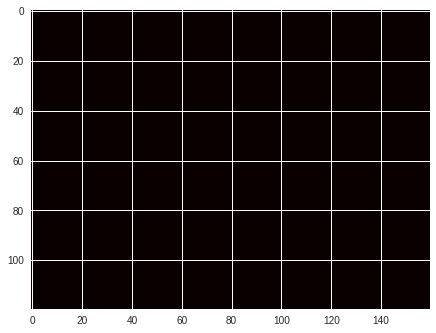

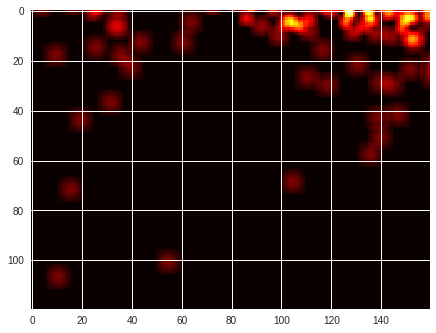

##25 >> avg_loss:12.3365555	  GT:34.4457054	 predict:57.8113823


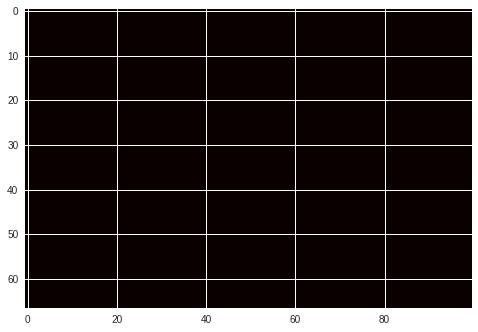

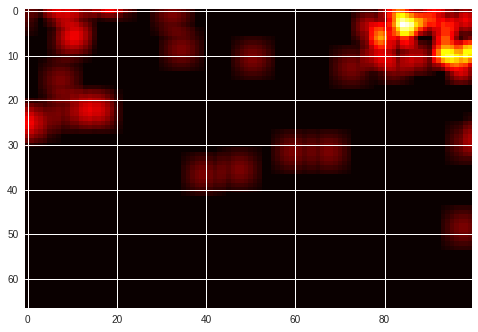

##50 >> avg_loss:57.3019829	  GT:9.7182274	 predict:83.9284363


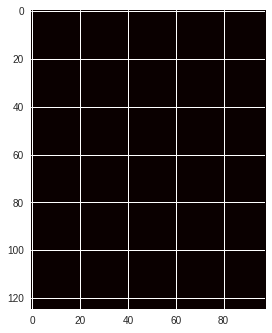

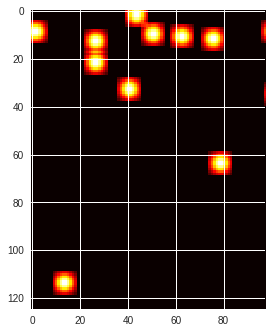

##75 >> avg_loss:66.4776993	  GT:72.3234940	 predict:323.4772034


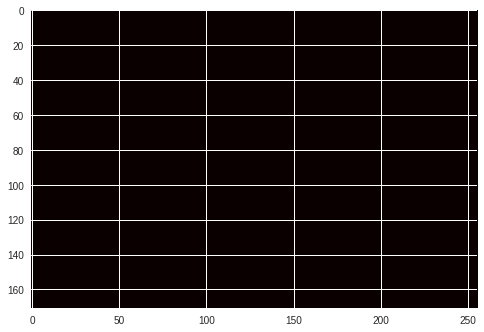

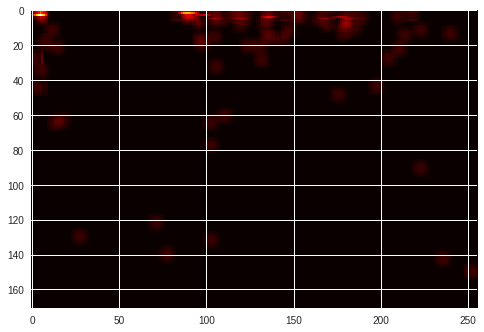

##100 >> avg_loss:170.6879730	  GT:10.9954691	 predict:83.9559631


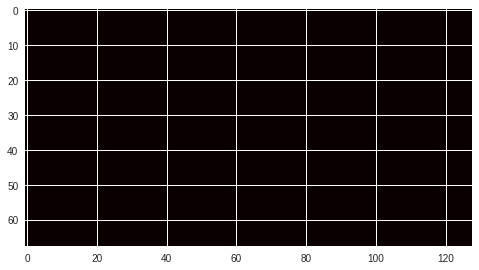

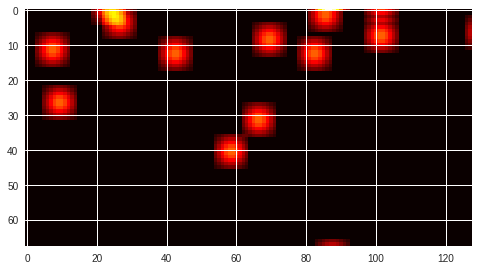

##125 >> avg_loss:240.8725891	  GT:111.0000458	 predict:137.8051453


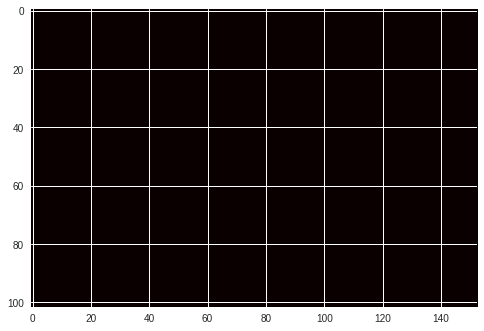

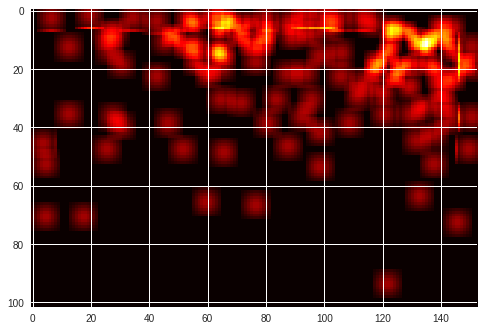

##150 >> avg_loss:1.1327109	  GT:37.9999924	 predict:37.8325996


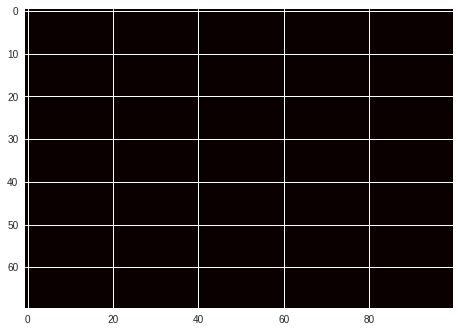

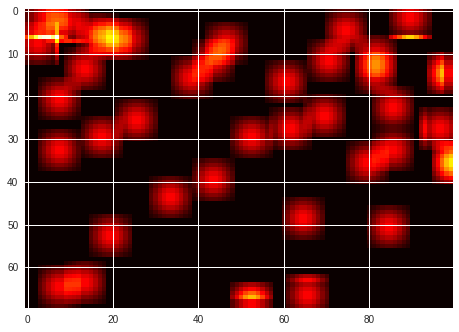

##175 >> avg_loss:448.7591248	  GT:62.3781509	 predict:72.8229599


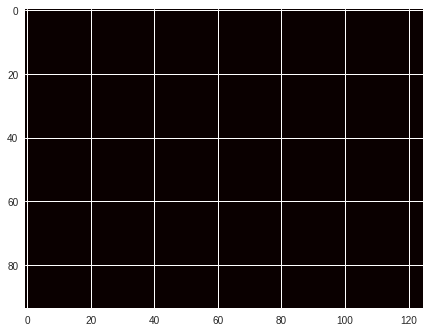

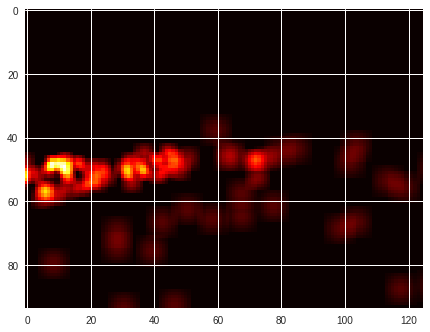

##200 >> avg_loss:20.9260063	  GT:2.8143909	 predict:82.4824142


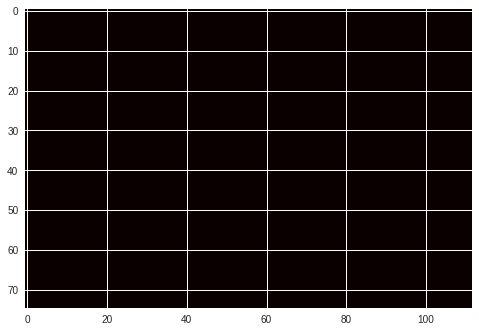

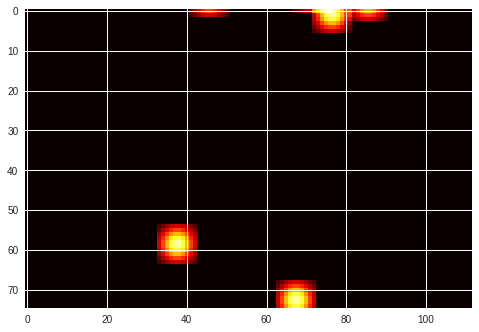

##225 >> avg_loss:74.7765656	  GT:8.0000029	 predict:84.6725388


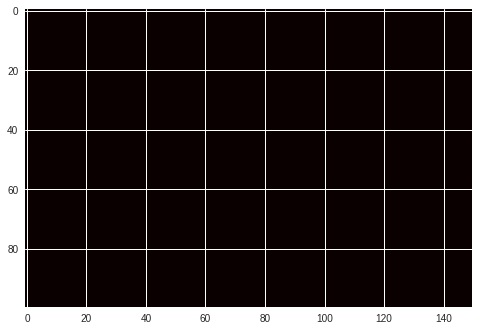

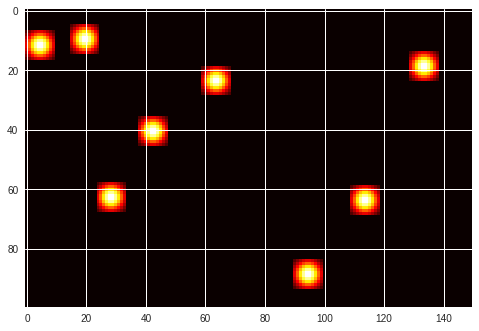

##250 >> avg_loss:26.2910347	  GT:108.9047470	 predict:281.4966736


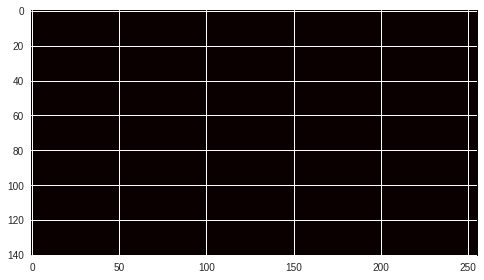

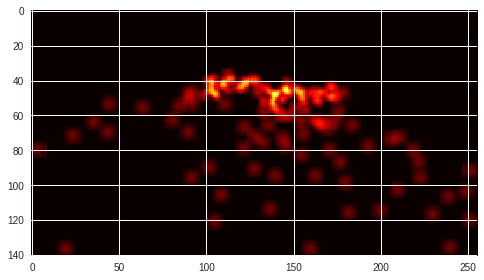

##275 >> avg_loss:19.1345444	  GT:101.0000076	 predict:398.4063721


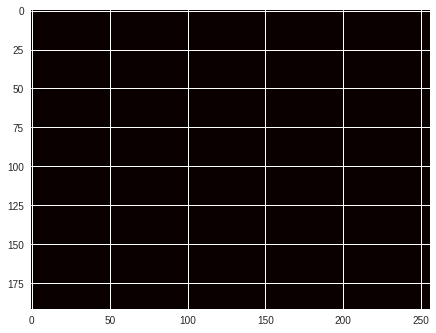

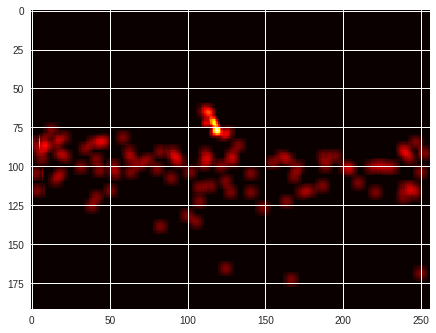

##300 >> avg_loss:170.1946716	  GT:225.3047485	 predict:254.6904907


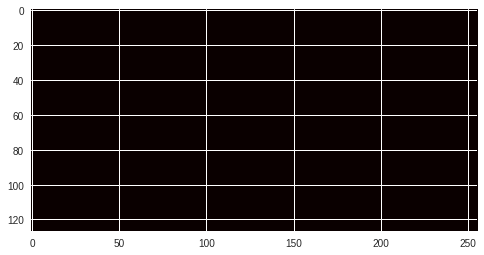

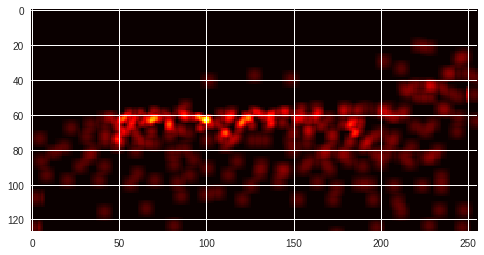

##325 >> avg_loss:30.8448181	  GT:1.2257022	 predict:181.5858459


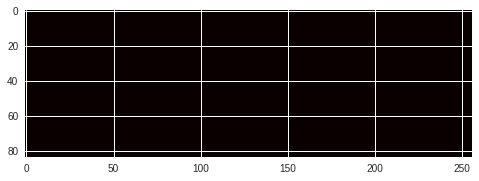

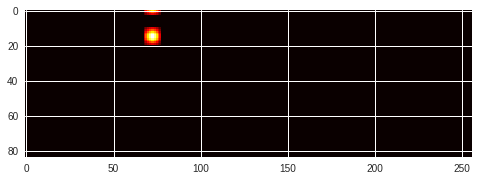

##350 >> avg_loss:120.1282196	  GT:749.9999390	 predict:403.7245789


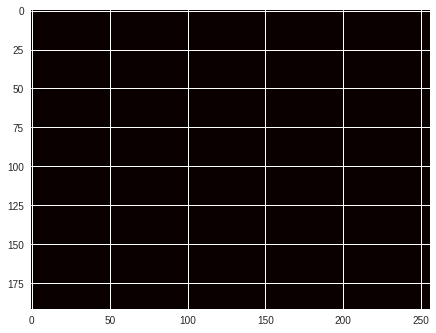

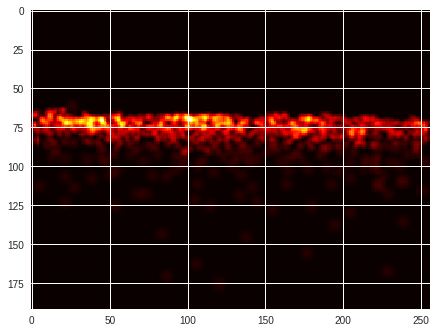

##375 >> avg_loss:64.6691360	  GT:774.9997559	 predict:289.9037781


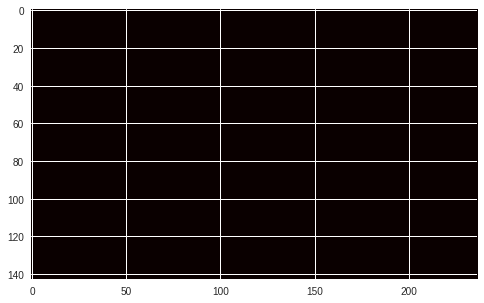

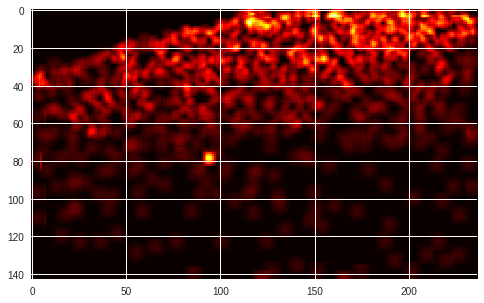

##400 >> avg_loss:33.9572716	  GT:46.0328064	 predict:273.4042664


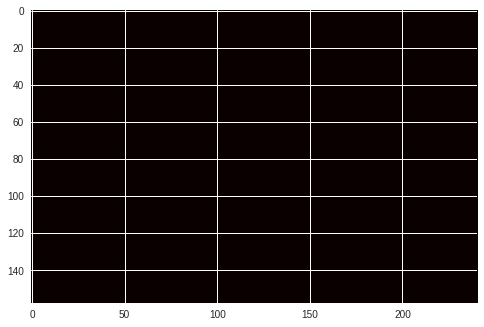

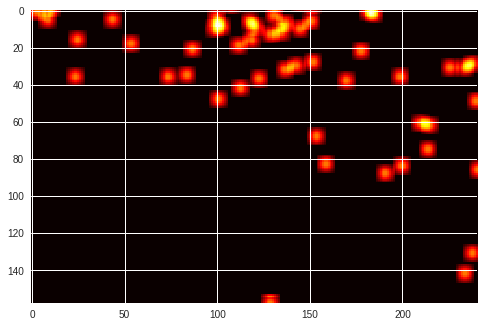

##425 >> avg_loss:30.4066868	  GT:67.9999695	 predict:347.5334167


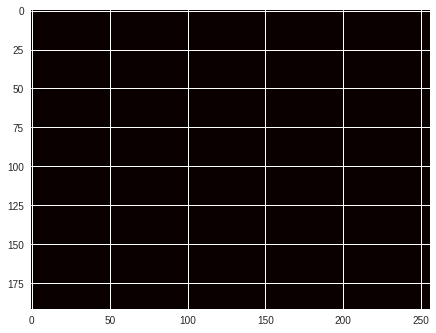

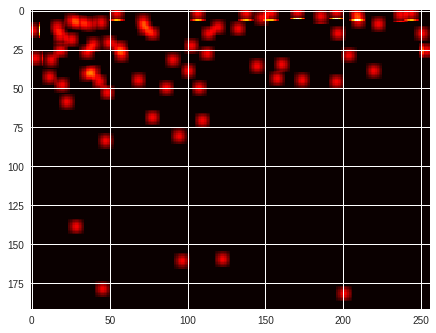

##450 >> avg_loss:264.5211182	  GT:7.4285221	 predict:167.2847290


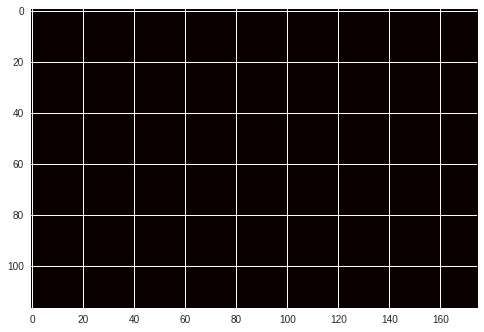

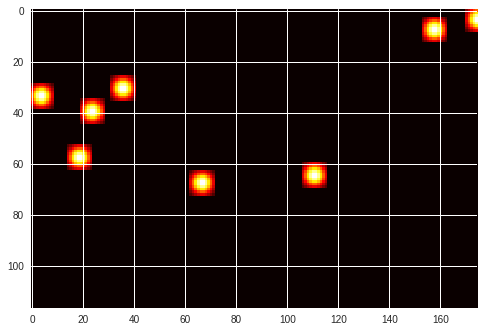

##475 >> avg_loss:4.1456485	  GT:3.0743222	 predict:89.5395126


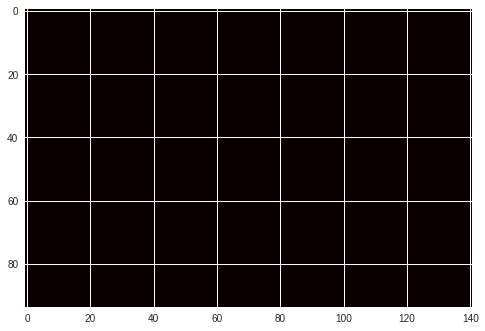

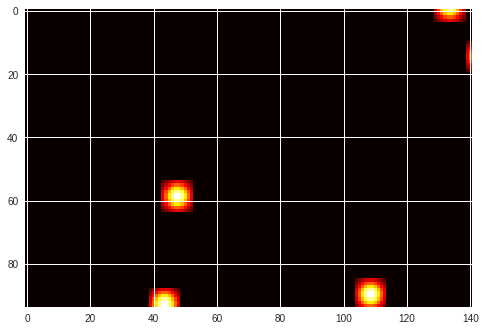

##500 >> avg_loss:9.1304331	  GT:117.3095398	 predict:247.8686218


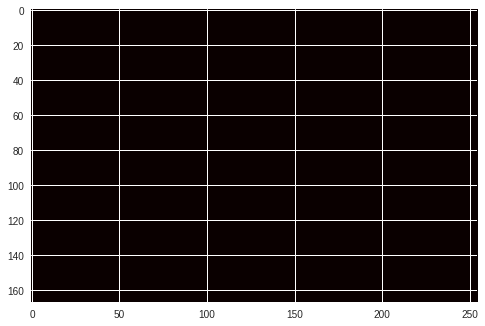

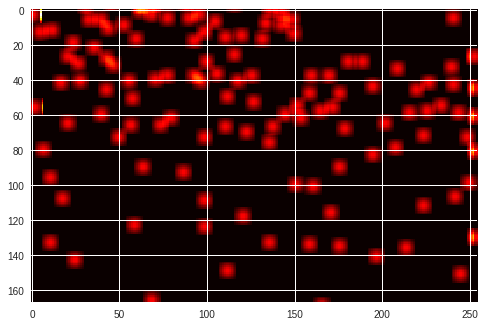

##525 >> avg_loss:319.4263611	  GT:1357.0000000	 predict:234.1130219


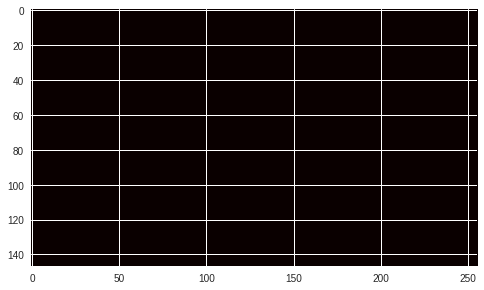

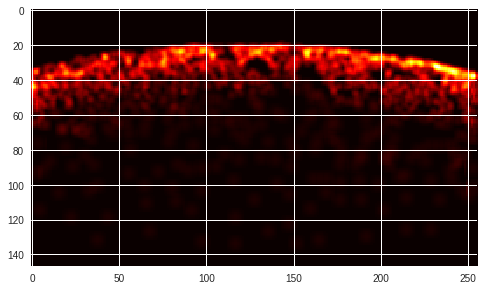

##550 >> avg_loss:68.6884995	  GT:36.5537834	 predict:202.3766174


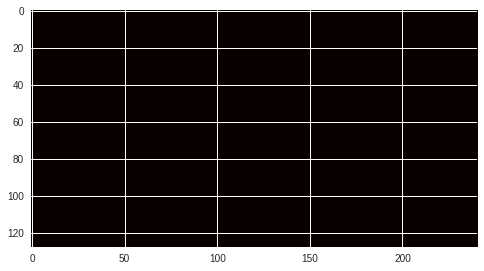

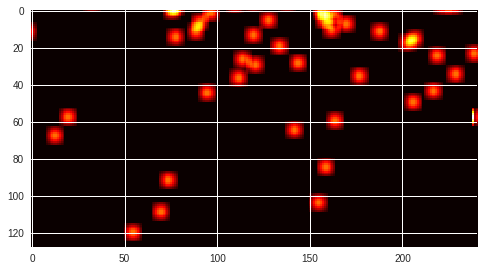

##575 >> avg_loss:23.0765476	  GT:30.9999809	 predict:355.5753479


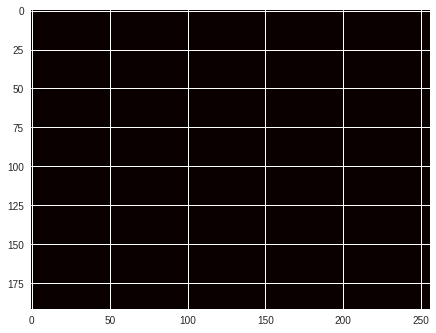

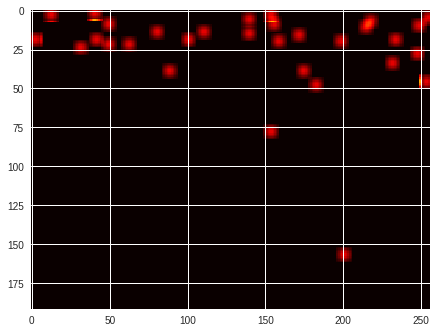

##600 >> avg_loss:64.0237274	  GT:89.4456635	 predict:158.9660645


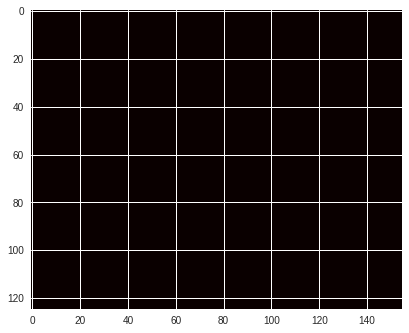

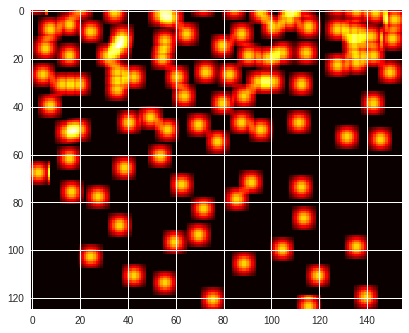

##625 >> avg_loss:18.3360291	  GT:4.1219764	 predict:75.0856552


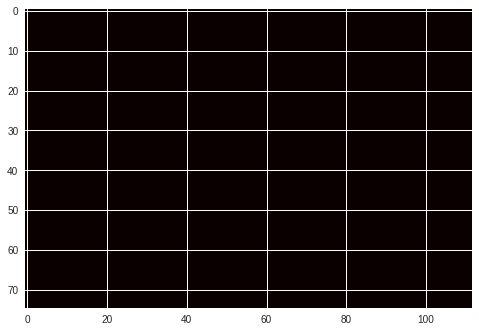

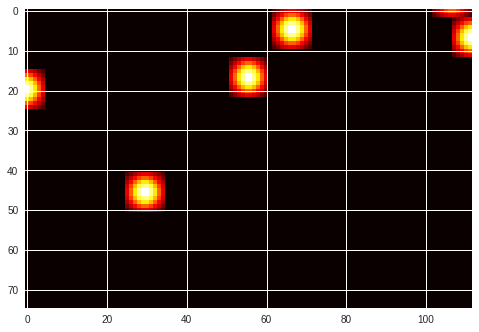

##650 >> avg_loss:8.2372160	  GT:141.7321167	 predict:74.2526474


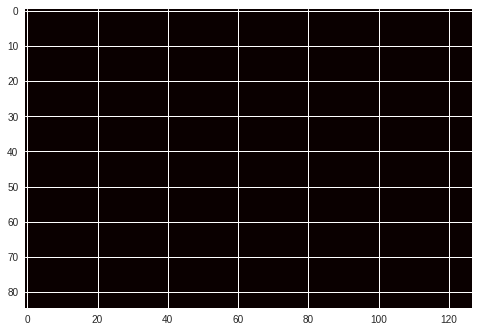

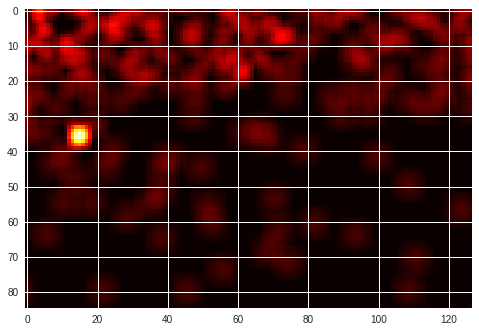

##675 >> avg_loss:18.2046413	  GT:157.0000305	 predict:352.5289917


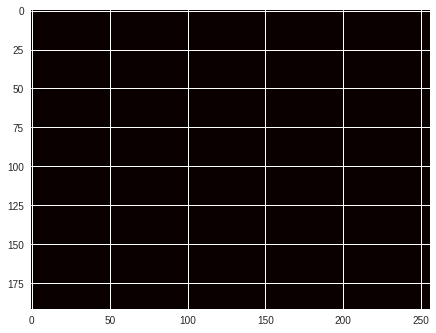

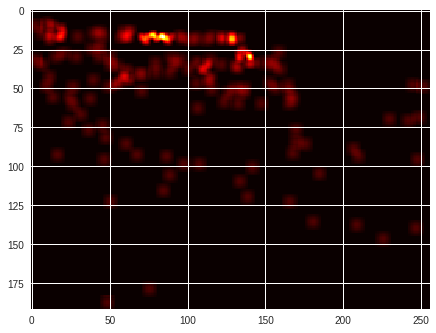

##700 >> avg_loss:72.7007599	  GT:89.1494675	 predict:195.7612915


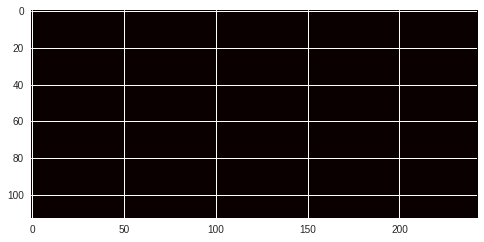

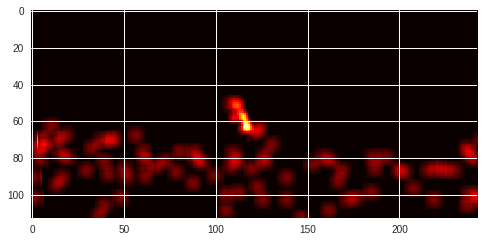

##725 >> avg_loss:56.4566116	  GT:411.0000000	 predict:237.2889862


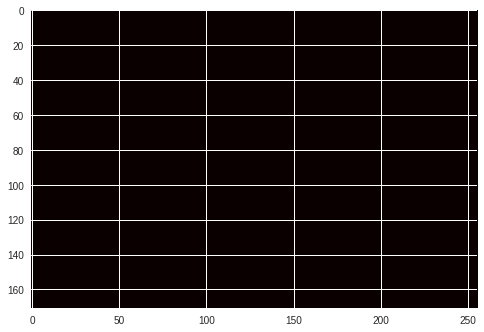

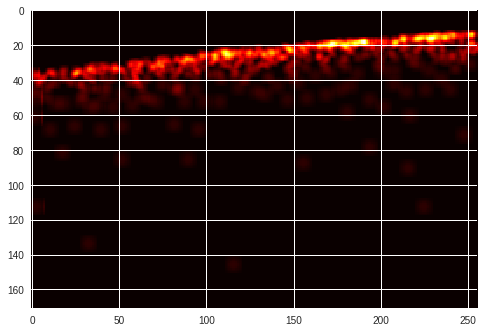

##750 >> avg_loss:5.1313486	  GT:3.9999998	 predict:51.2092323


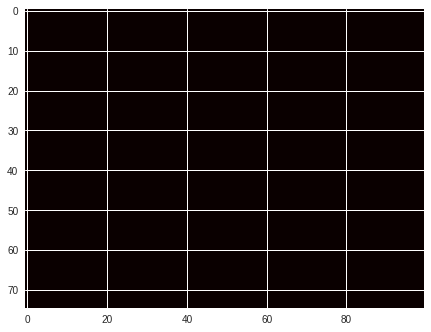

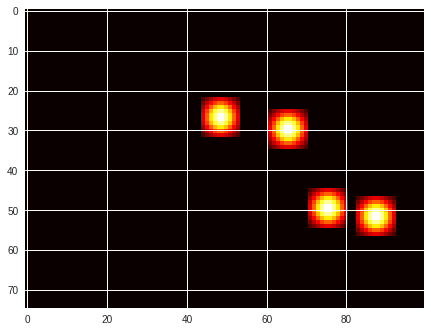

##775 >> avg_loss:250.3816528	  GT:227.9999695	 predict:302.5515442


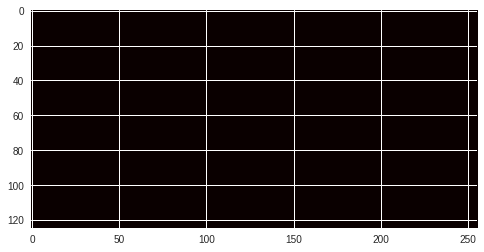

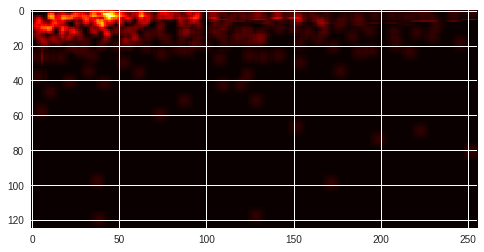

##800 >> avg_loss:153.9601593	  GT:501.7272034	 predict:217.1455078


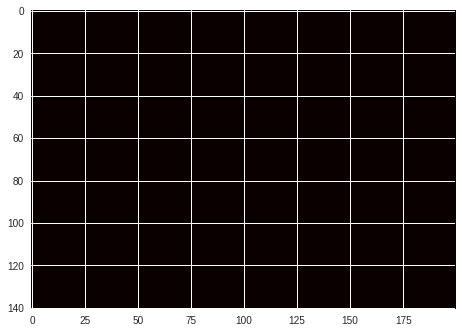

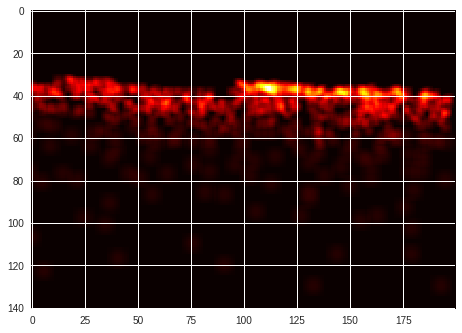

##825 >> avg_loss:25.6582050	  GT:189.8303833	 predict:146.6386566


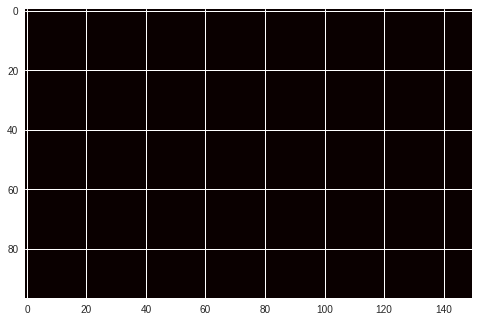

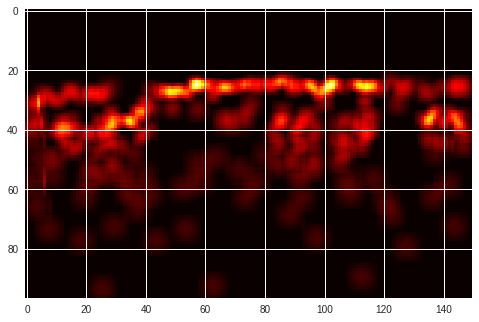

##850 >> avg_loss:56.4394760	  GT:44.9999886	 predict:311.7915039


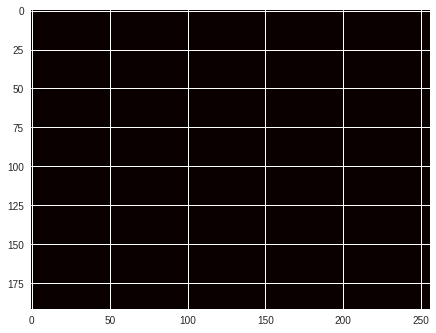

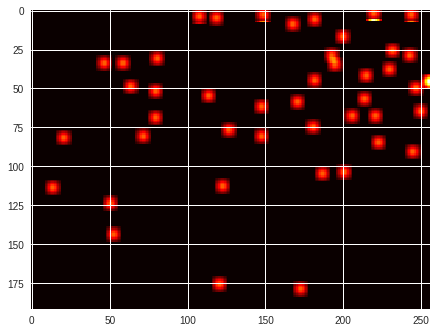

##875 >> avg_loss:27.1651039	  GT:6.0485110	 predict:127.4341354


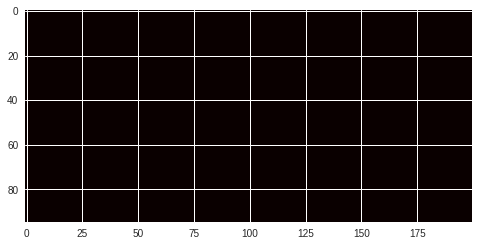

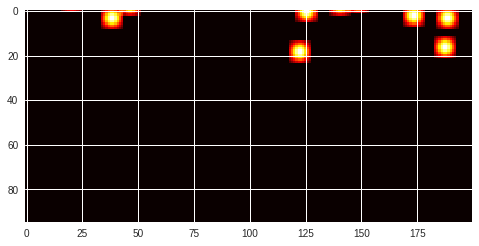

##900 >> avg_loss:4.0964680	  GT:0.0000000	 predict:78.7621307


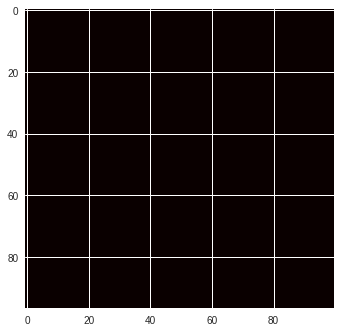

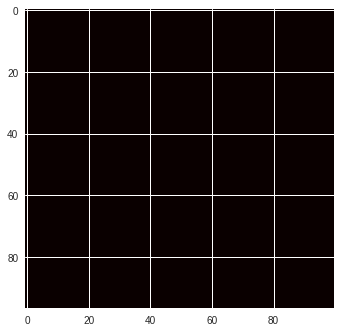

##925 >> avg_loss:518.1204834	  GT:162.3629150	 predict:240.5968781


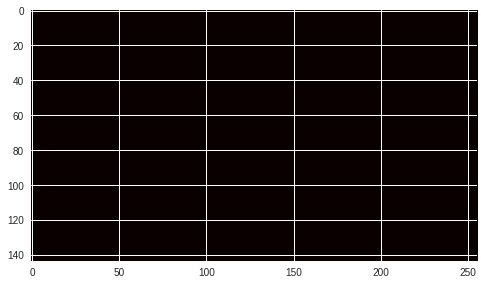

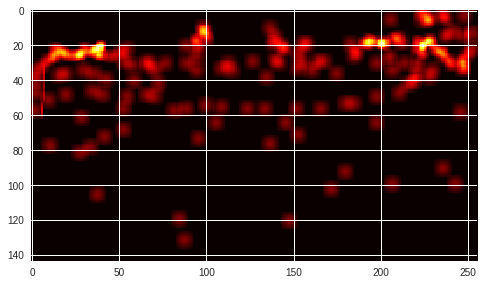

##950 >> avg_loss:34.8853798	  GT:165.0000763	 predict:238.9151001


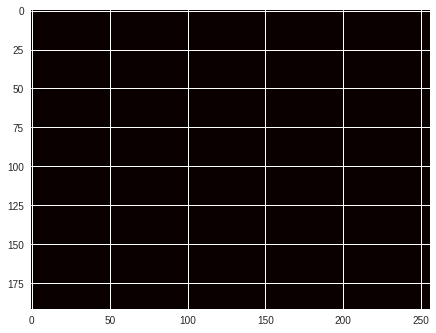

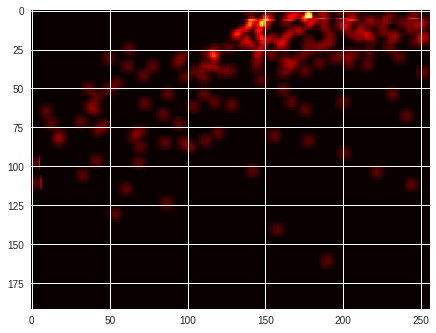

##975 >> avg_loss:13.2041969	  GT:29.1920109	 predict:75.4918823


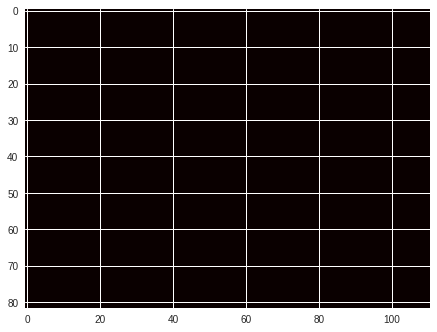

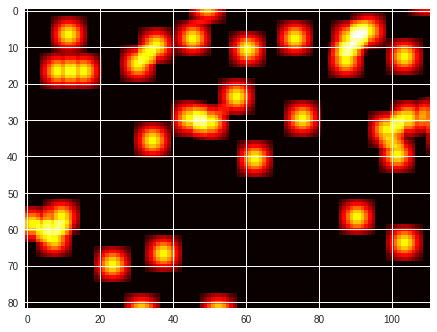

##1000 >> avg_loss:745.0087280	  GT:2143.0009766	 predict:347.0547485


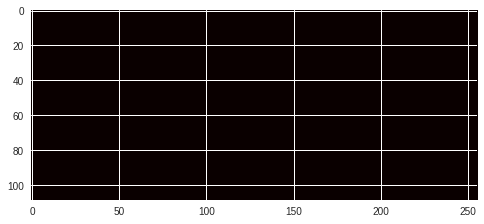

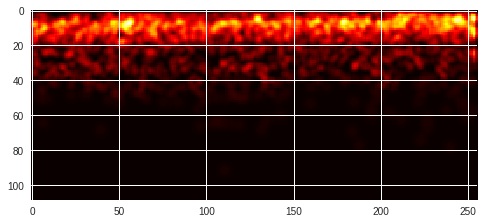

##1025 >> avg_loss:15.8951731	  GT:40.1886940	 predict:191.8982086


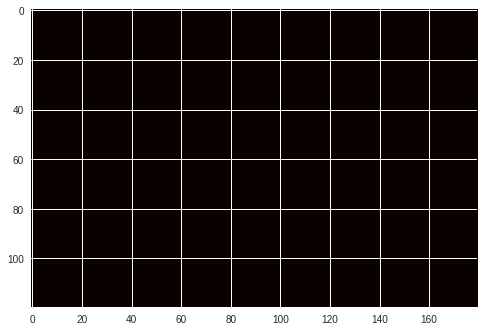

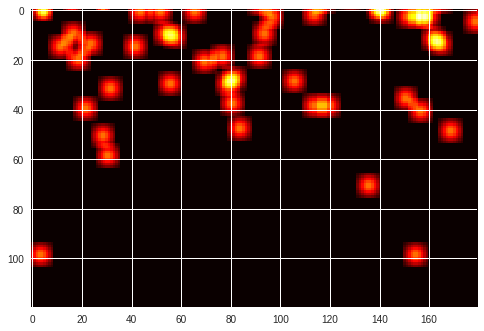

##1050 >> avg_loss:116.1752625	  GT:19.9103737	 predict:219.0165253


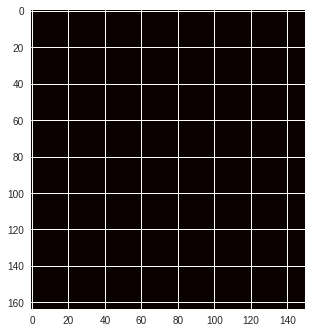

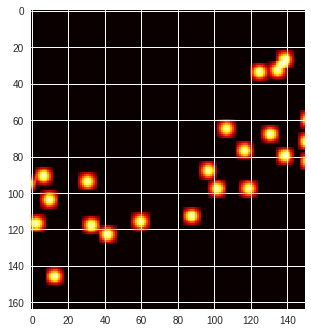

##1075 >> avg_loss:224.1059723	  GT:4.2257013	 predict:150.7674103


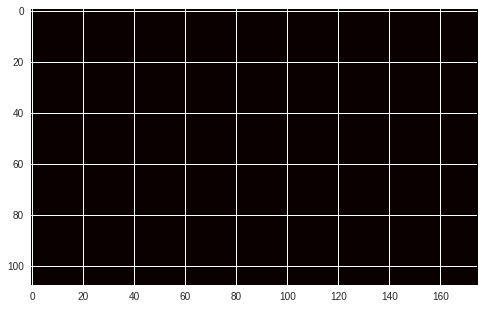

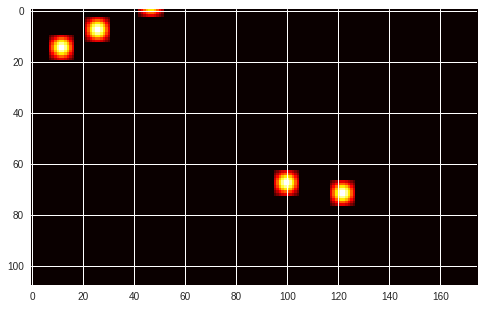

##1100 >> avg_loss:31.5194111	  GT:108.0000534	 predict:286.2577820


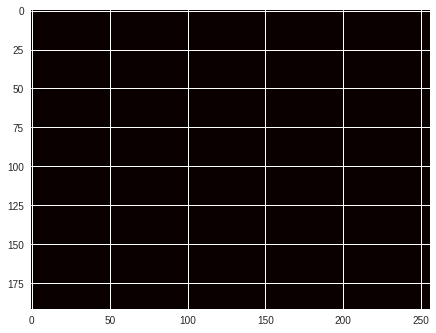

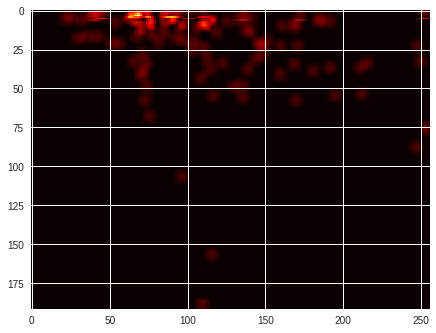

##1125 >> avg_loss:21.6258793	  GT:13.4266233	 predict:184.4893494


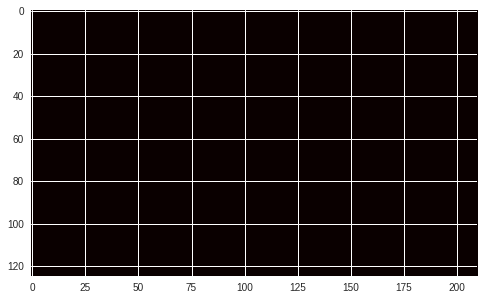

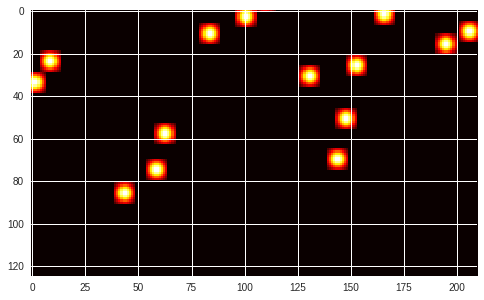

##1150 >> avg_loss:65.8543472	  GT:759.9998169	 predict:267.9504700


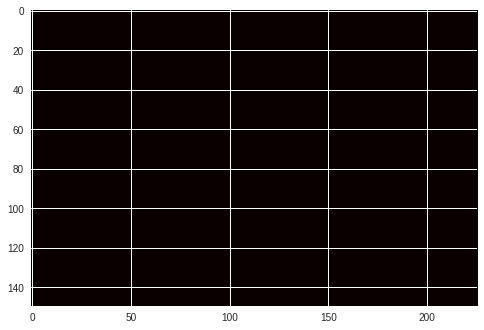

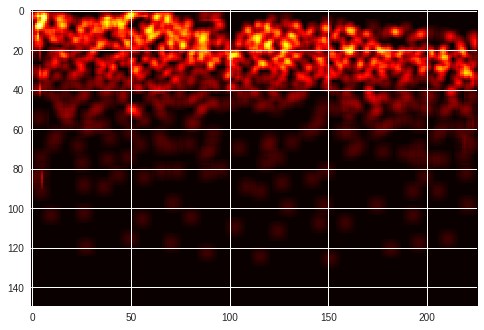

##1175 >> avg_loss:29.9665794	  GT:15.0000048	 predict:360.3366394


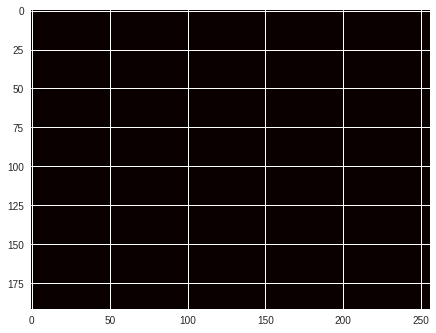

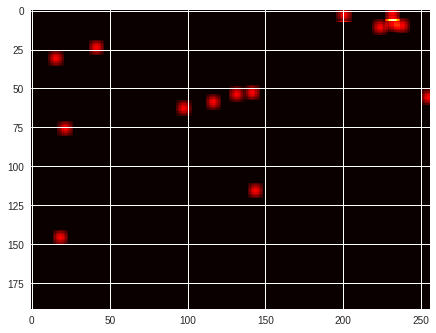

##1200 >> avg_loss:50.1802521	  GT:344.0000000	 predict:384.4681396


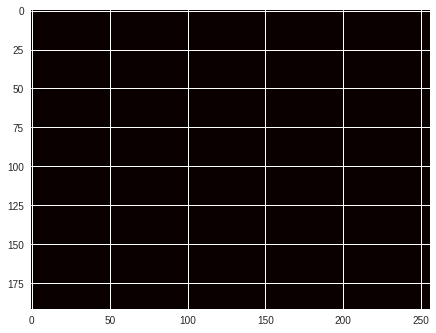

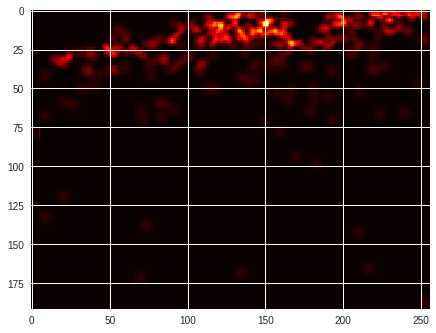

##1225 >> avg_loss:209.8106384	  GT:820.0000000	 predict:354.6590576


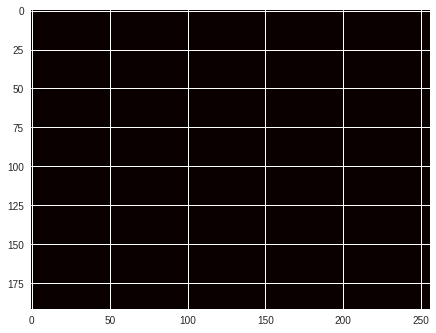

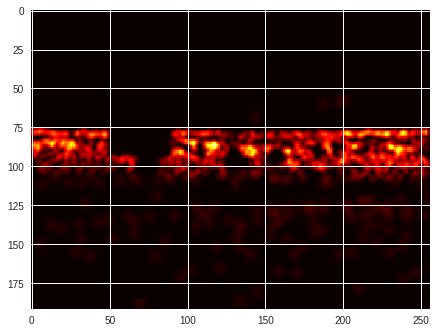

##1250 >> avg_loss:135.1187286	  GT:158.3552551	 predict:269.1833496


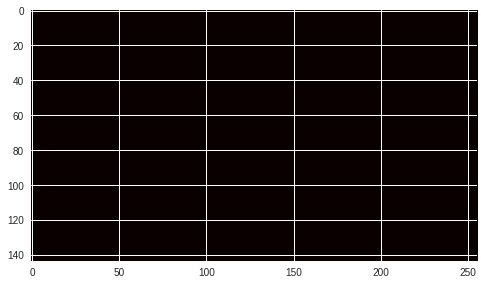

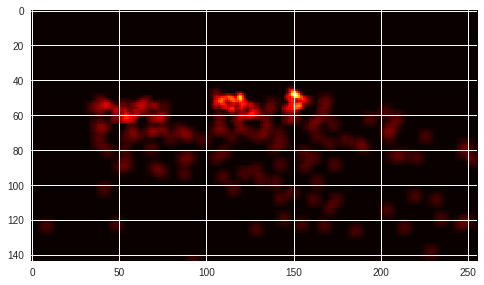

##1275 >> avg_loss:116.6619568	  GT:798.9996948	 predict:284.4377136


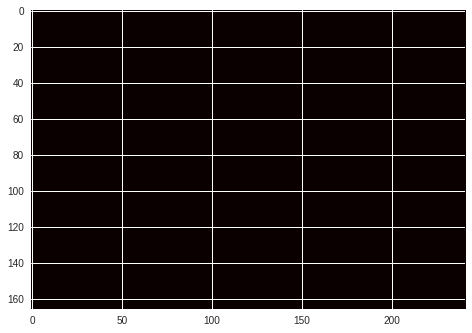

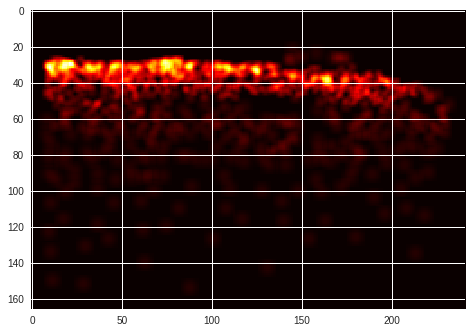

##1300 >> avg_loss:30.1139946	  GT:84.9999771	 predict:320.5984802


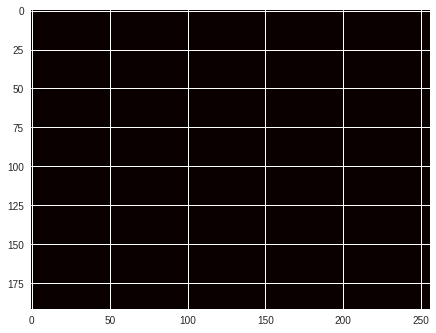

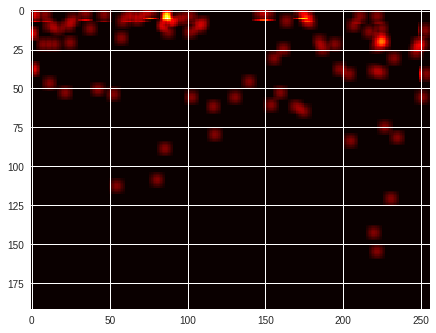

##1325 >> avg_loss:64.1449890	  GT:421.3302917	 predict:171.1679230


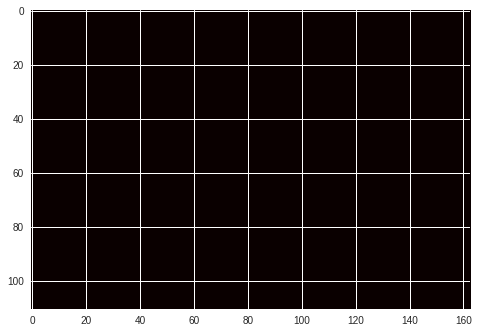

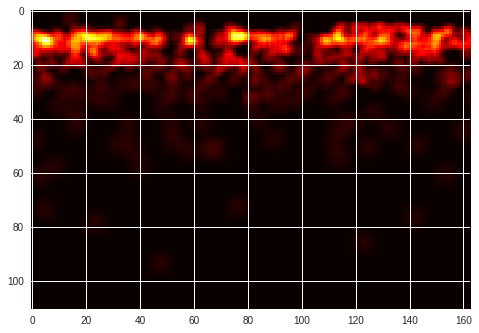

##1350 >> avg_loss:25.6530113	  GT:166.0000000	 predict:75.4812012


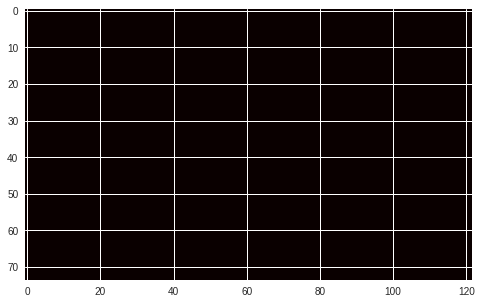

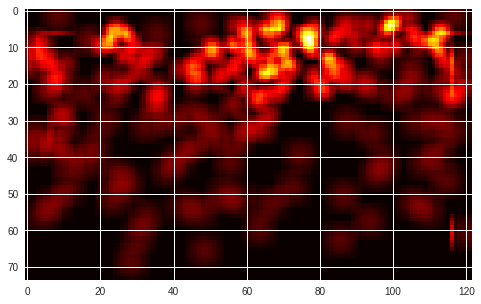

##1375 >> avg_loss:353.5990601	  GT:187.9999847	 predict:171.3217621


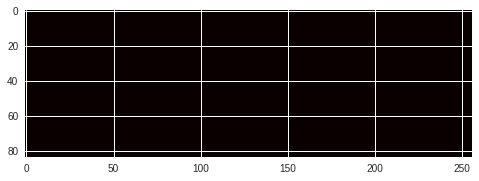

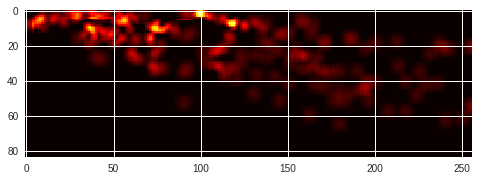

##1400 >> avg_loss:7.3598008	  GT:174.9999847	 predict:97.0826187


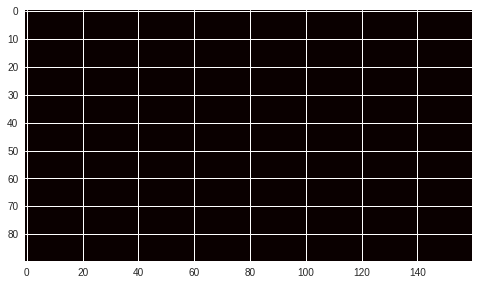

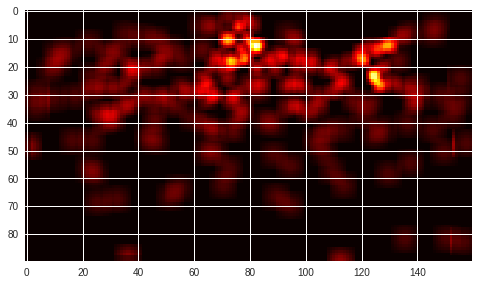

##1425 >> avg_loss:68.9346390	  GT:6.0307264	 predict:142.2753143


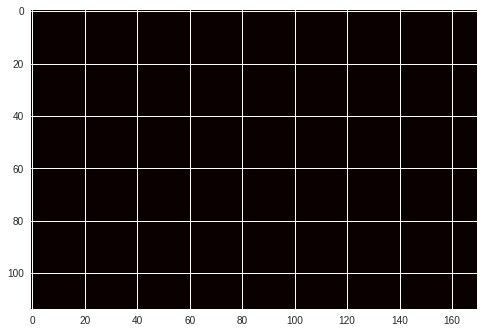

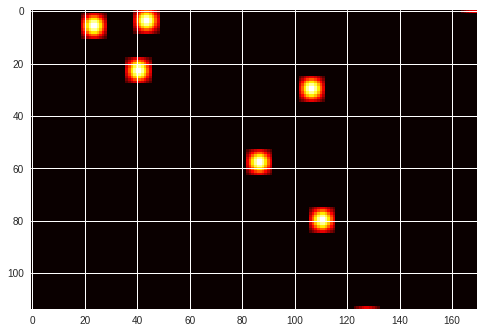

##1450 >> avg_loss:15.2298431	  GT:104.0000610	 predict:316.9663391


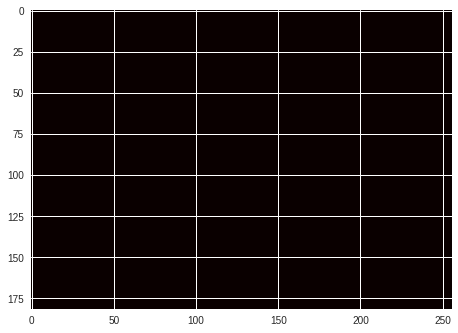

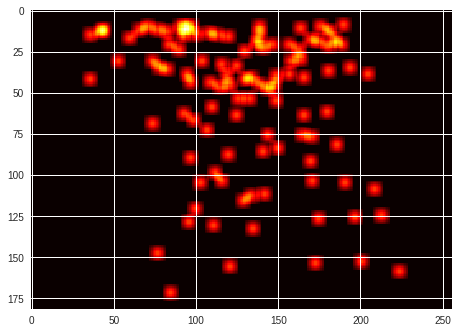

##1475 >> avg_loss:18.7881966	  GT:136.2385254	 predict:91.6340027


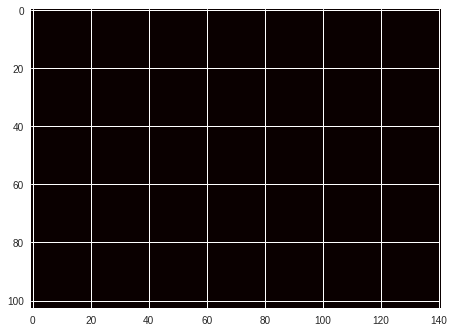

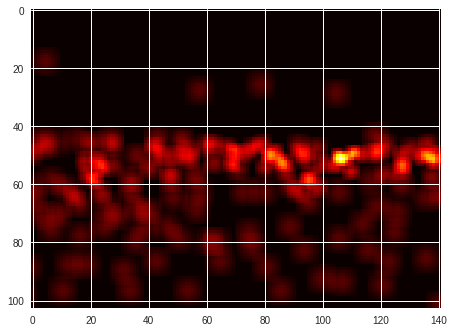

##1500 >> avg_loss:54.5017776	  GT:129.7936401	 predict:271.9956360


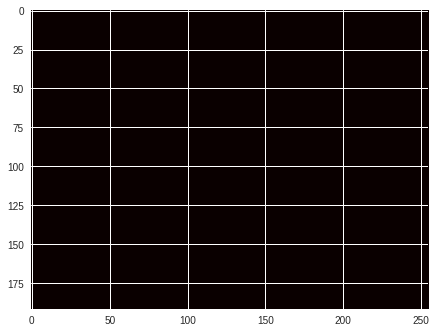

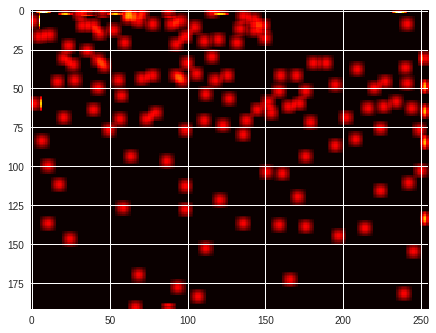

##1525 >> avg_loss:41.8275642	  GT:4.8552403	 predict:80.4942398


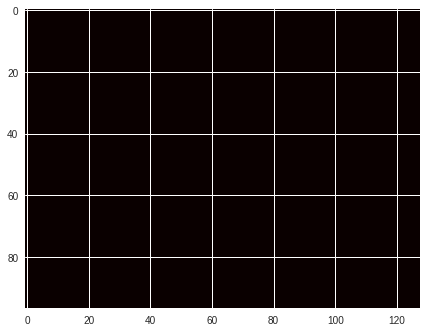

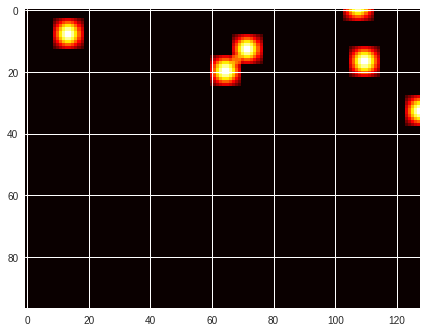

##1550 >> avg_loss:113.2980042	  GT:41.4582176	 predict:256.2561035


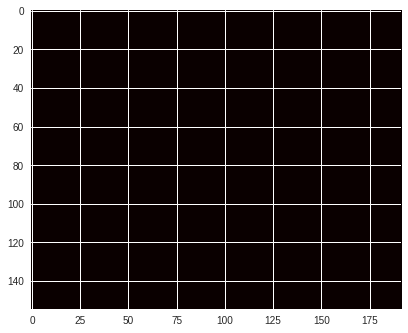

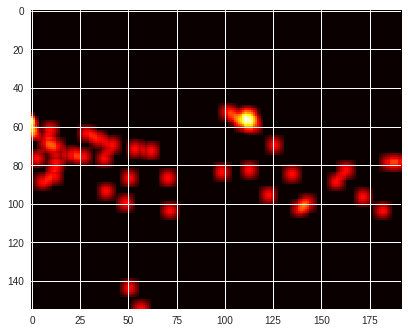

##1575 >> avg_loss:37.5859795	  GT:27.9999886	 predict:356.3202515


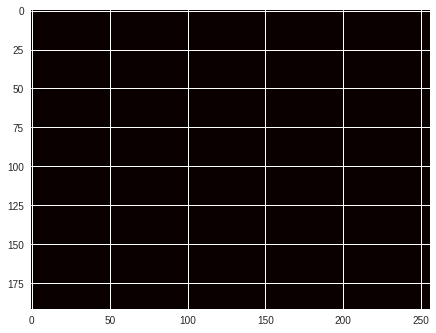

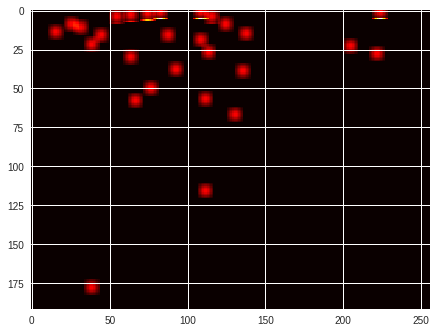

##1600 >> avg_loss:10.2847271	  GT:281.0773926	 predict:168.2128754


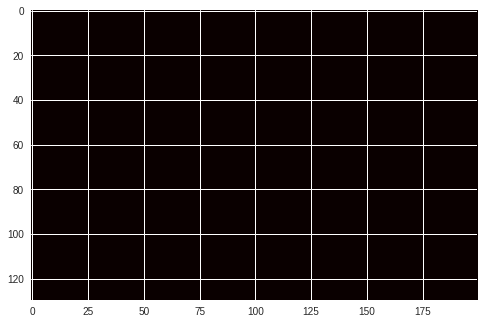

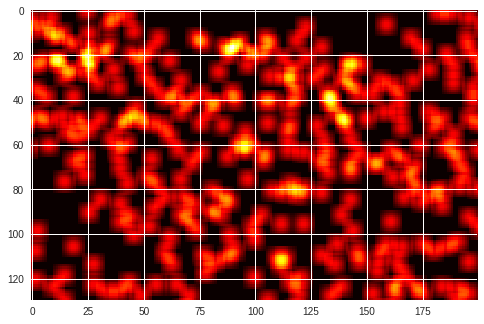

##1625 >> avg_loss:7.1077805	  GT:201.6058502	 predict:163.5185394


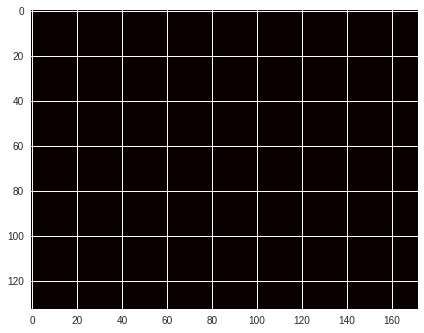

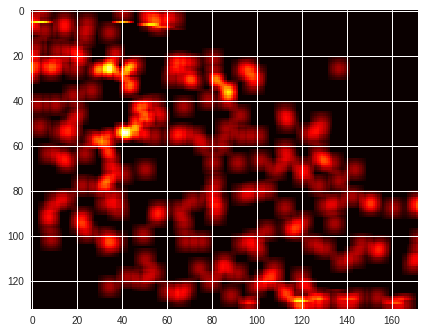

##1650 >> avg_loss:29.1163425	  GT:297.0000916	 predict:62.4916306


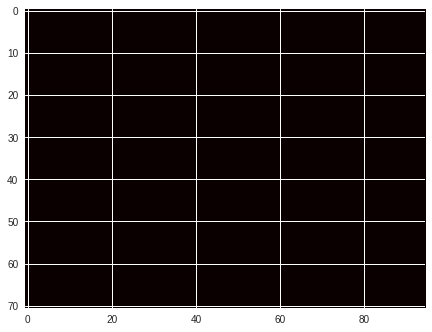

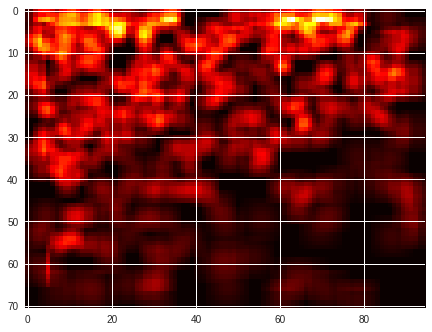

##1675 >> avg_loss:389.8113708	  GT:1545.9995117	 predict:365.0078735


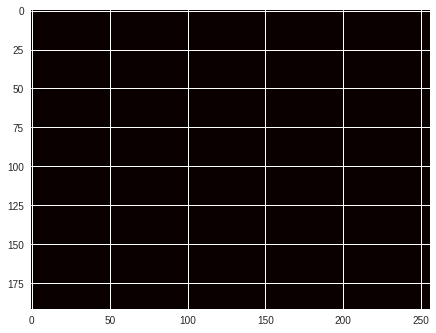

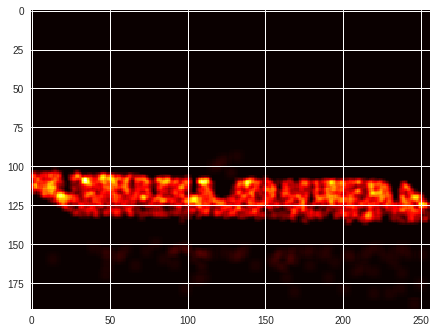

##1700 >> avg_loss:62.6723938	  GT:77.4442368	 predict:354.6326599


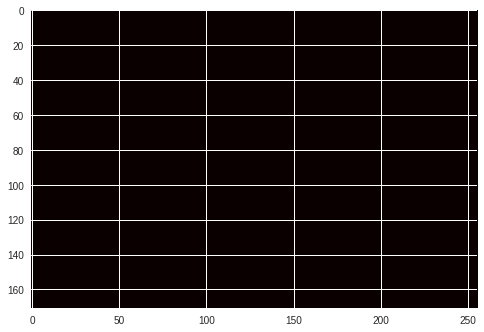

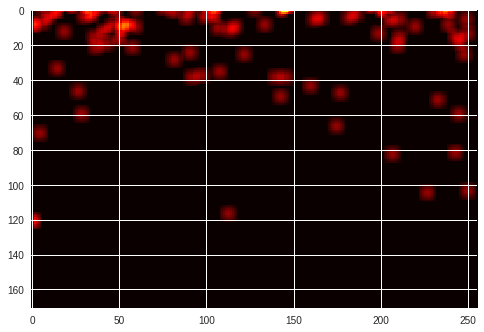

##1725 >> avg_loss:16.7993851	  GT:68.8930817	 predict:107.8940811


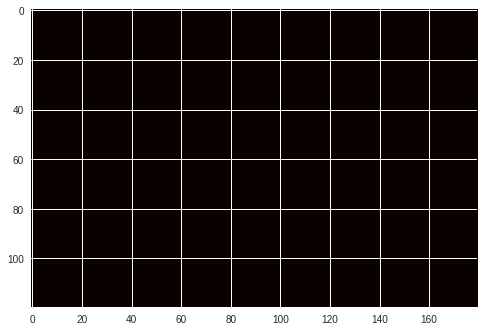

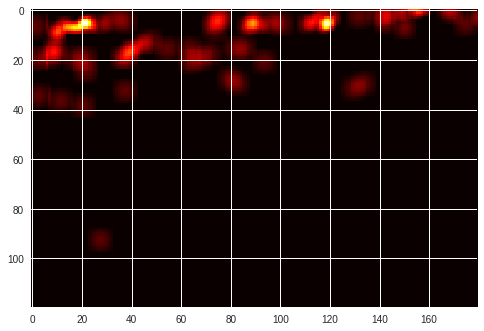

##1750 >> avg_loss:3.9115746	  GT:74.0000305	 predict:102.0041504


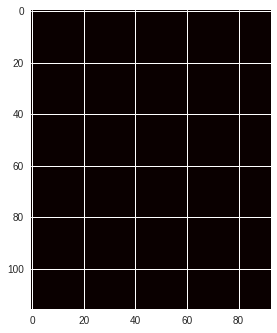

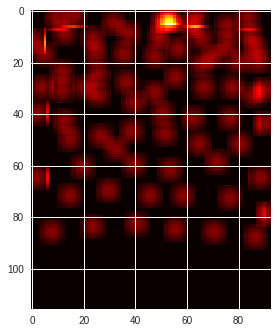

##1775 >> avg_loss:89.3189545	  GT:26.3437042	 predict:177.0643158


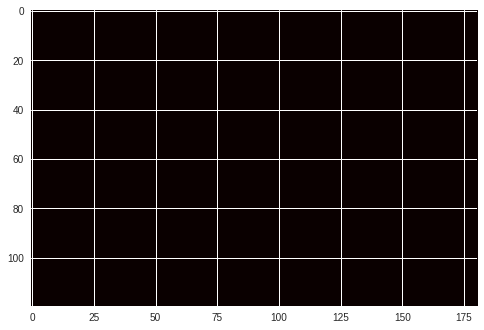

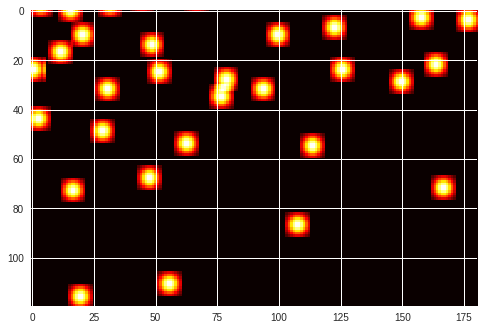

##1800 >> avg_loss:682.6123047	  GT:544.9998169	 predict:409.1561890


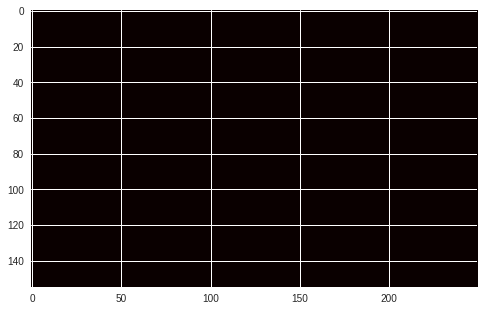

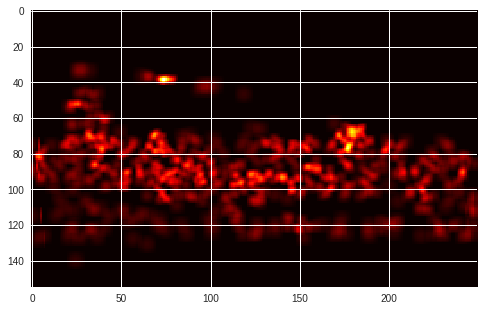

##1825 >> avg_loss:6.9682217	  GT:5.6299338	 predict:53.9729843


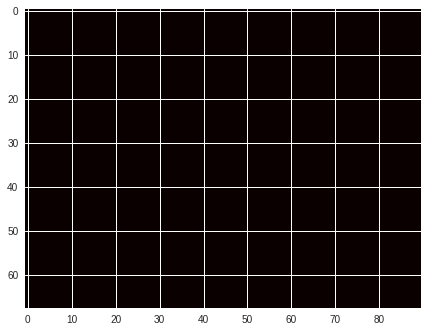

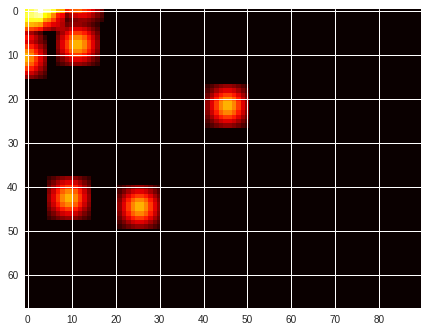

##1850 >> avg_loss:44.6396866	  GT:23.8574677	 predict:76.6529999


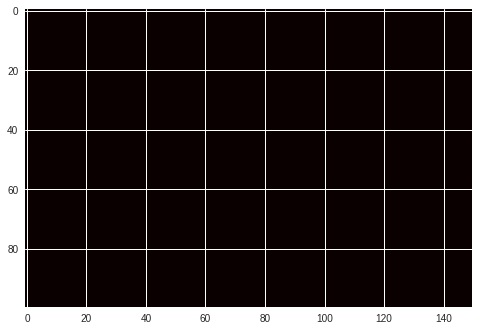

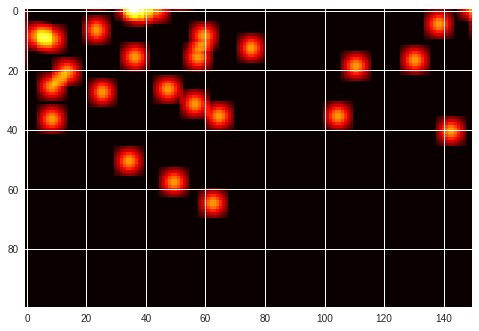

##1875 >> avg_loss:52.7200432	  GT:37.2152176	 predict:314.4465942


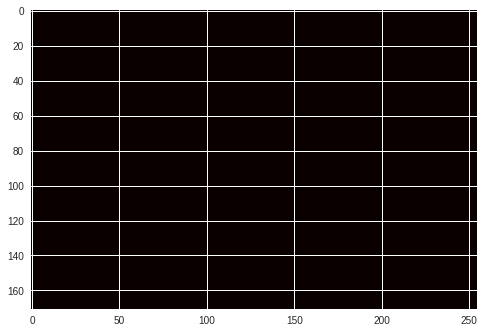

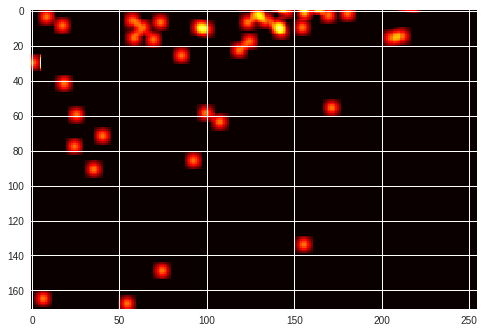

##1900 >> avg_loss:65.5810242	  GT:2.4999998	 predict:192.0514984


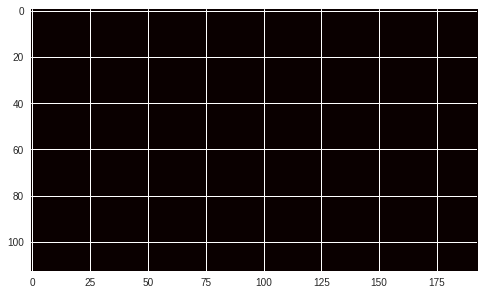

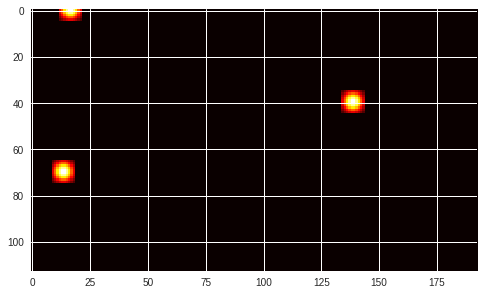

##1925 >> avg_loss:74.3167725	  GT:3.9523456	 predict:132.8531036


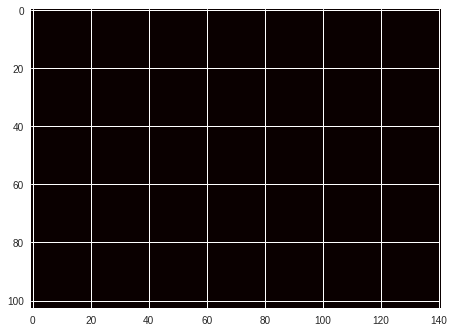

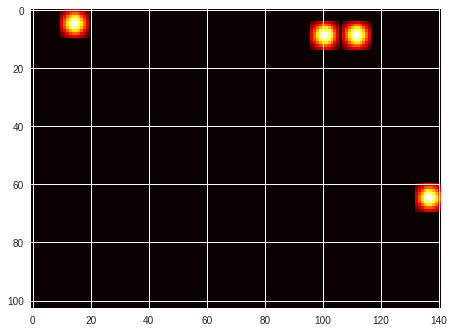

##1950 >> avg_loss:82.7619324	  GT:21.0182934	 predict:77.8216171


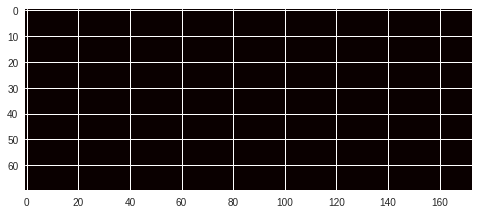

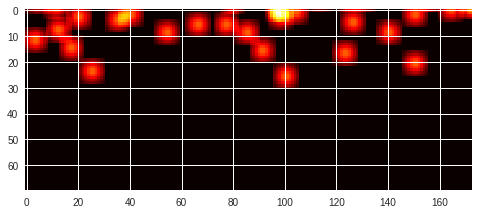

##1975 >> avg_loss:167.3700256	  GT:377.9999695	 predict:50.0228577


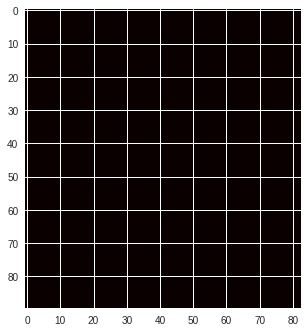

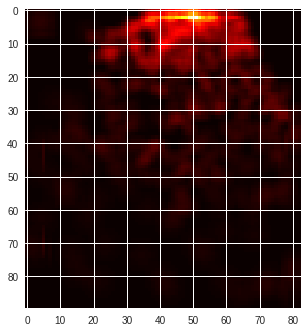

##2000 >> avg_loss:58.0351906	  GT:65.8673477	 predict:183.7404480


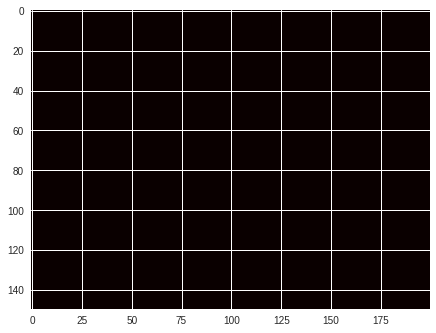

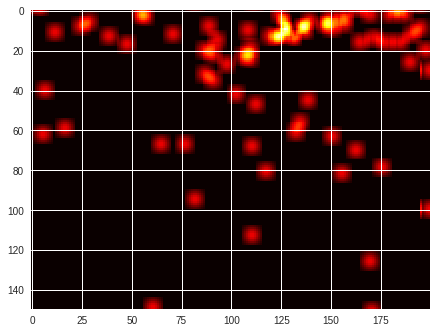

##2025 >> avg_loss:78.0127945	  GT:464.9696960	 predict:377.9922485


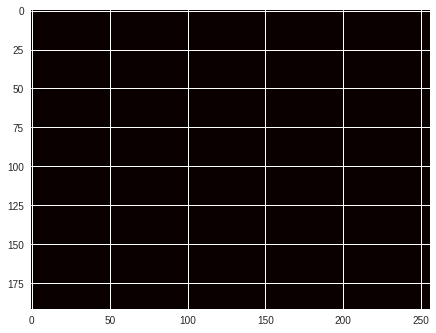

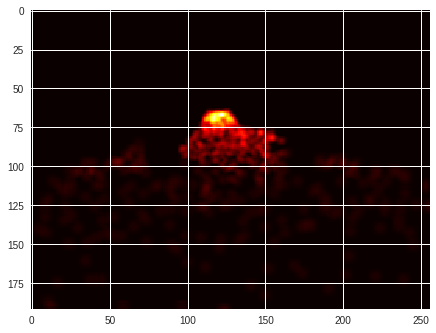

##2050 >> avg_loss:73.2096558	  GT:37.9999847	 predict:353.2003174


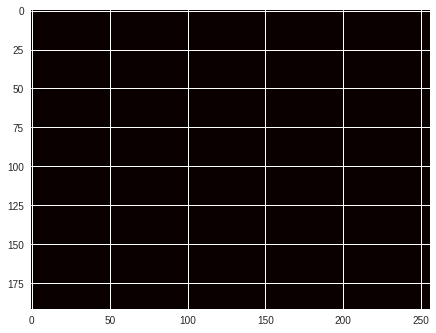

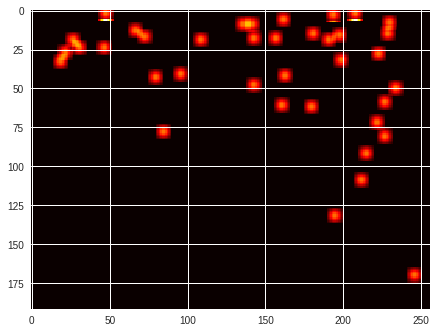

##2075 >> avg_loss:146.7323761	  GT:47.4491768	 predict:402.7344055


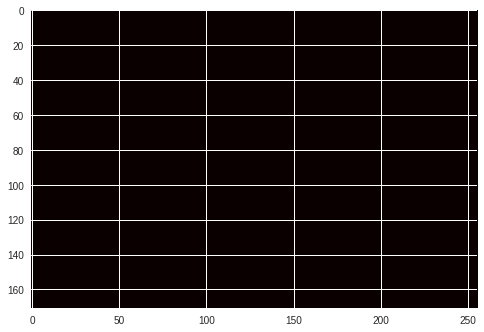

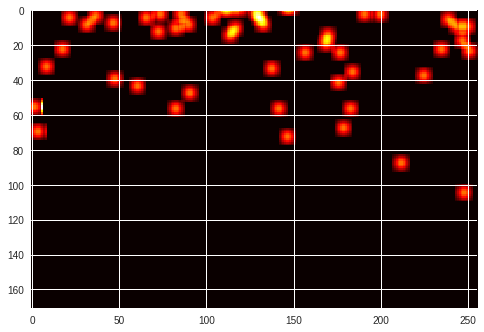

##2100 >> avg_loss:11.8556328	  GT:146.3659973	 predict:82.5420074


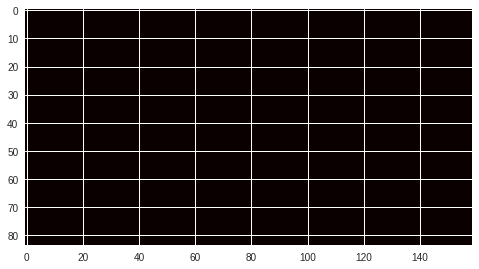

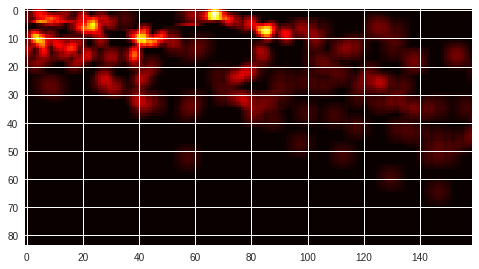

##2125 >> avg_loss:23.5219803	  GT:140.3123932	 predict:191.7354431


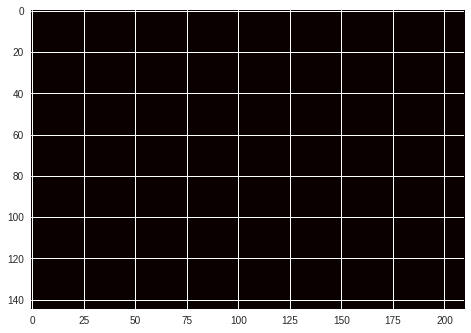

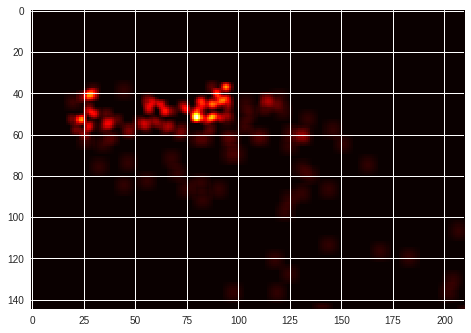

##2150 >> avg_loss:46.6473732	  GT:295.1113281	 predict:300.4895325


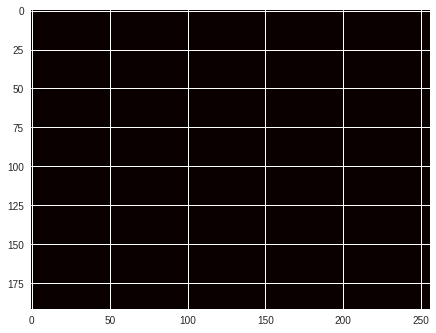

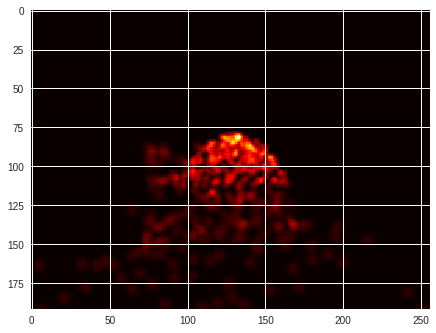

##2175 >> avg_loss:10.6029263	  GT:0.0000000	 predict:93.3134155


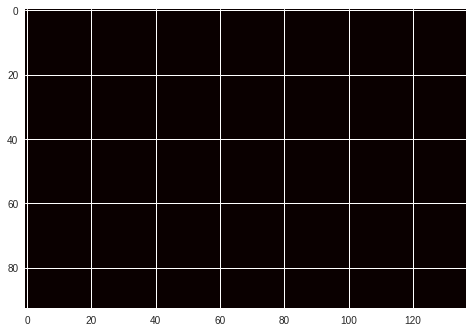

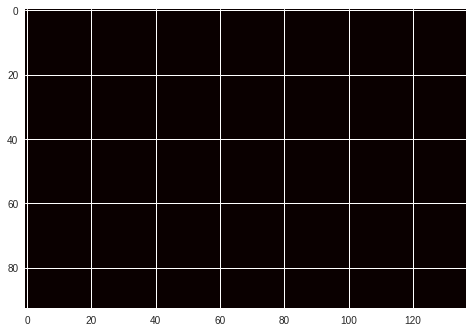

##2200 >> avg_loss:92.2702484	  GT:71.1865692	 predict:100.6027756


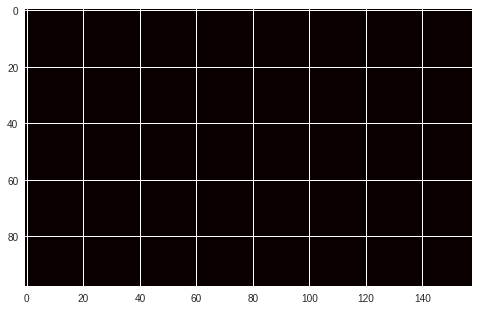

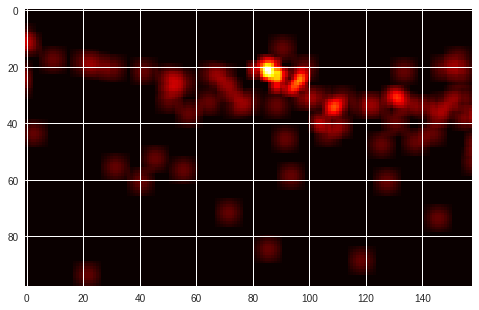

##2225 >> avg_loss:95.8118896	  GT:1619.9995117	 predict:306.5148315


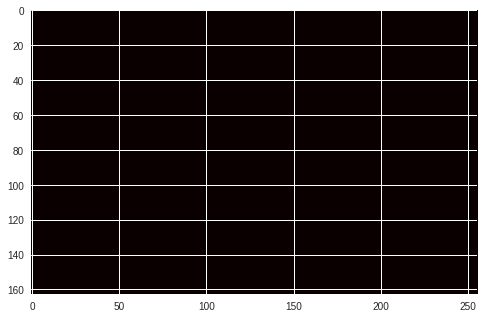

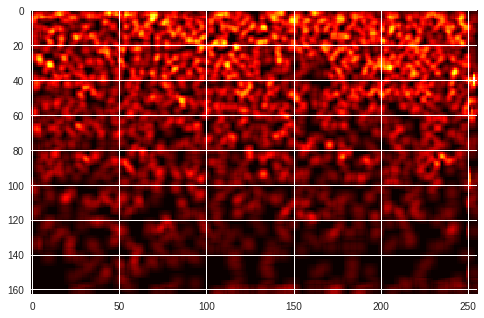

##2250 >> avg_loss:17.6114388	  GT:78.0000000	 predict:353.8338013


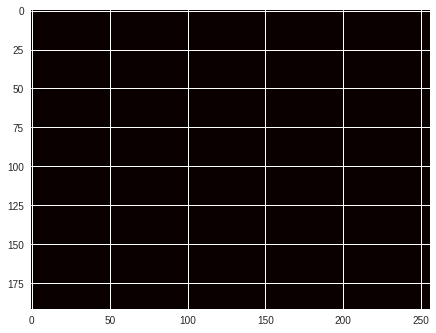

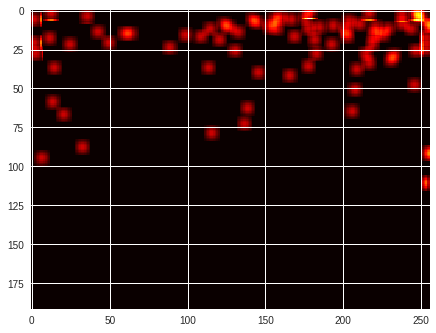

##2275 >> avg_loss:41.7556305	  GT:217.0000458	 predict:314.5242004


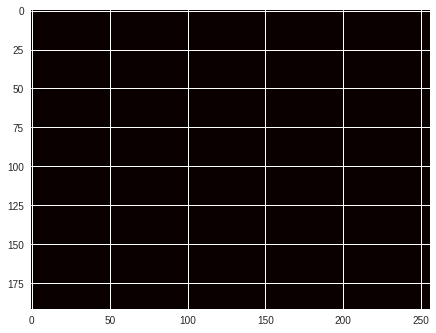

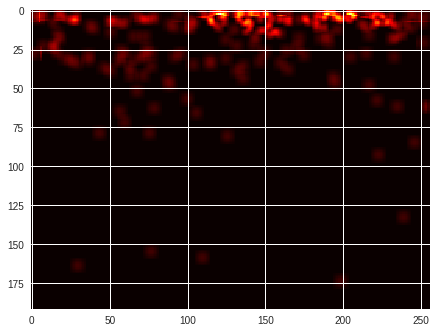

##2300 >> avg_loss:10.8526030	  GT:9.6447630	 predict:190.8773041


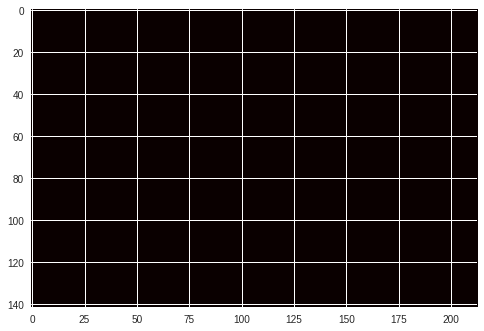

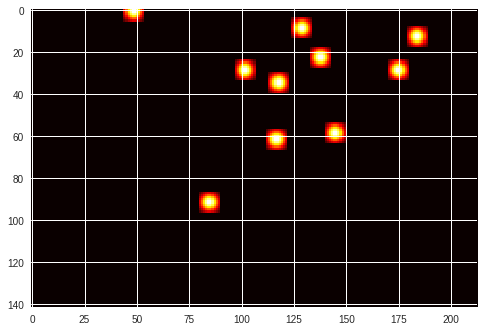

##2325 >> avg_loss:97.6041107	  GT:631.0001221	 predict:111.2466736


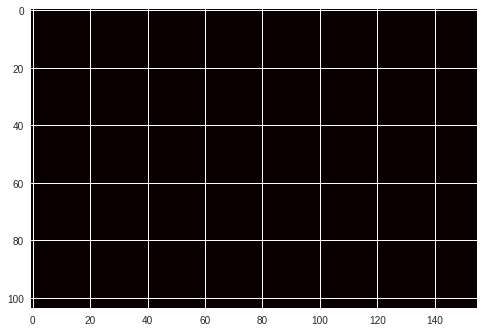

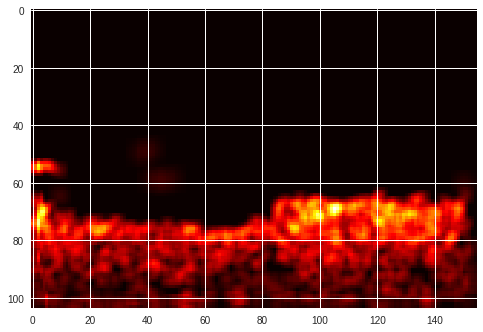

##2350 >> avg_loss:20.8353119	  GT:210.6894073	 predict:277.1018066


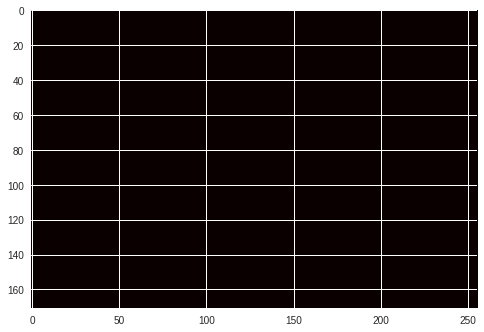

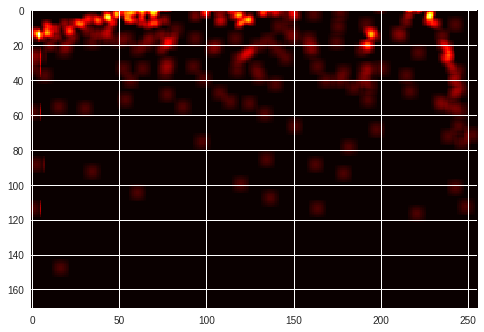

##2375 >> avg_loss:199.7225494	  GT:12.0000010	 predict:241.3944702


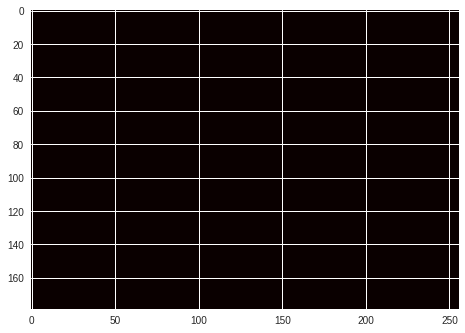

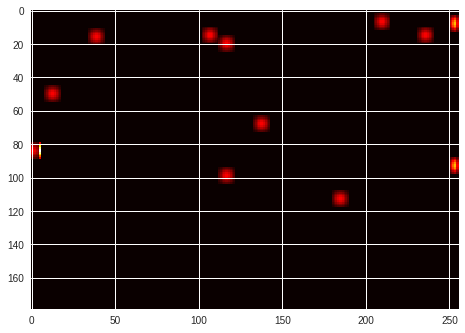

##2400 >> avg_loss:56.6992455	  GT:4.0000000	 predict:101.2967148


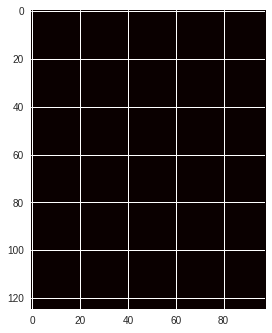

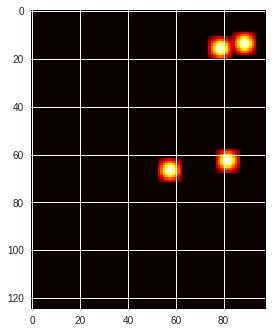

##2425 >> avg_loss:4.1852474	  GT:129.0000000	 predict:107.5615616


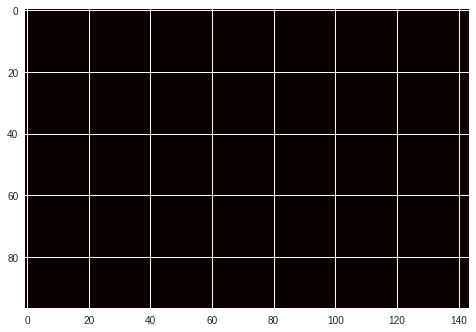

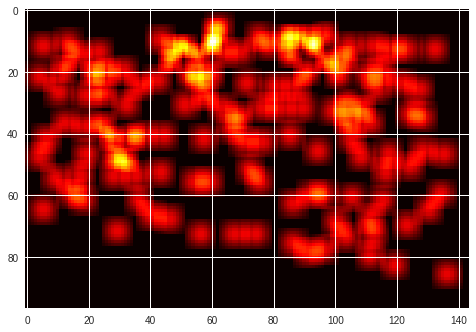

##2450 >> avg_loss:392.4287720	  GT:1285.3869629	 predict:282.1511230


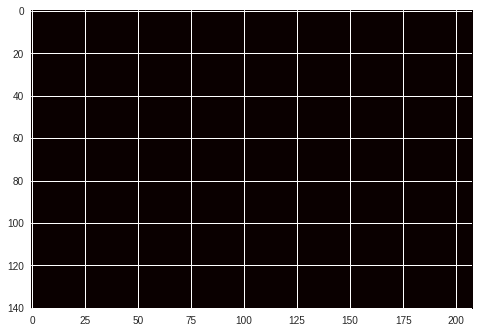

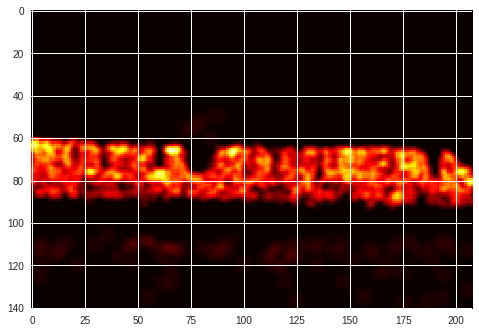

##2475 >> avg_loss:169.1633606	  GT:16.6324806	 predict:143.7395020


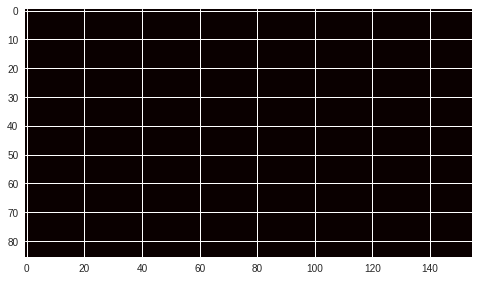

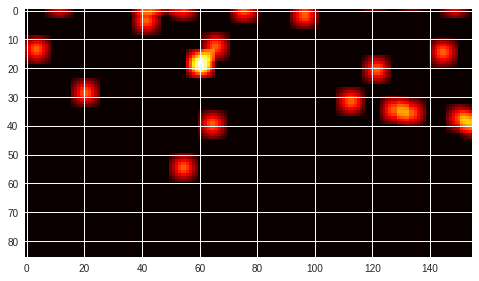

##2500 >> avg_loss:110.2303848	  GT:653.5297241	 predict:161.9796143


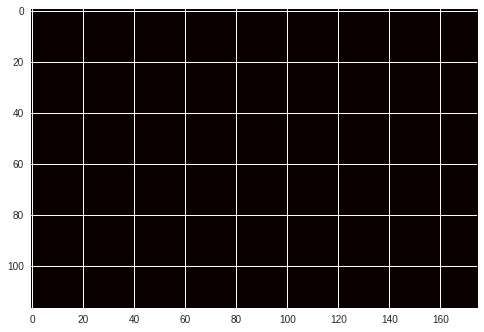

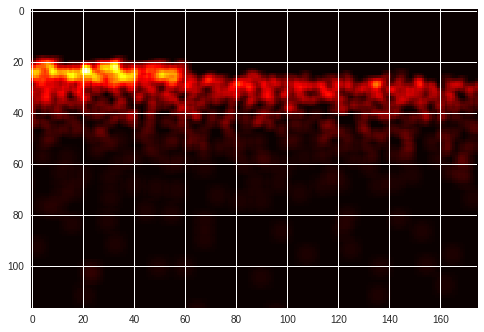

##2525 >> avg_loss:122.5299225	  GT:92.1219788	 predict:259.4375610


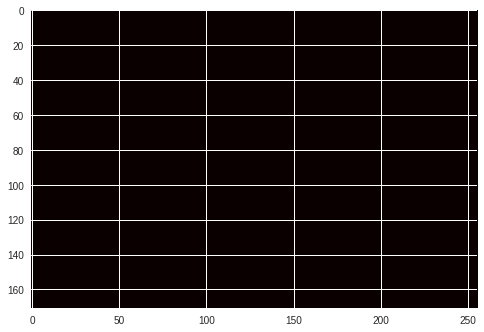

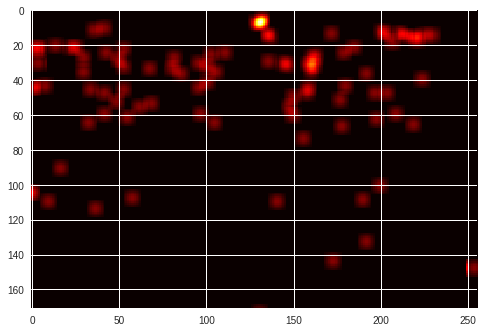

##2550 >> avg_loss:59.8521957	  GT:23.4981976	 predict:78.7269363


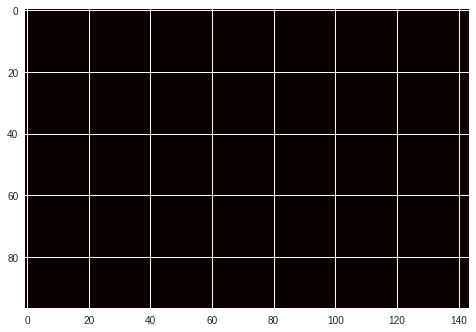

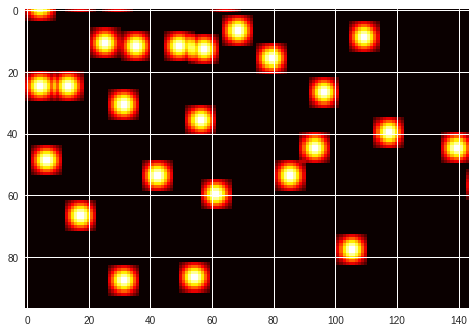

##2575 >> avg_loss:12.4632816	  GT:165.8963165	 predict:295.5493774


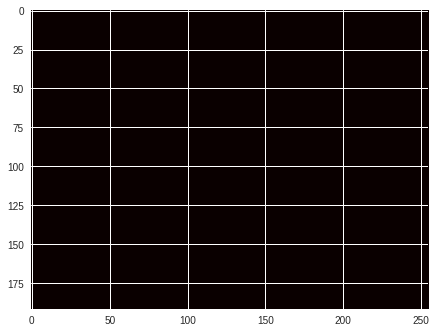

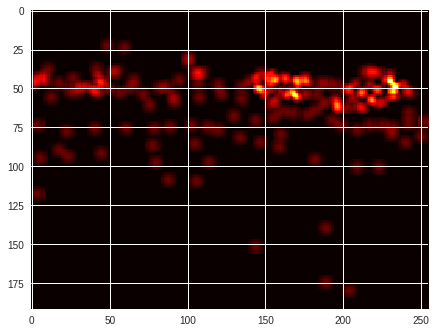

##2600 >> avg_loss:34.2566986	  GT:509.0000305	 predict:268.6032104


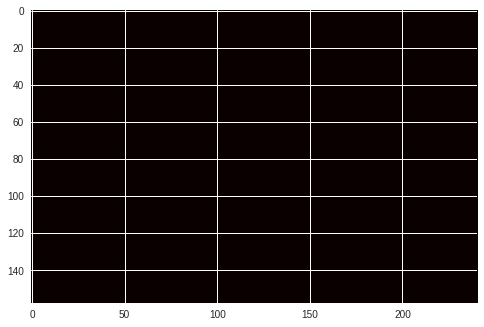

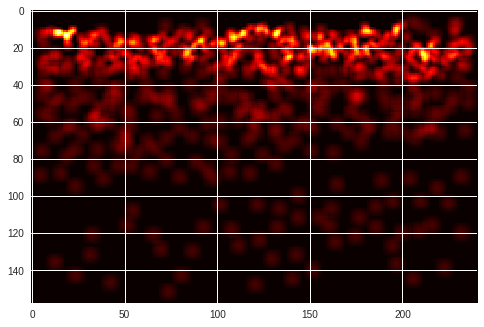

##2625 >> avg_loss:36.2837524	  GT:94.0000076	 predict:370.0938110


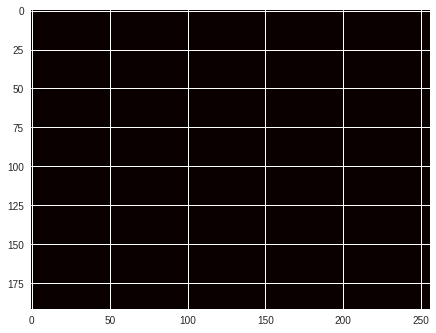

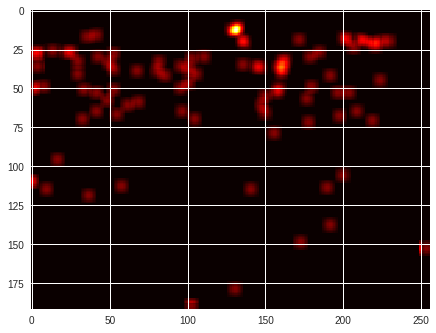

##2650 >> avg_loss:21.9706345	  GT:47.2416534	 predict:145.5742493


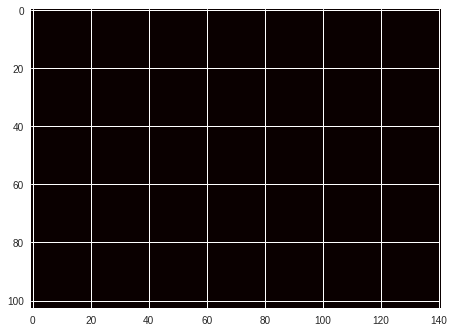

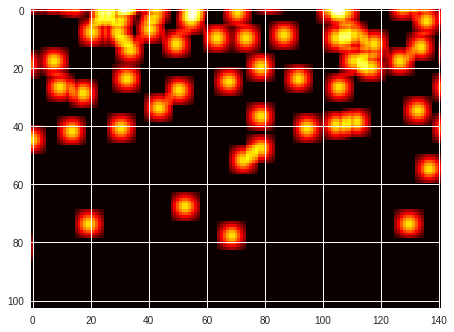

##2675 >> avg_loss:11.3359222	  GT:120.3606415	 predict:279.2004395


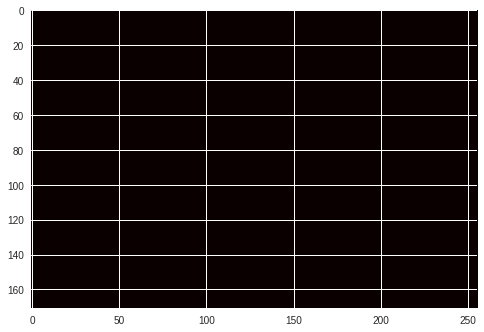

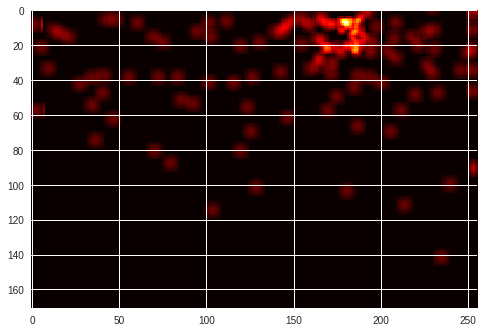

##2700 >> avg_loss:7.8701410	  GT:5.6757526	 predict:110.3164902


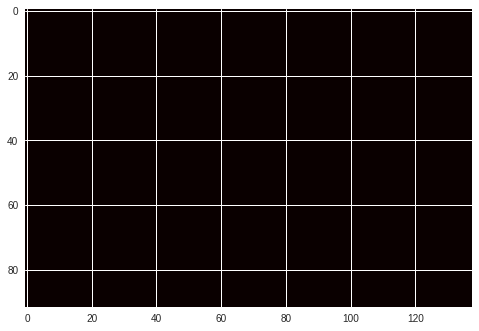

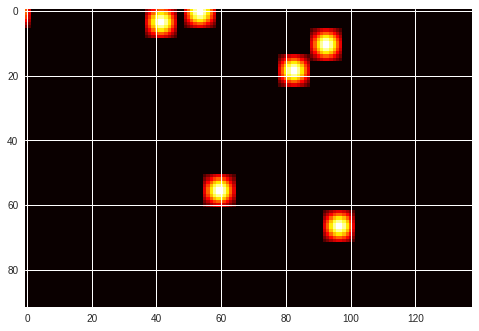

##2725 >> avg_loss:61.8161736	  GT:18.9999962	 predict:337.3147278


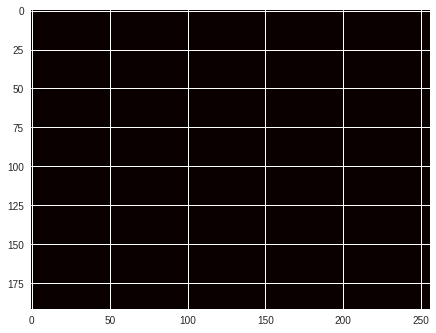

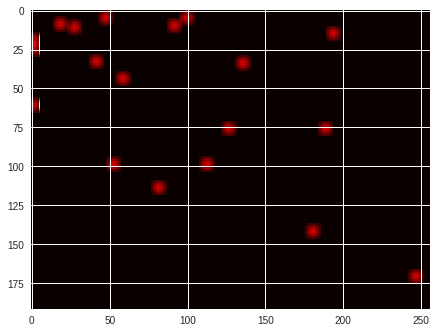

##2750 >> avg_loss:316.2726440	  GT:66.1159973	 predict:405.1585999


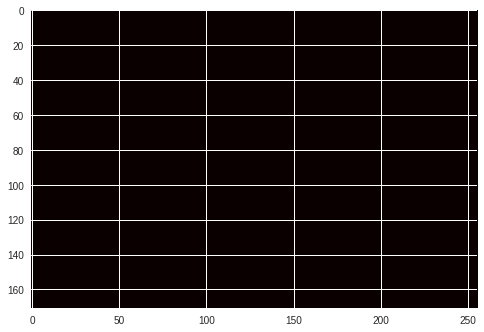

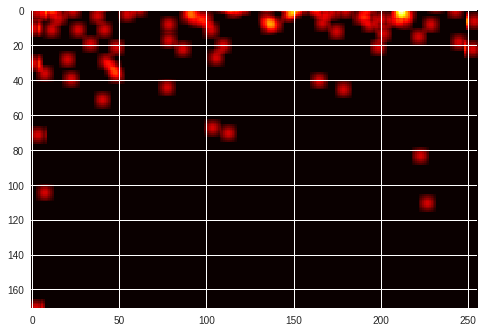

##2775 >> avg_loss:510.7938538	  GT:32.8563766	 predict:325.5054932


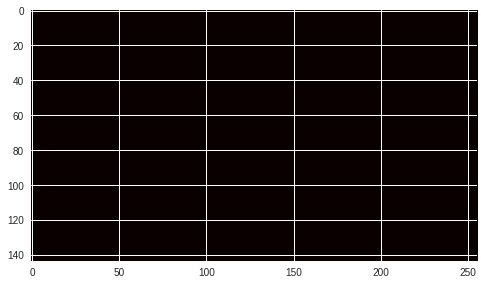

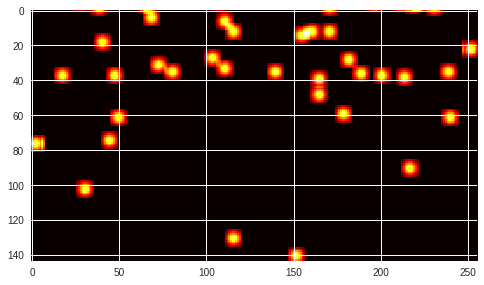

##2800 >> avg_loss:16.0156326	  GT:13.6999798	 predict:224.7189789


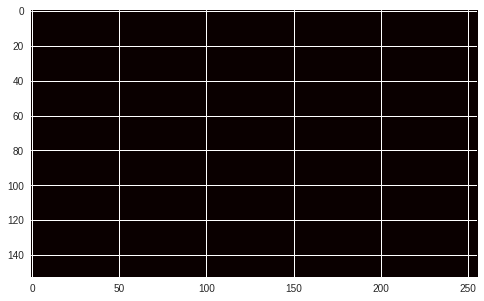

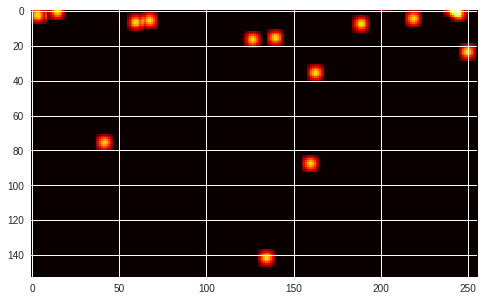

##2825 >> avg_loss:64.2139435	  GT:760.0001221	 predict:280.0308228


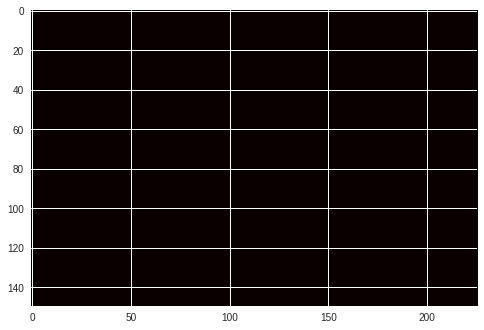

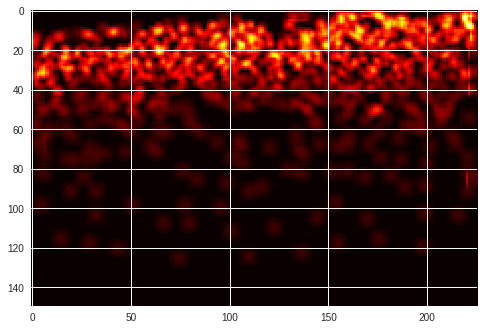

##2850 >> avg_loss:15.8730907	  GT:318.3800964	 predict:138.4216156


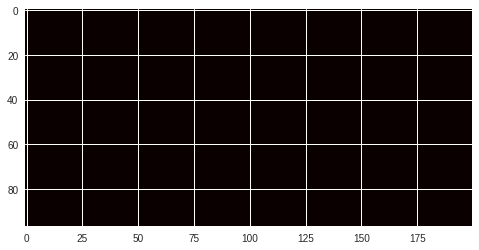

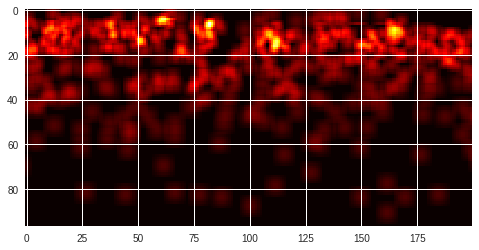

##2875 >> avg_loss:192.3589478	  GT:311.6051025	 predict:283.0891418


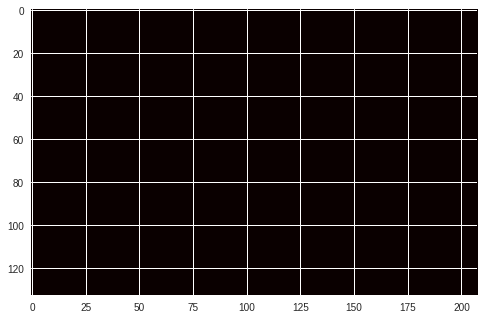

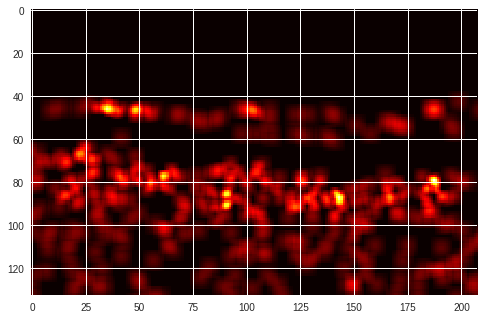

##2900 >> avg_loss:30.4431038	  GT:32.0000000	 predict:319.9273376


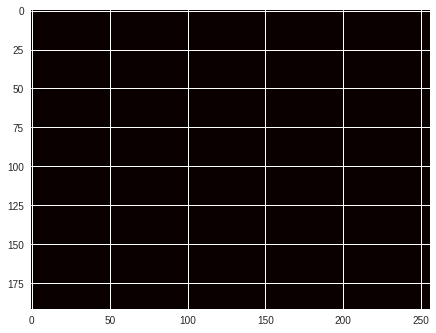

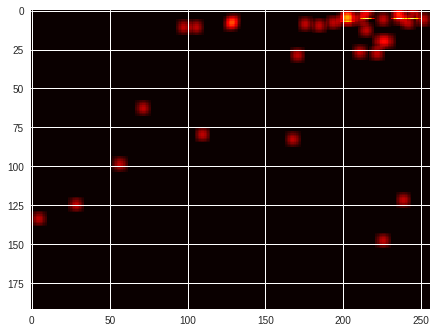

##2925 >> avg_loss:22.7599354	  GT:250.0000000	 predict:265.1834412


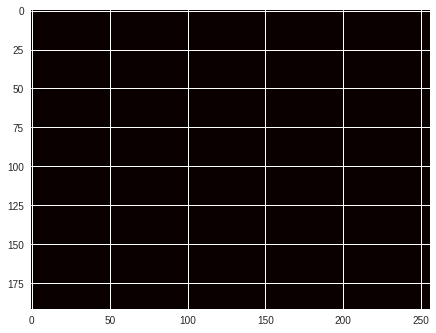

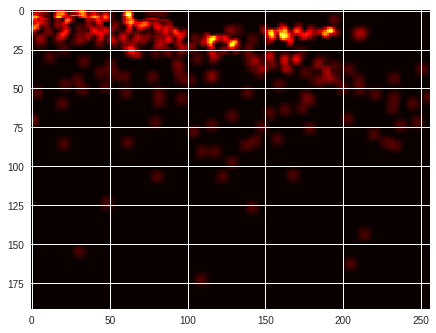

##2950 >> avg_loss:200.5225830	  GT:6.2257037	 predict:128.2431946


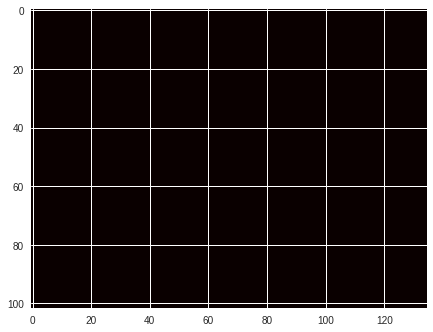

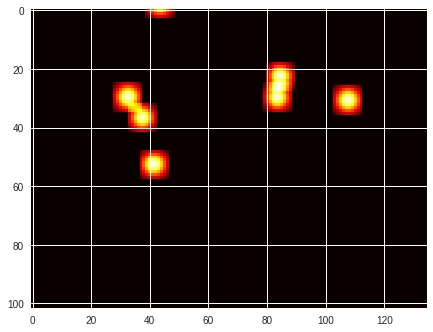

##2975 >> avg_loss:37.7246399	  GT:268.0000000	 predict:333.7756958


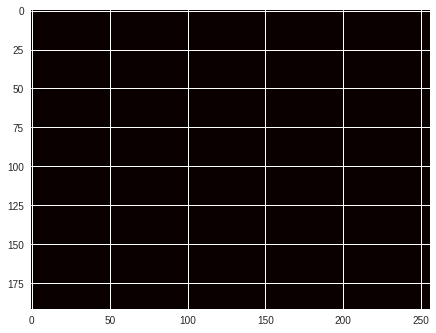

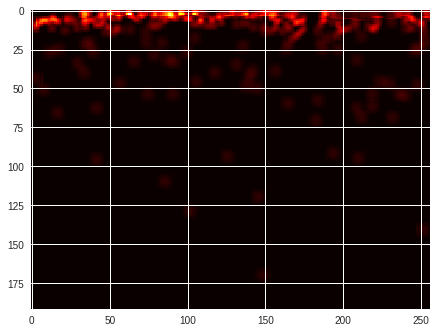

##3000 >> avg_loss:54.8142700	  GT:44.9999771	 predict:332.6618042


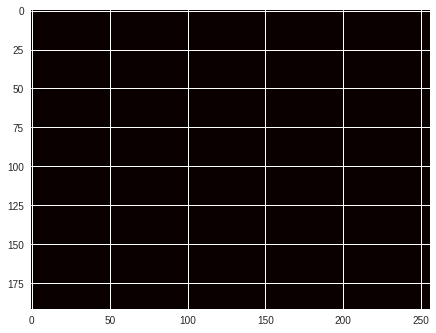

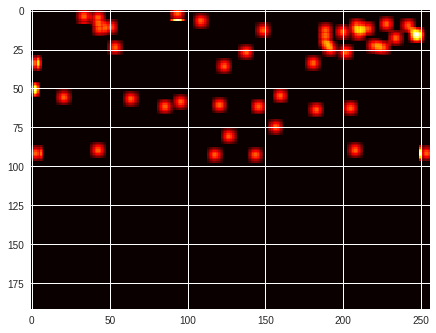

##3025 >> avg_loss:76.9323120	  GT:92.2214890	 predict:255.3407745


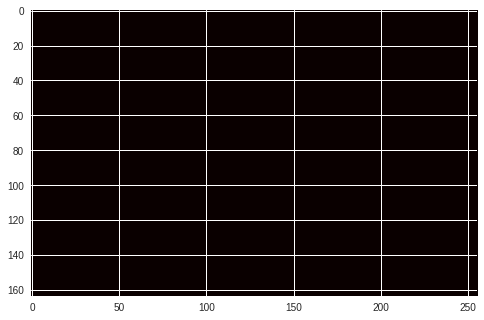

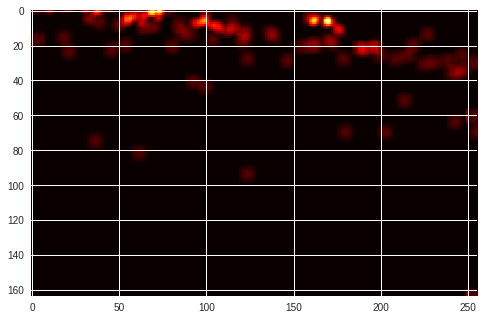

##3050 >> avg_loss:35.1962280	  GT:134.9999542	 predict:295.0591736


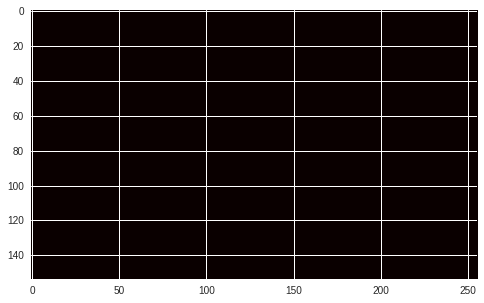

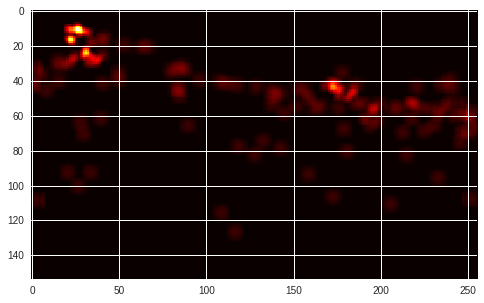

##3075 >> avg_loss:94.9582901	  GT:81.0000000	 predict:126.3402710


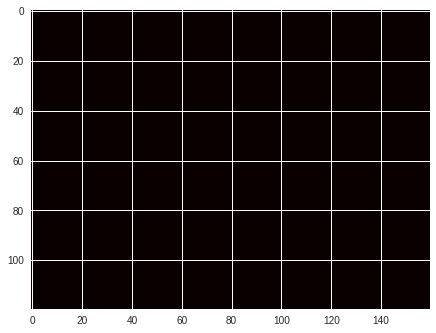

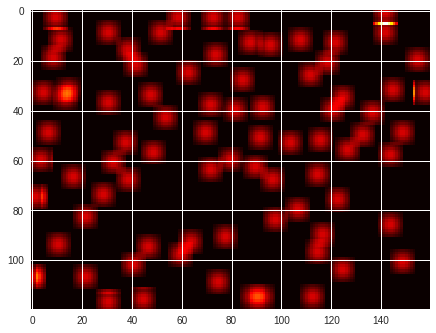

##3100 >> avg_loss:46.3144989	  GT:31.5118389	 predict:251.8134460


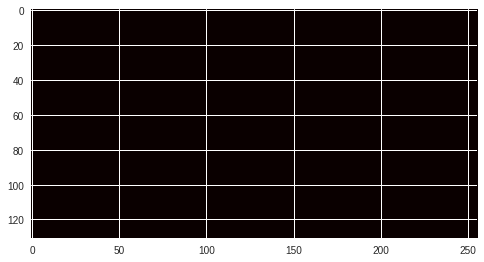

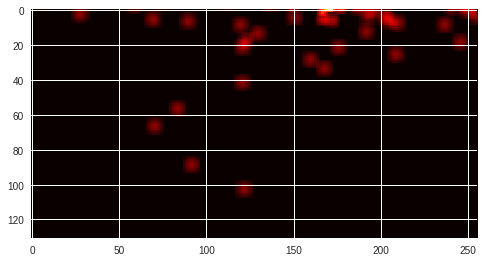

##3125 >> avg_loss:151.7113647	  GT:1155.9995117	 predict:408.1328430


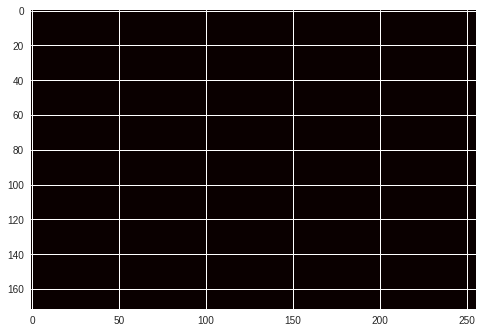

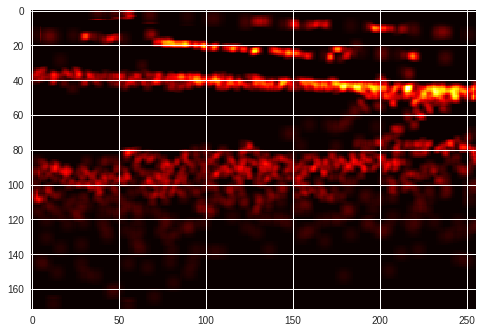

##3150 >> avg_loss:92.7181320	  GT:138.9999847	 predict:346.5726318


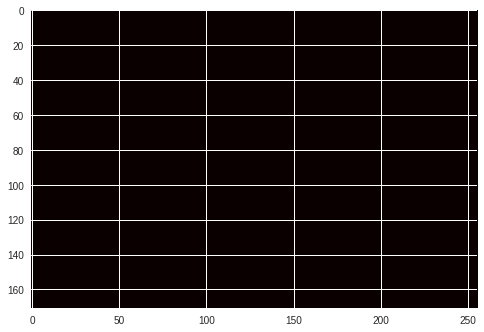

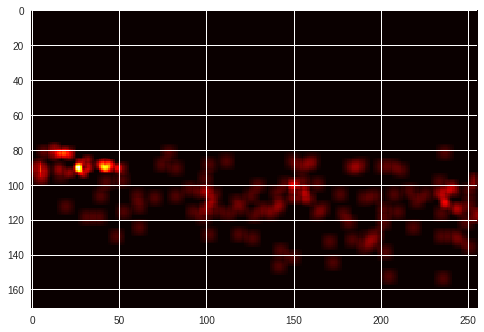

##3175 >> avg_loss:31.5009613	  GT:107.9999924	 predict:305.9946594


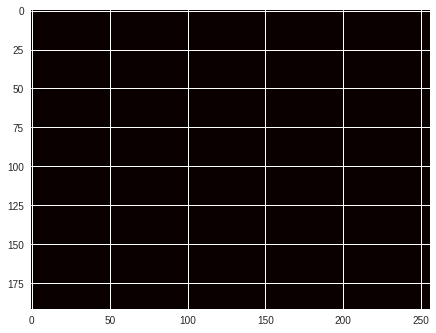

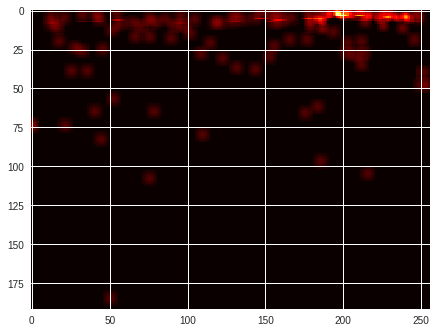

##3200 >> avg_loss:153.2412109	  GT:149.9999847	 predict:317.4326477


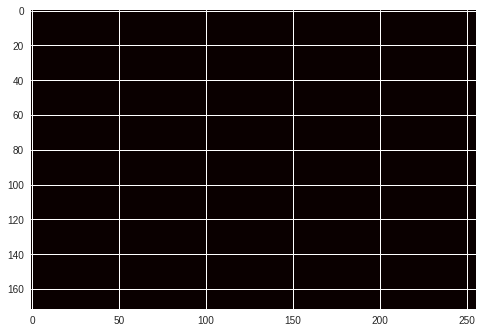

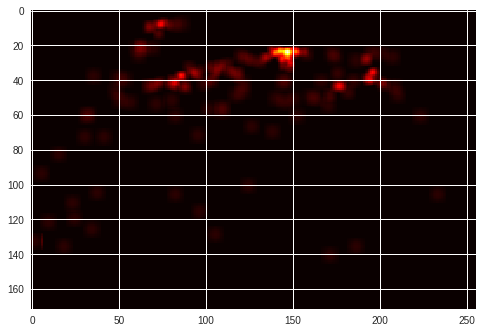

##3225 >> avg_loss:41.9868088	  GT:79.9999924	 predict:328.7108765


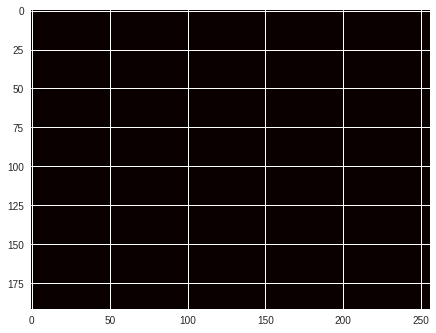

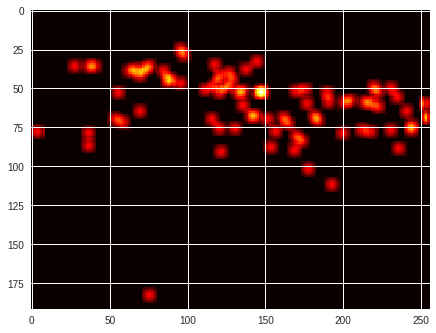

##3250 >> avg_loss:48.6617050	  GT:28.0558472	 predict:160.8273468


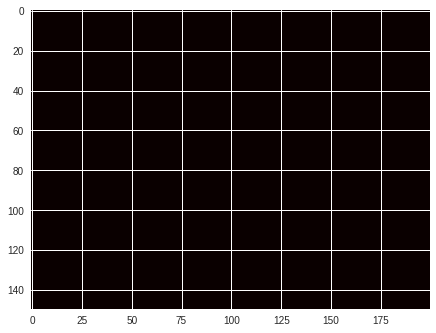

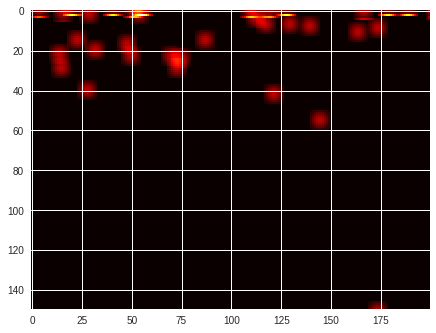

##3275 >> avg_loss:103.9359283	  GT:398.5842590	 predict:70.5219421


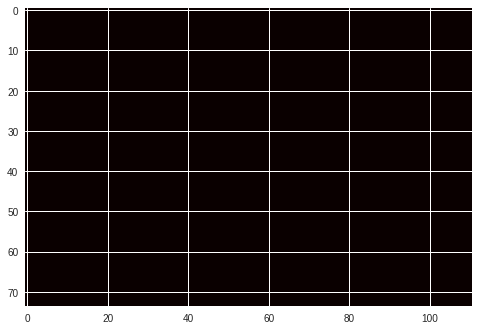

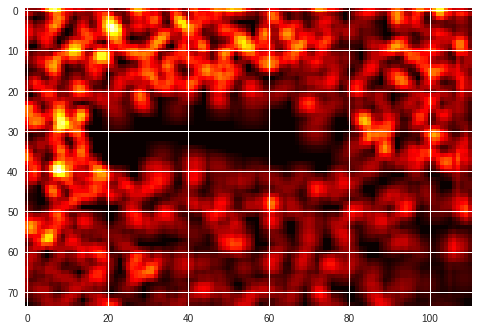

##3300 >> avg_loss:501.1007690	  GT:153.7667847	 predict:272.9178162


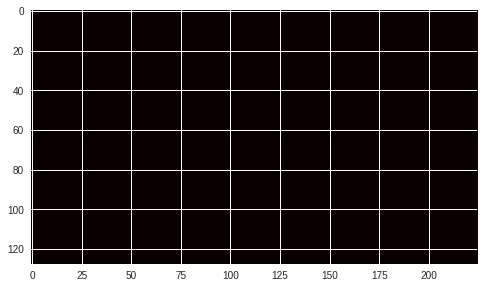

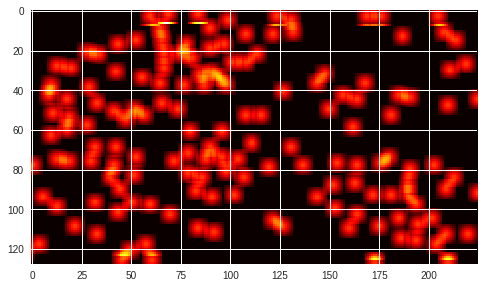

##3325 >> avg_loss:11.1373625	  GT:2.0953081	 predict:98.0198593


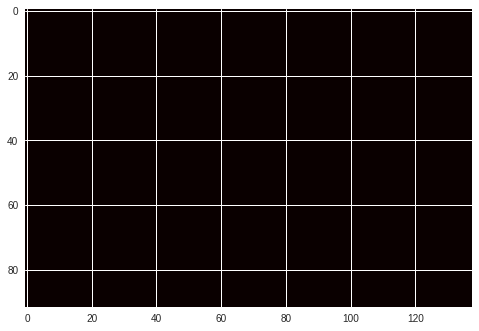

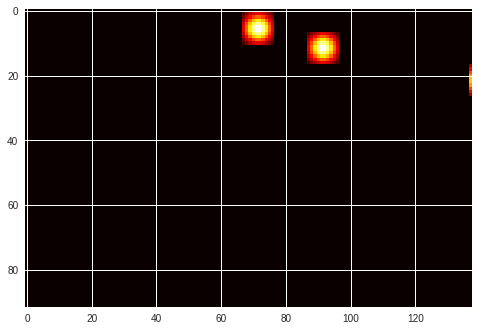

##3350 >> avg_loss:4.8956552	  GT:141.9999542	 predict:42.2754860


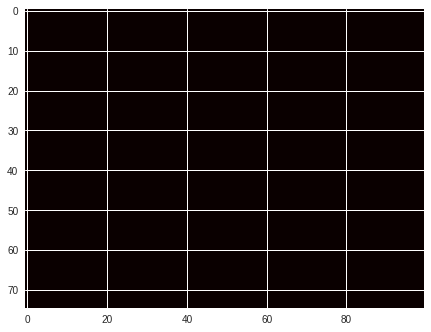

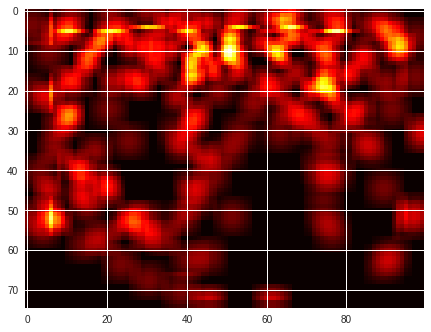

##3375 >> avg_loss:20.6598282	  GT:76.9999847	 predict:148.5467377


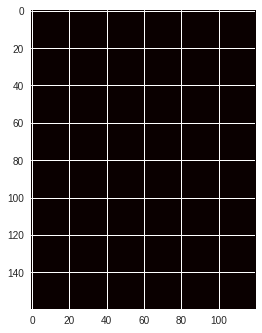

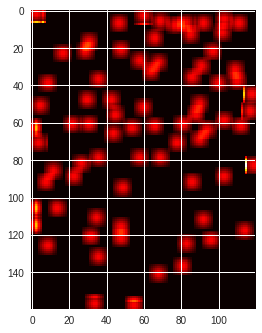

##3400 >> avg_loss:18.8813210	  GT:475.9999084	 predict:291.0599060


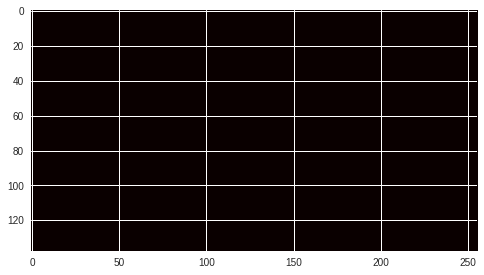

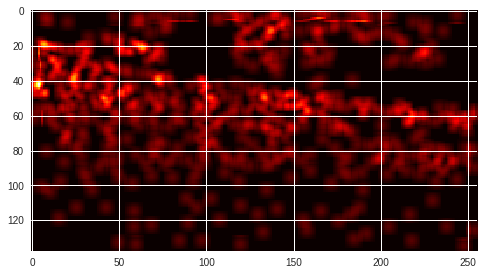

##3425 >> avg_loss:18.5812340	  GT:123.2529602	 predict:89.1523285


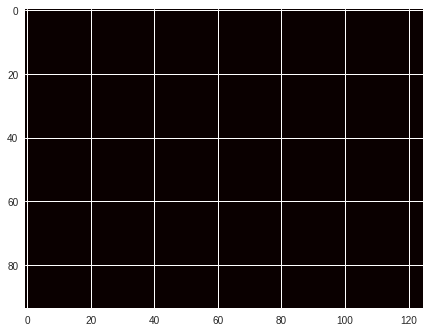

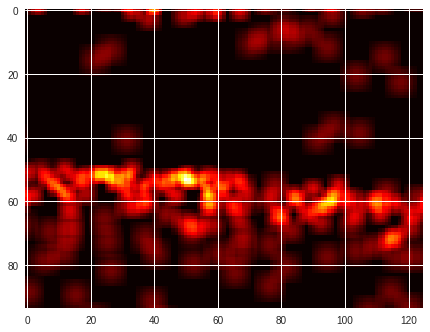

##3450 >> avg_loss:18.1515312	  GT:146.0000000	 predict:359.7081604


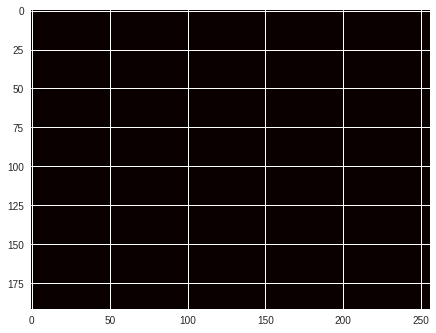

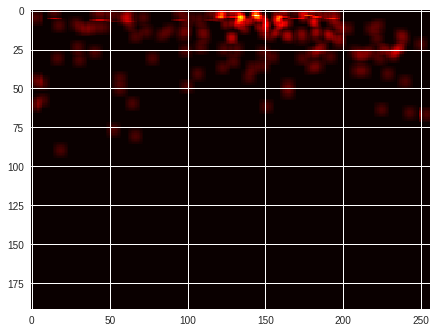

##3475 >> avg_loss:15.1181355	  GT:168.5061493	 predict:252.3544922


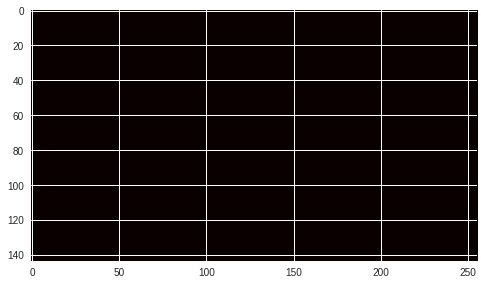

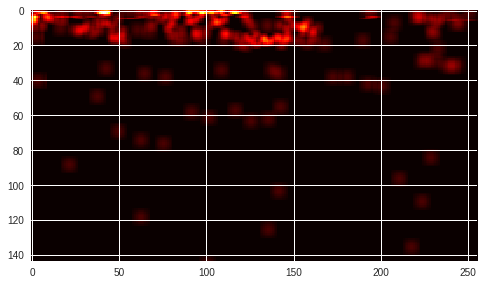

##3500 >> avg_loss:177.9367828	  GT:723.4588623	 predict:256.4841614


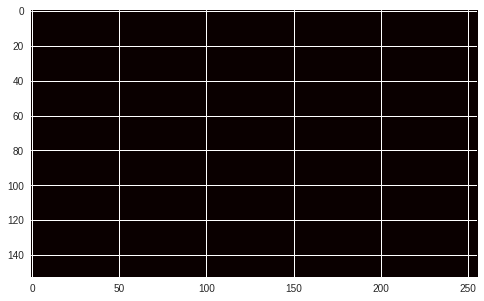

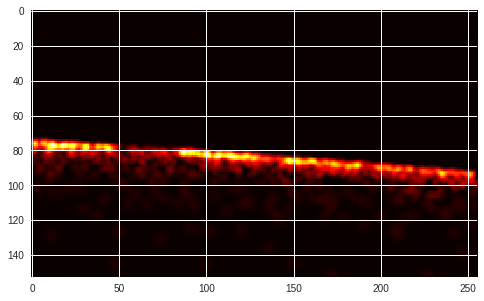

##3525 >> avg_loss:9.3122540	  GT:38.5100479	 predict:138.5352936


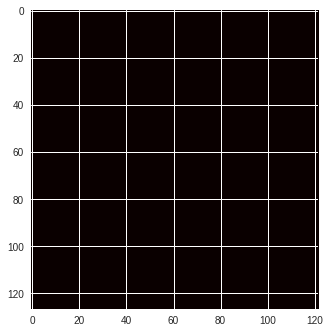

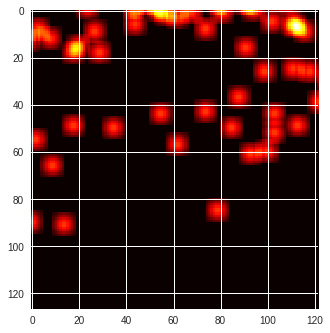

##3550 >> avg_loss:1.8615243	  GT:3.0000000	 predict:66.2711182


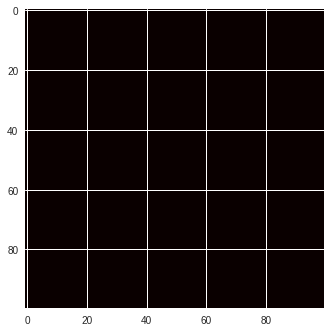

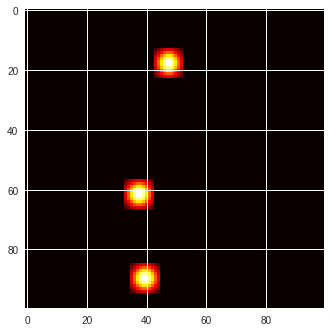

##3575 >> avg_loss:21.2644653	  GT:32.3469238	 predict:85.4015427


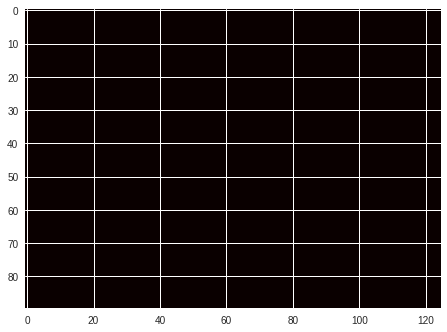

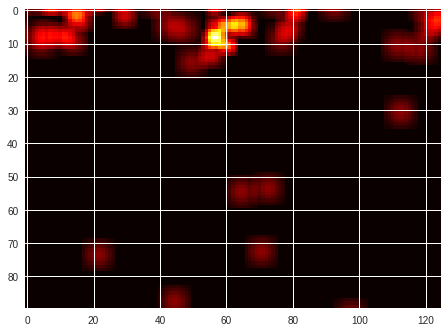

##3600 >> avg_loss:8.5645380	  GT:49.0000038	 predict:82.3542252


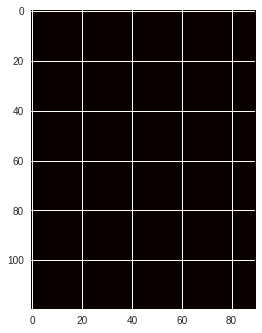

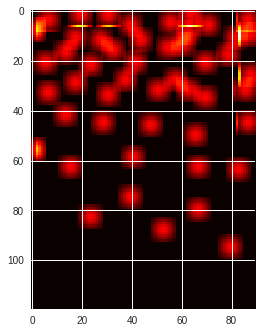

##3625 >> avg_loss:51.9679031	  GT:157.0001221	 predict:328.6045837


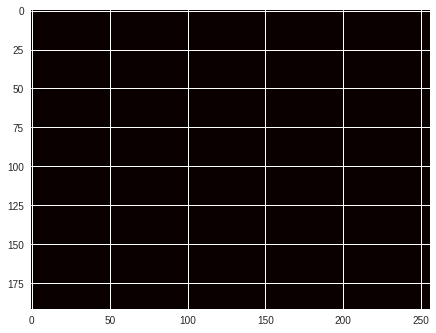

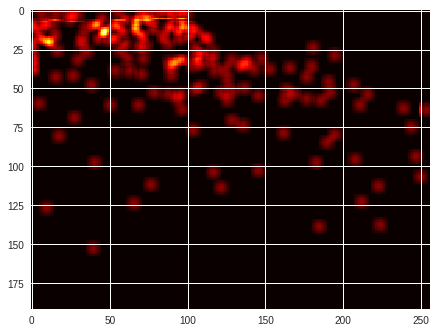

##3650 >> avg_loss:25.2271080	  GT:78.0000687	 predict:317.2734070


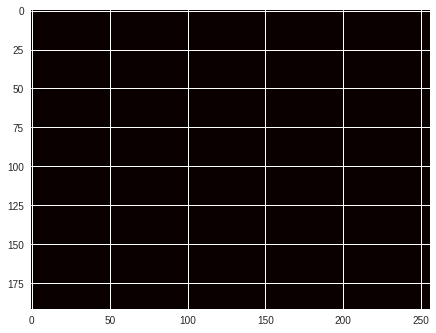

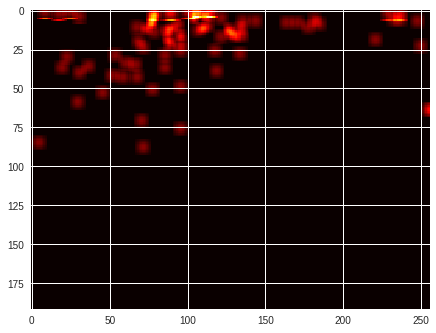

##3675 >> avg_loss:183.1748352	  GT:706.9999390	 predict:243.4783478


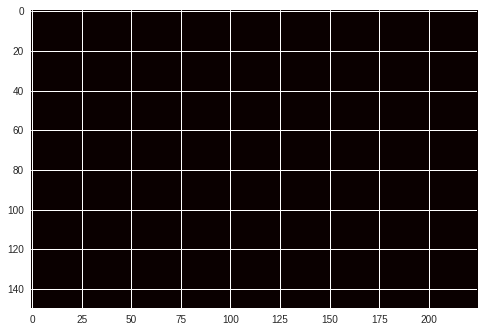

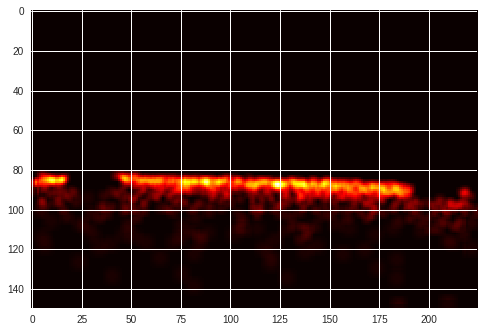

##3700 >> avg_loss:41.8278694	  GT:607.5440063	 predict:135.8071747


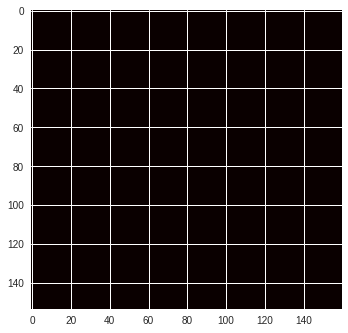

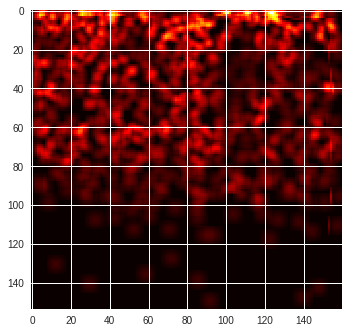

##3725 >> avg_loss:1111.1322021	  GT:35.3476601	 predict:278.2413330


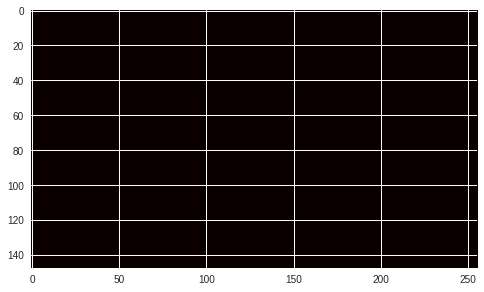

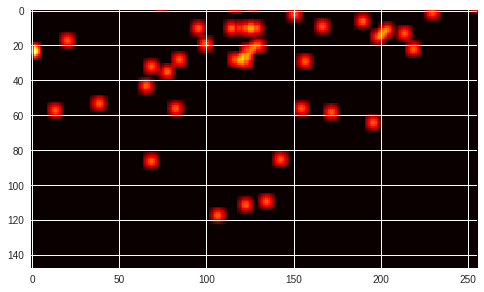

##3750 >> avg_loss:151.6753998	  GT:185.1231689	 predict:256.2329407


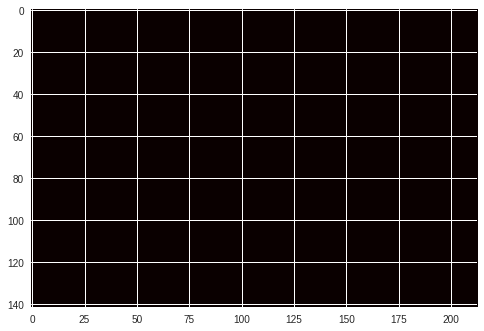

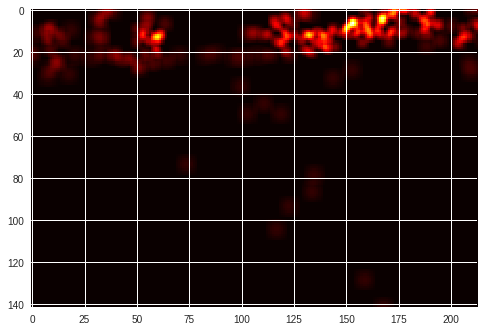

##3775 >> avg_loss:86.8012695	  GT:113.9999924	 predict:274.9365845


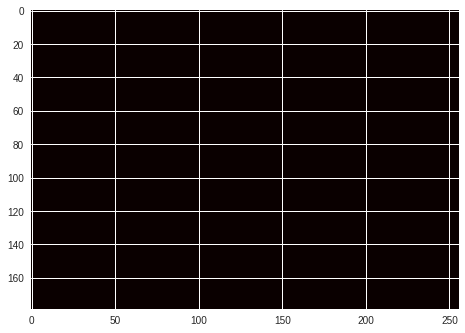

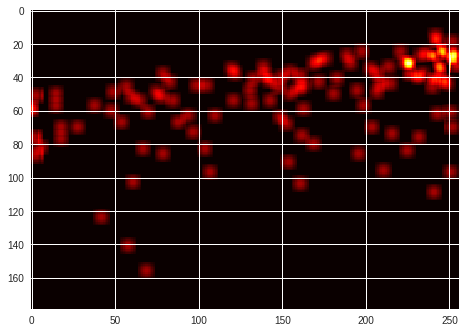

##3800 >> avg_loss:68.3043900	  GT:12.5332899	 predict:237.0380249


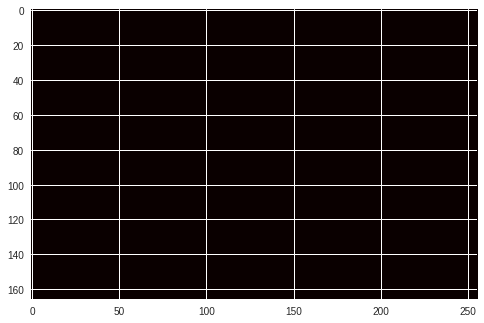

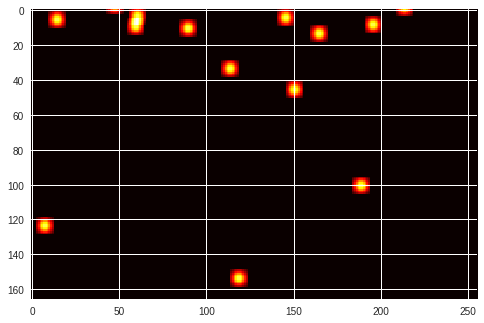

##3825 >> avg_loss:38.4687157	  GT:5.0000005	 predict:123.7779083


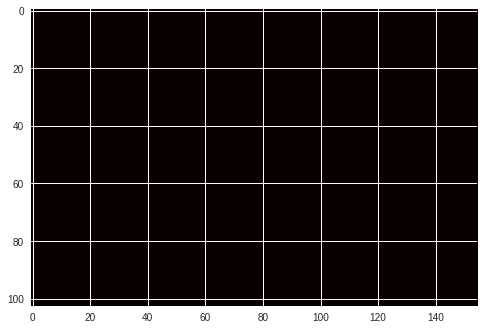

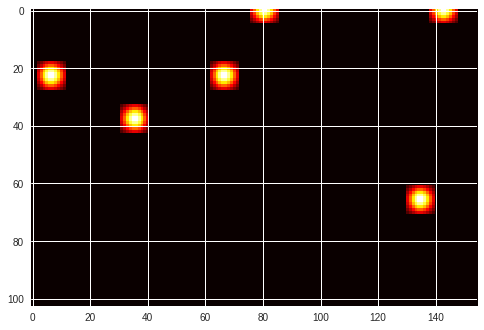

##3850 >> avg_loss:50.3012695	  GT:211.0000000	 predict:288.2701416


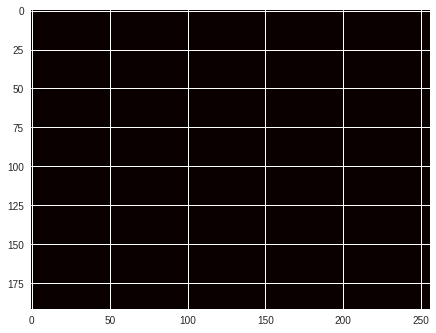

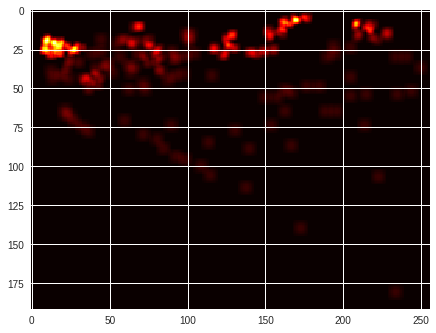

##3875 >> avg_loss:126.6074753	  GT:7.0000005	 predict:89.2708664


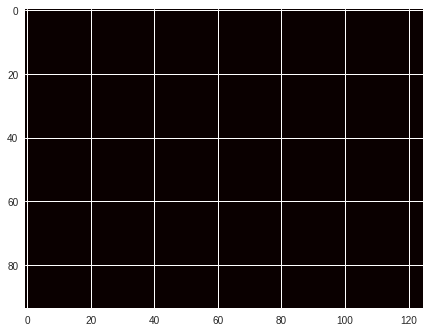

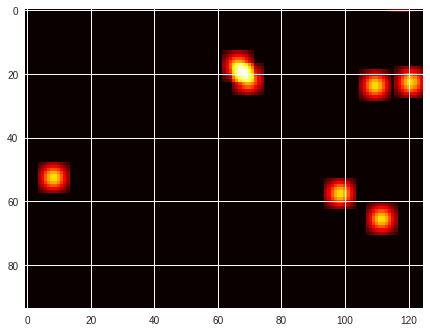

##3900 >> avg_loss:547.2080688	  GT:126.5186920	 predict:338.6512451


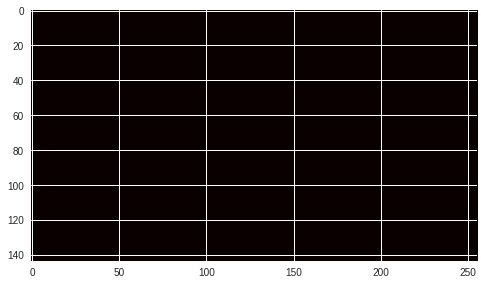

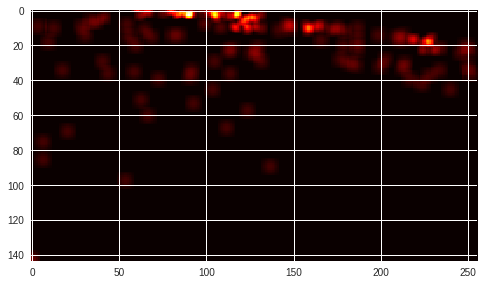

##3925 >> avg_loss:32.5899849	  GT:354.0000610	 predict:37.7542725


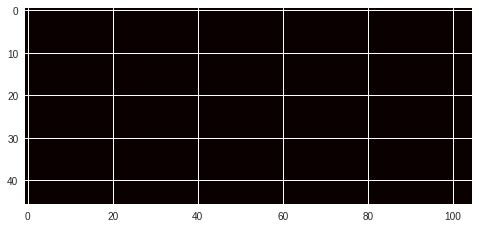

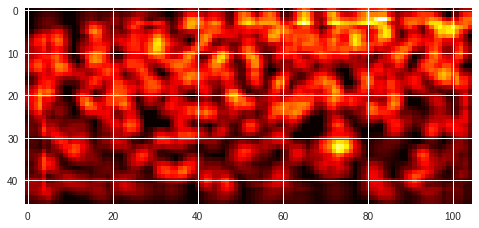

##3950 >> avg_loss:31.1032200	  GT:354.0000305	 predict:42.3995399


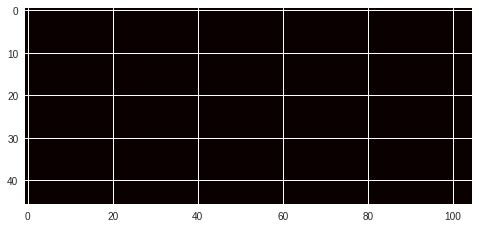

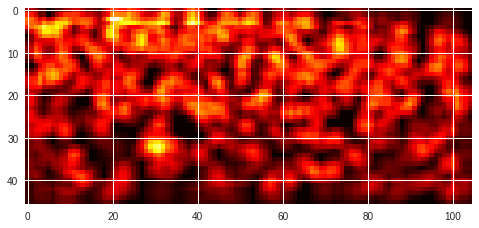

##3975 >> avg_loss:38.1822433	  GT:60.9999542	 predict:294.9635010


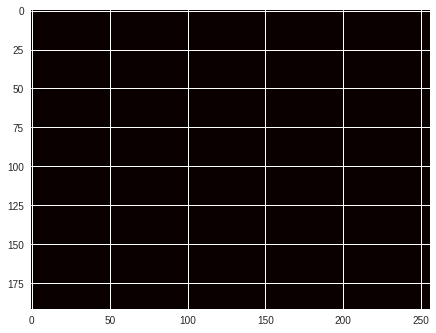

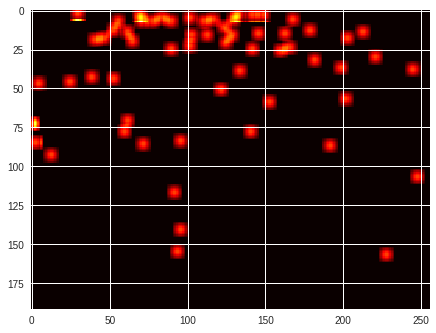

##4000 >> avg_loss:13.7322664	  GT:8.6683092	 predict:76.7770996


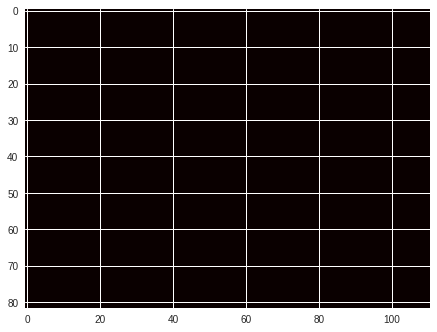

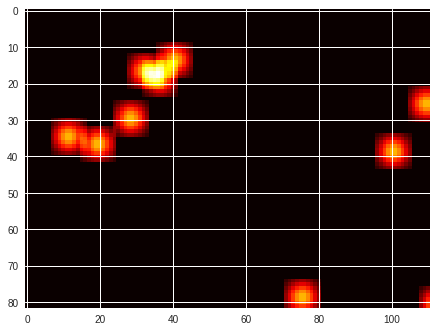

##4025 >> avg_loss:285.0059204	  GT:965.0650635	 predict:246.0579834


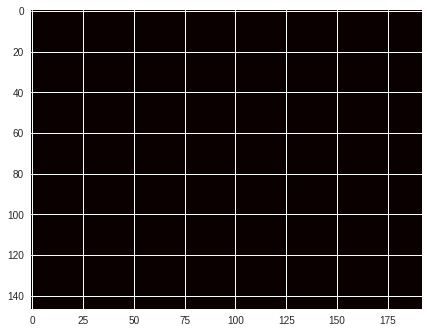

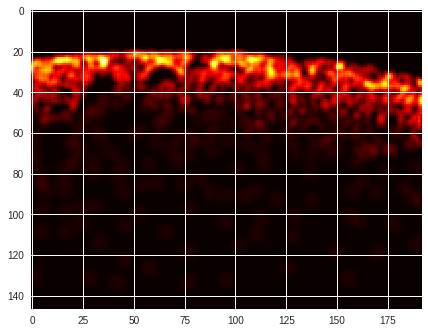

##4050 >> avg_loss:199.5493164	  GT:1044.9998779	 predict:80.1692581


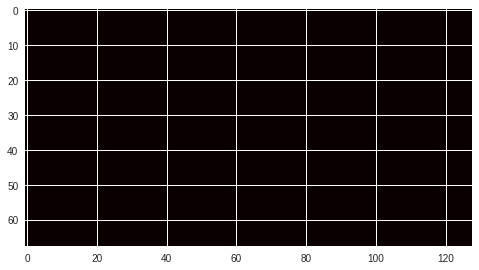

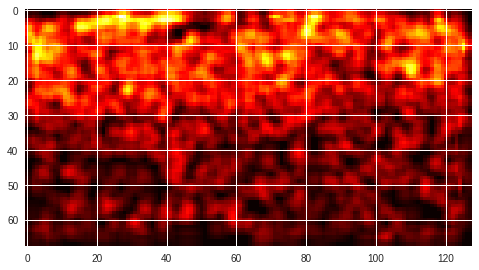

##4075 >> avg_loss:64.8279572	  GT:23.7104778	 predict:162.6041412


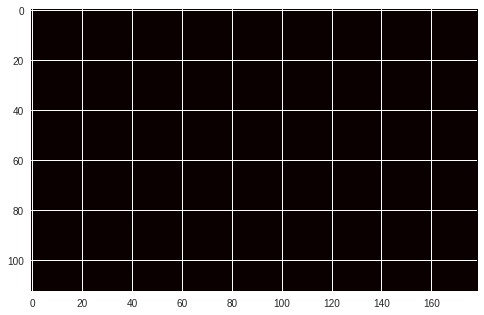

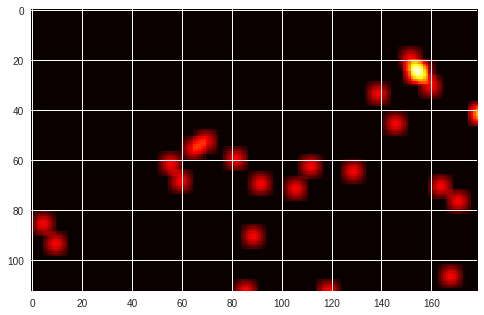

##4100 >> avg_loss:247.0401001	  GT:23.2256889	 predict:255.0158234


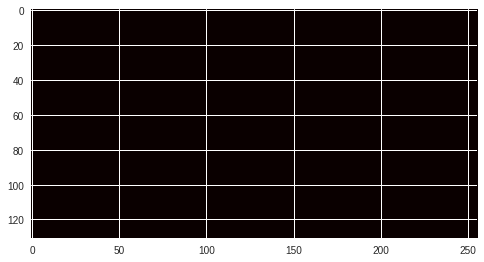

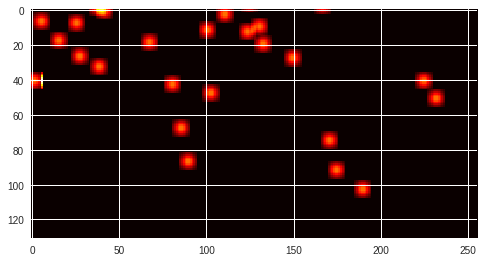

##4125 >> avg_loss:10.4109497	  GT:224.0185242	 predict:75.0601273


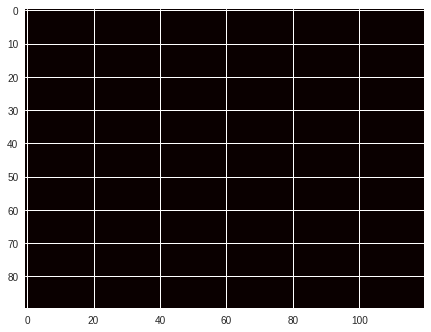

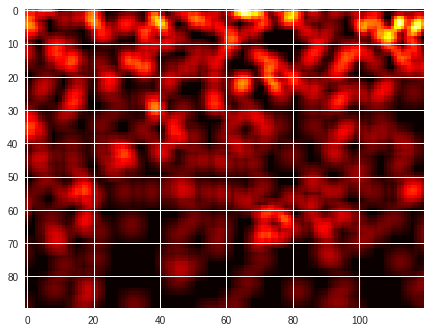

##4150 >> avg_loss:59.0766907	  GT:65.1771927	 predict:319.2025146


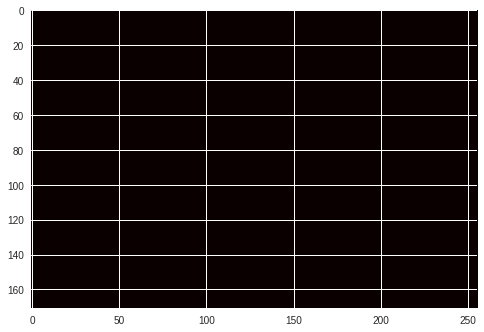

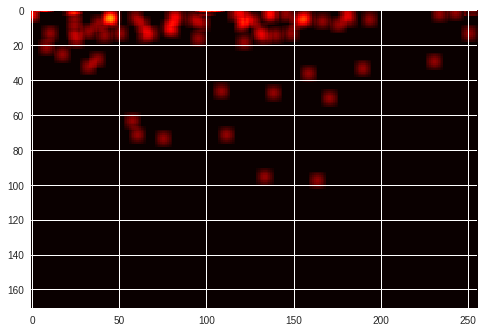

##4175 >> avg_loss:16.6006641	  GT:727.9998169	 predict:219.4101868


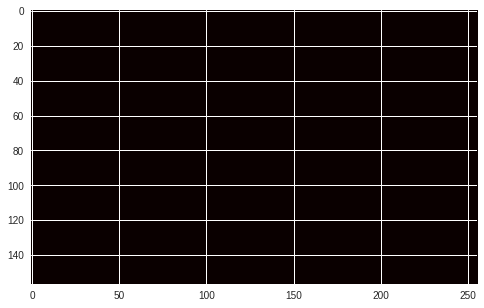

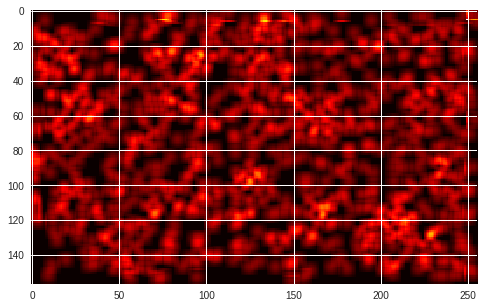

##4200 >> avg_loss:16.3680878	  GT:1.3552394	 predict:39.1222038


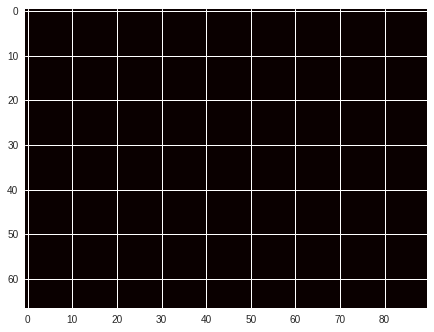

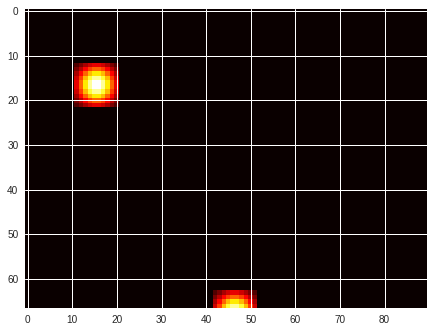

##4225 >> avg_loss:563.1678467	  GT:588.0000000	 predict:504.8530579


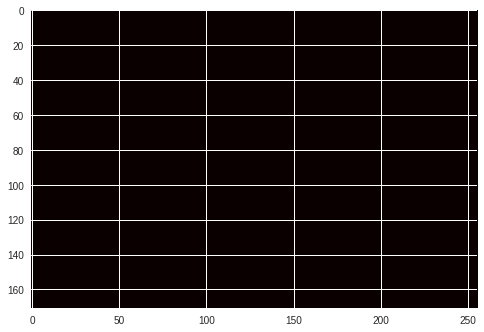

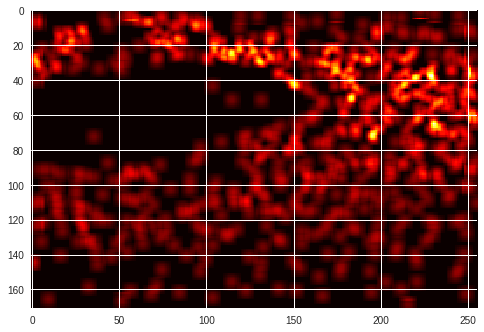

##4250 >> avg_loss:797.0372925	  GT:24.5030956	 predict:245.2675781


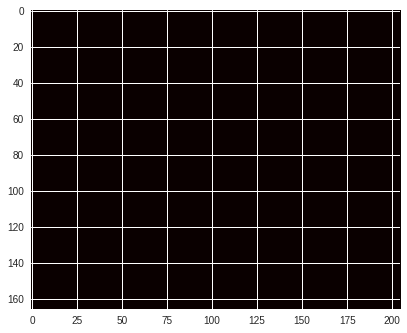

##4275 >> avg_loss:24.3956413	  GT:52.5560341	 predict:396.2006226


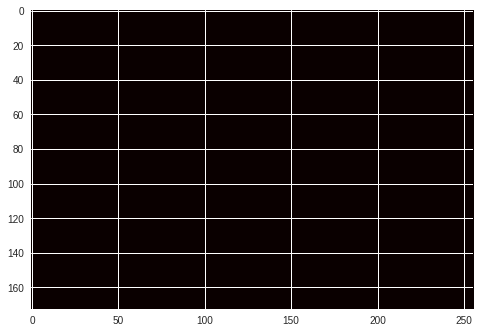

##4300 >> avg_loss:64.4751816	  GT:700.9998779	 predict:192.0037689


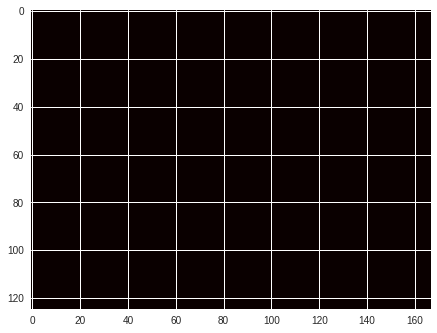

##4325 >> avg_loss:78.6183472	  GT:26.2297630	 predict:166.5512695


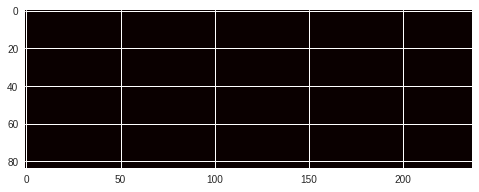

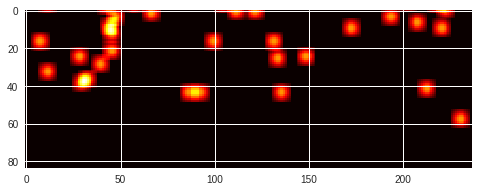

##4350 >> avg_loss:56.0898132	  GT:242.9457855	 predict:261.8176880


##4375 >> avg_loss:17.0312805	  GT:30.9999924	 predict:263.8525085


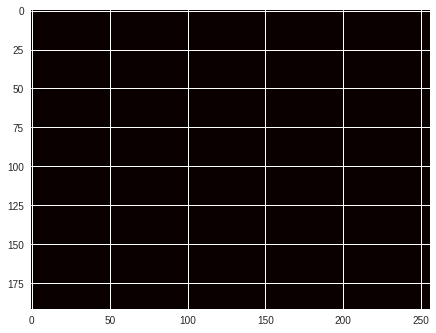

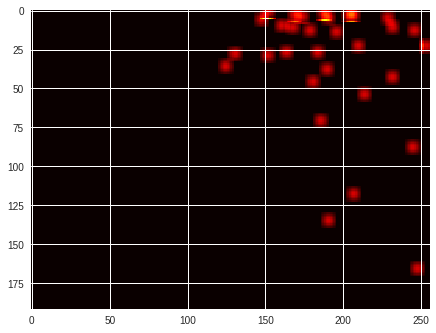

##4400 >> avg_loss:58.7623329	  GT:289.9999390	 predict:295.3333435


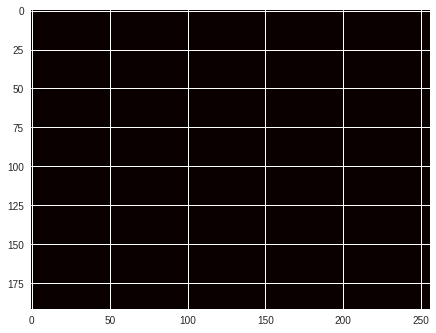

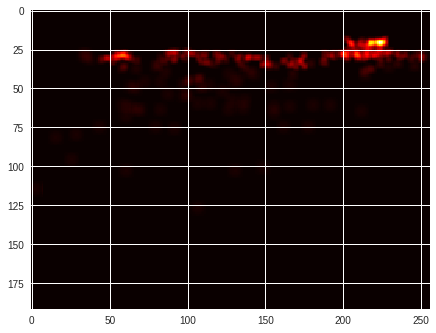

##4425 >> avg_loss:10.5349541	  GT:43.4601021	 predict:89.3646011


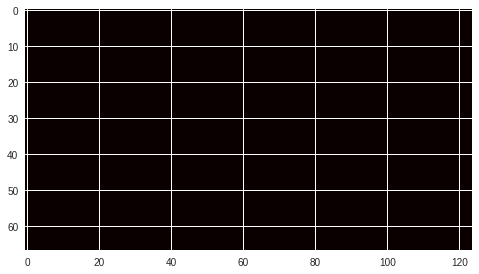

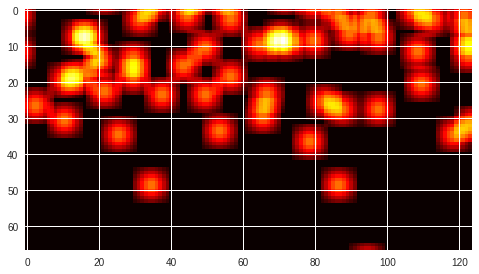

##4450 >> avg_loss:24.3264427	  GT:7.6832786	 predict:73.8537674


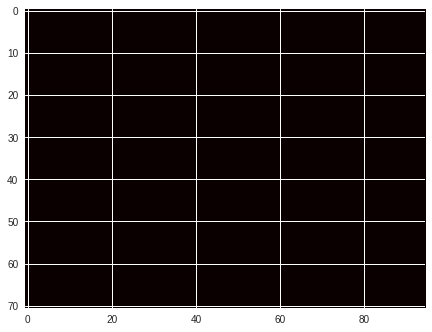

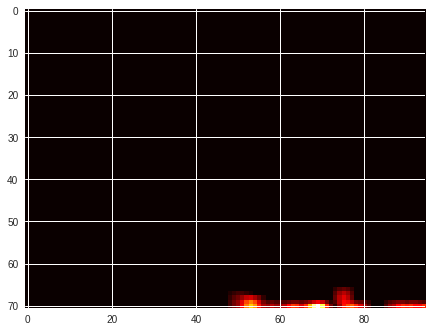

##4475 >> avg_loss:13.2020512	  GT:7.2400689	 predict:58.7588463


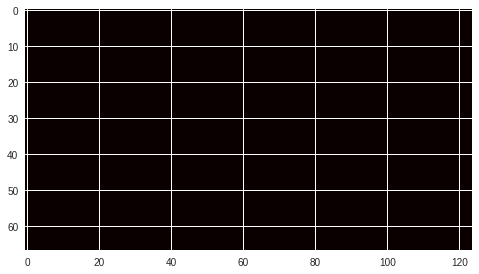

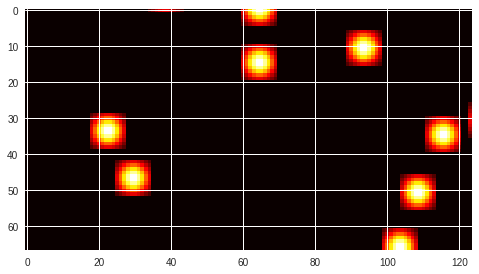

##4500 >> avg_loss:44.8135605	  GT:214.2531281	 predict:92.4121094


KeyboardInterrupt: ignored

In [8]:

import os.path
import random
import cv2
from six.moves import xrange

import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np


num_epochs_per_decay = 20
learning_rate_per_decay = 0.9
initial_learning_rate = 1.0e-1


def Compile():
    fig = plt.figure()
    with tf.Graph().as_default():
        
        dir_file = open(params['data_train_index'])
        dir_name = dir_file.readlines()

    
        nums_train = len(dir_name)
        global_step = tf.Variable(0, trainable=False)

   
        image = tf.placeholder("float",[params['batch_size'],None,None,3])
        label = tf.placeholder("float",[params['batch_size'],None,None,1])
        avg_loss = tf.placeholder("float")

        predicts = inference_bn_(image) 
        rnking_loss = get_ranking_loss(predicts, label)
        loss = get_loss(predicts, label)  + rnking_loss
        train_op = train(loss, global_step, nums_train)  

        sess = tf.Session()  
        saver = tf.train.Saver(tf.all_variables())  

        init = tf.initialize_all_variables()  
        sess.run(init)  

        checkpoint_dir = tf.train.get_checkpoint_state(params['model_dir'])
        if checkpoint_dir and checkpoint_dir.model_checkpoint_path:
            saver.restore(sess, checkpoint_dir.model_checkpoint_path)
        else:
            print('Not found checkpoint file')

        summary_op = tf.summary.merge_all() 
        add_avg_loss_op = add_avg_loss(avg_loss)  
        summary_writer = tf.summary.FileWriter(params['train_log'], graph_def=sess.graph_def)

        steps = 100000
        avg_loss_1 = 0

        for step in xrange(steps):
            #if step < nums_train * 10:
               
              #  num_batch = [divmod(step, nums_train)[1] + i for i in range(params['batch_size'])]
                
            #else:
               
            np_xs, np_ys = get_data(dir_name)
         
            _, loss_value = sess.run([train_op, loss], feed_dict={image: np_xs, label: np_ys})
            
            output = sess.run(predicts, feed_dict={image: np_xs})
            avg_loss_1 += loss_value

            if step % 100 == 0:
              
                summary_str = sess.run(summary_op, feed_dict={image: np_xs, label: np_ys,
                                                              avg_loss: avg_loss_1 / 100})
                summary_writer.add_summary(summary_str, step)
                avg_loss_1 = 0

            if step % 25 == 0:
              
                print("##"+str(step)+" >> avg_loss:%.7f\t  GT:%.7f\t predict:%.7f" % \
                      (loss_value, sum(sum(sum(np_ys[0]))), sum(sum(sum(output[0])))))
                
                sess.run(add_avg_loss_op, feed_dict={avg_loss: loss_value})
                
                plt.imshow(output[0,:,:,0],cmap = 'hot')

                plt.show()
                plt.imshow(np_ys[0,:,:,0] ,cmap = 'hot')

                plt.show()
                
                #print (output[0],np_ys[0])
                
                #plt.imshow(np.concatenate([output[0,:,:,0],np_ys[0,:,:,0] ],1),cmap = 'hot')

                #plt.show()
                
                

            if step % 2000 == 0:
                checkpoint_path = os.path.join(params['model_dir'], 'skip_mcnn.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)

            if step % 500 == 0:
                out_path = os.path.join(params['output_dir'], str(step) + "out.npy")
                np.save(out_path, output)


def main(argv=None):
    if gfile.Exists(params['train_log']):
        shutil.rmtree(params['train_log'],ignore_errors=True)
    gfile.MakeDirs(params['train_log'])

    if not gfile.Exists(params['model_dir']):
        gfile.MakeDirs(params['model_dir'])

    if not gfile.Exists(params['output_dir']):
        gfile.MakeDirs(params['output_dir'])

    Compile()


if __name__ == '__main__':
    tf.app.run()


Not found checkpoint file
2343.7656
##0 >> avg_loss:253613.5625000	 ranking loss: 	 GT:1322.6855469	 predict:15192.7900391


0.0
##500 >> avg_loss:74.1225510	 ranking loss: 	 GT:74.6332016	 predict:0.0002534


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


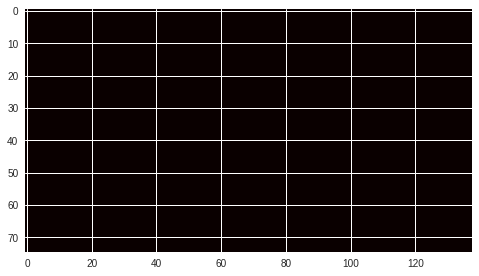

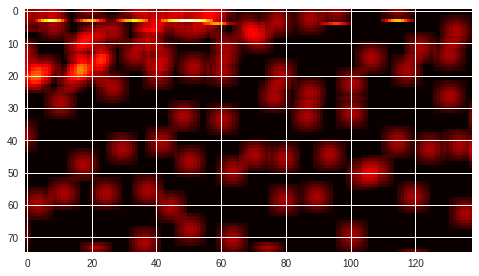

0.0
##1000 >> avg_loss:17.9543018	 ranking loss: 	 GT:246.9154358	 predict:0.0000000


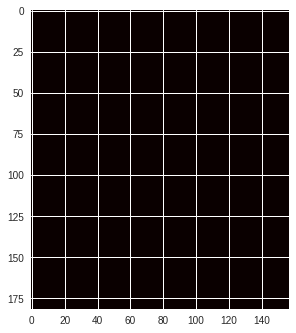

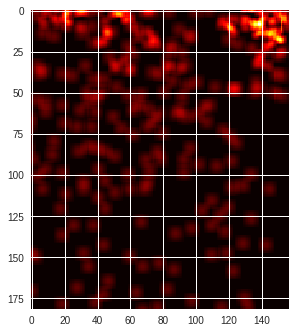

KeyboardInterrupt: ignored

In [0]:

import os.path
import random
import cv2
from six.moves import xrange

import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np


num_epochs_per_decay = 20
learning_rate_per_decay = 0.9
initial_learning_rate = 1.0e-1


def Compile():
    fig = plt.figure()
    with tf.Graph().as_default():
        
        dir_file = open(params['data_train_index'])
        dir_name = dir_file.readlines()

    
        nums_train = len(dir_name)
        global_step = tf.Variable(0, trainable=False)

   
        image1 = tf.placeholder("float",[None,None,None,3])
        label1 = tf.placeholder("float",[None,None,None,1])
      
        image2= tf.placeholder("float",[None,None,None,3])
        label2= tf.placeholder("float",[None,None,None,1])
        
        
        avg_loss = tf.placeholder("float")

        predicts1= inference_bn_(image1)  
        loss1 = get_loss(predicts1, label1)  
                                 
        predicts2 =  inference_bn_(image2)  
        loss2 = get_loss(predicts2, label2)
        
        rnkng_loss = _ranking_loss_(tf.reduce_sum(predicts1),tf.reduce_sum(predicts2),tf.reduce_sum(label1),tf.reduce_sum(label2))
        
        loss = loss1 + loss2 + 100 * rnkng_loss
        
        train_op = train(loss, global_step, nums_train)  

        sess = tf.Session()  
        saver = tf.train.Saver(tf.all_variables())  

        init = tf.initialize_all_variables()  
        sess.run(init)  

        checkpoint_dir = tf.train.get_checkpoint_state(params['model_dir'])
        if checkpoint_dir and checkpoint_dir.model_checkpoint_path:
            saver.restore(sess, checkpoint_dir.model_checkpoint_path)
        else:
            print('Not found checkpoint file')

        summary_op = tf.summary.merge_all() 
        add_avg_loss_op = add_avg_loss(avg_loss)  
        summary_writer = tf.summary.FileWriter(params['train_log'], graph_def=sess.graph_def)

        steps = 100000
        avg_loss_1 = 0

        for step in xrange(steps):
            
            
            np_xs, np_ys = get_data(dir_name)
            np_xs2, np_ys2 = get_data(dir_name)
              
         
            _, loss_value,_rnkng_loss = sess.run([train_op, loss, rnkng_loss], feed_dict={image1: np_xs, label1: np_ys, image2: np_xs2, label2: np_ys2})
            output = sess.run(predicts1, feed_dict={image1: np_xs})
            avg_loss_1 += loss_value

            if step % 100 == 0:
              
                summary_str = sess.run(summary_op, feed_dict={image1: np_xs, label1: np_ys, image2: np_xs2, label2: np_ys2,
                                                              avg_loss: avg_loss_1 / 100})
                summary_writer.add_summary(summary_str, step)
                avg_loss_1 = 0

            if step % 500 == 0:
                
                print (_rnkng_loss)
              
                print("##"+str(step)+" >> avg_loss:%.7f\t ranking loss: \t GT:%.7f\t predict:%.7f" % \
                      (loss_value, sum(sum(sum(np_ys))), sum(sum(sum(output)))))
                
                sess.run(add_avg_loss_op, feed_dict={avg_loss: loss_value})
                
                
                fig.add_subplot(121)   #top left
                
                plt.imshow(output[0,:,:,0], cmap ='hot')
                plt.show()
                
                fig.add_subplot(122)   #top right

        
                plt.imshow(np_ys[0,:,:,0], cmap ='hot')
                plt.show()
                
                #plt.imshow(np.concatenate([output[0,:,:,0],np_ys[0,:,:,0] ],1),cmap = 'hot')

                #plt.show()
                

            if step % 2000 == 0:
                checkpoint_path = os.path.join(params['model_dir'], 'skip_mcnn.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)

            if step % 500 == 0:
                out_path = os.path.join(params['output_dir'], str(step) + "out.npy")
                np.save(out_path, output)


def main(argv=None):
    if gfile.Exists(params['train_log']):
        shutil.rmtree(params['train_log'],ignore_errors=True)
    gfile.MakeDirs(params['train_log'])

    if not gfile.Exists(params['model_dir']):
        gfile.MakeDirs(params['model_dir'])

    if not gfile.Exists(params['output_dir']):
        gfile.MakeDirs(params['output_dir'])

    Compile()


if __name__ == '__main__':
    tf.app.run()


In [0]:
def _ranking_loss_(i_c,j_c,i_gt,j_gt):
        return tf.cond(i_gt<j_gt, lambda: tf.maximum(0.0, i_c - j_c), lambda: tf.maximum(0.0, j_c - i_c))

In [0]:
def get_ranking_loss(counts, counts_gt):
    
    def _ranking_loss_(i_c,j_c,i_gt,j_gt):
        return tf.cond(i_gt<j_gt, lambda: tf.maximum(0.0, i_c - j_c), lambda: tf.maximum(0.0, j_c - i_c))

    import itertools
    ranking_loss = 0
    
    for i,j in itertools.combinations(np.arange(9), 2):
        ranking_loss = ranking_loss + _ranking_loss_(counts[i], counts[j], counts_gt[i], counts_gt[j])
    
    return ranking_loss

In [0]:

import os.path
import random
import cv2
from six.moves import xrange

import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np





def Compile():

    with tf.Graph().as_default():
        
        dir_file = open(params['data_train_index'])
        dir_name = dir_file.readlines()

    
        nums_train = len(dir_name)
        global_step = tf.Variable(0, trainable=False)

   
        image = tf.placeholder("float",[None,None,None,3])
        label = tf.placeholder("float",[None,None,None,1])
        avg_loss = tf.placeholder("float")
        
        W = tf.placeholder(tf.int32)
        H = tf.placeholder(tf.int32)
        
        losses = []
        densities = []
        gt_densities = []
        counts = []
        counts_gt = []
        
        MAEs = []
        MSEs = []
        
        for i in range(9):
            
            randw = np.random.random()
            randh = np.random.random()
            
            W0 = tf.cast(randw*tf.cast(W-W//4, tf.float32),tf.int32)
            H0 = tf.cast(randh*tf.cast(H-H//4, tf.float32),tf.int32)

            patch_img = image[:,W0:W0+W//4,H0:H0+H//4,:]
            patch_lab = label[:,W0//4:W0//4+tf.cast(tf.ceil((W//4)/4),tf.int32),H0//4:H0//4+tf.cast(tf.ceil((H//4)/4),tf.int32),:]
        
            patch_density = inf(patch_img)
            
            patch_count = tf.reduce_sum(patch_density)
            
            tf.summary.image('lab'+str(i+1),patch_lab,1)
            tf.summary.image('out'+str(i+1),patch_density,1)
            
            patch_count_gt = tf.reduce_sum(patch_lab)
            
            MAE_ = tf.abs(patch_count - patch_count_gt)
            MSE_ = tf.square(patch_count - patch_count_gt)
        
            losses.append(get_loss(patch_density, patch_lab))

            
            densities.append(patch_density)
            gt_densities.append(patch_lab)
            
            counts.append(patch_count)
            counts_gt.append(patch_count_gt)
            
            MAEs.append(MAE_)
            MSEs.append(MSE_)
            
            
        MAE = tf.reduce_sum(MAEs)
        MSE = tf.reduce_sum(MSEs)
        
        ranking_loss = get_ranking_loss(counts, counts_gt)
        

        loss = tf.reduce_sum(losses) +  100 * ranking_loss
        train_op = train(loss, global_step, nums_train)  
        
        sess = tf.Session()  
        saver = tf.train.Saver(tf.all_variables())  

        init = tf.initialize_all_variables()  
        sess.run(init)  

        checkpoint_dir = tf.train.get_checkpoint_state(params['model_dir'])
        
        if checkpoint_dir and checkpoint_dir.model_checkpoint_path:
            saver.restore(sess, checkpoint_dir.model_checkpoint_path)
        else:
            print('Not found checkpoint file')

        summary_op = tf.summary.merge_all() 
        add_avg_loss_op = add_avg_loss(avg_loss)  
        summary_writer = tf.summary.FileWriter(params['train_log'], graph_def=sess.graph_def)

        steps = 100000
        avg_loss_1 = 0
        
        _MAE_ = 0
        _MSE_ = 0

        for step in xrange(steps):
            if step < nums_train * 10:
               
                num_batch = [divmod(step, nums_train)[1] + i for i in range(params['batch_size'])]
            else:
               
                num_batch = random.sample(range(nums_train), nums_train)[0:params['batch_size']]

            xs, ys = [], []
            for index in num_batch:
                
                file_name = dir_name[index]
                im_name, gt_name = file_name.split(' ')
                gt_name = gt_name.split('\n')[0]

               
                batch_xs = cv2.imread(params['data_train_im'] + im_name)
                batch_xs = (np.array(batch_xs, dtype=np.float32))

                
                batch_ys = np.array(np.load(params['data_train_gt'] + gt_name))
                batch_ys = np.array(batch_ys, dtype=np.float32)
                batch_ys = batch_ys.reshape([batch_ys.shape[0], batch_ys.shape[1], -1])

                xs.append(batch_xs)
                ys.append(batch_ys)
                
            np_xs = np.array(xs)
            np_ys = np.array(ys)
  
            _,w,h,_ = np_xs.shape
            _, loss_value, ranking_loss_, MAE_metric, MSE_metric = sess.run([train_op, loss, ranking_loss, MAE, MSE], feed_dict={image: np_xs, label: np_ys, W:w , H:h})
            output, _label = sess.run([densities, gt_densities], feed_dict={image: np_xs, label: np_ys, W:w , H:h})
            avg_loss_1 += loss_value
            _MAE_ += MAE_metric
            _MSE_ += MSE_metric
            
            if step % 500 == 0:
                summary_str = sess.run(summary_op, feed_dict={image: np_xs, label: np_ys,
                                                              avg_loss: avg_loss_1 / 500, W:w , H:h})
                summary_writer.add_summary(summary_str, step)
                print ('')
                print ('#############################################')
                print ('')
                print ('## Step : ' + str(step) + ' Train MAE : ' + str(_MAE_/500) + ' Train MSE : ' + str(np.sqrt(_MSE_/500)))
                print ('')
                print ('#############################################')
                print ('')
                avg_loss_1 = 0
                _MAE_ = 0
                _MSE_ = 0
            
            if step % 100 == 0:
                print("## Step : " +str(step)+" avg_loss:%.7f\t GT:%.7f\t predict:%.7f" % \
                      (loss_value, np.sum(np.array(_label)), np.sum(np.array(output))))
                sess.run(add_avg_loss_op, feed_dict={avg_loss: loss_value, W:w , H:h})
       
                plt.imshow(np.concatenate([output[0][0,:,:,0], _label[0][0,:,:,0]],1),cmap = 'hot')
                plt.show()

            if step % 2000 == 0:
                checkpoint_path = os.path.join(params['model_dir'], 'skip_mcnn.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)

            #if step % 500 == 0:
             #   out_path = os.path.join(params['output_dir'], str(step) + "out.npy")
              #  np.save(out_path, output)


def main(argv=None):
    if gfile.Exists(params['train_log']):
        shutil.rmtree(params['train_log'],ignore_errors=True)
    gfile.MakeDirs(params['train_log'])

    if not gfile.Exists(params['model_dir']):
        gfile.MakeDirs(params['model_dir'])

    if not gfile.Exists(params['output_dir']):
        gfile.MakeDirs(params['output_dir'])

    Compile()


if __name__ == '__main__':
    tf.app.run()

TypeError: ignored

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
tf.reset_default_graph()

In [0]:
!ls

shutil.rmtree(params['train_log'],ignore_errors=True)

Colabstart.py	gdfuse.zip	ngrok			      train_log4
datalab		Init.ipynb	ngrok-stable-linux-amd64.zip  trash.py
DLSETUP_.ipynb	localtunnel.rb	output
drive		model2		starting_script.ipynb


In [20]:
from kaffe.tensorflow import Network

class SaCNN(Network):
    def setup(self):
        (self.feed('data')
             .conv(3, 3, 64, 1, 1, name='conv1_1')
             .conv(3, 3, 64, 1, 1, name='conv1_2')
             .max_pool(2, 2, 2, 2, name='pool1')
             .conv(3, 3, 128, 1, 1, name='conv2_1')
             .conv(3, 3, 128, 1, 1, name='conv2_2')
             .max_pool(2, 2, 2, 2, name='pool2')
             .conv(3, 3, 256, 1, 1, name='conv3_1')
             .conv(3, 3, 256, 1, 1, name='conv3_2')
             .conv(3, 3, 256, 1, 1, name='conv3_3')
             .max_pool(2, 2, 2, 2, name='pool3')
             .conv(3, 3, 512, 1, 1, name='conv4_1')
             .conv(3, 3, 512, 1, 1, name='conv4_2')
             .conv(3, 3, 512, 1, 1, name='conv4_3')
             .max_pool(2, 2, 2, 2, name='pool4')
             .conv(3, 3, 512, 1, 1, name='conv5_1')
             .conv(3, 3, 512, 1, 1, name='conv5_2')
             .conv(3, 3, 512, 1, 1, name='conv5_3')
             .max_pool(3, 3, 1, 1, name='pool5')
             .conv(3, 3, 512, 1, 1, name='conv6_1'))

        (self.feed('conv5_3', 
                   'conv6_1')
             .concat(3, name='concat1')
             .conv(2, 2, 512, 2, 2, biased=False,  relu=False, name='conv_concat1_2x'))

        (self.feed('conv_concat1_2x', 
                   'conv4_3')
             .concat(3, name='concat')
             .conv(3, 3, 512, 1, 1, name='p_conv1')
             .conv(3, 3, 256, 1, 1, name='p_conv2')
             .conv(1, 1, 1, 1, 1, relu=False, name='p_conv3'))

ImportError: ignored

In [0]:
#!git clone https://github.com/ethereon/caffe-tensorflow.git

!export PYTHONPATH='caffe-tensorflow'



In [17]:
import os
os.listdir('caffe-tensorflow')

['README.md',
 '.gitignore',
 '.git',
 'examples',
 'LICENSE.md',
 '.pylintrc',
 'convert.py',
 '.style.yapf',
 'kaffe']